In [1]:
import mturk
import random
from datetime import datetime
import json
from pprint import pprint
import copy
import numpy as np
from collections import OrderedDict
import pandas as pd
import pymongo
import botocore
import uuid
import pdb
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import krippendorff_alpha as ka

C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
with open('../config/mongodb_credentials.json','r') as f:
    mongodb_credentials = json.load(f)

In [3]:
""" Connect to MTurk and to the Mongodb database. Set the boolean below to TRUE to use the marketplace and to FALSE to use the sandbox (testing the HITs)"""
create_hits_in_production = True
is_pilot = False

db_client = pymongo.MongoClient(mongodb_credentials["connection_string"])
db = db_client['textual_entailment']

collection_name = 'hit_results' + ('_sandbox' if not create_hits_in_production else '') + ('_pilots' if is_pilot else '')

hit_result_collection = db[collection_name]
hit_result_collection

Collection(Database(MongoClient(host=['cluster0-shard-00-00.hjstc.mongodb.net:27017', 'cluster0-shard-00-01.hjstc.mongodb.net:27017', 'cluster0-shard-00-02.hjstc.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='Cluster0-shard-0', ssl=True), 'textual_entailment'), 'hit_results')

# Batch ids

591 tasks:
- 500 single evidence (2045 pairs total, 2000 non-gd, 45 gd)
- 91 multiple evidence (409 pairs total (2045/5), 364 non-gd, 45 gd)

Single evidence batch id: d1d6e46a-d9e2-4b3e-93b9-c4b7d1ec414c
    
Multiple evidence batch id: 6a067c12-2f24-4024-af31-4d427b0a2c3b

In [4]:
from pprint import pprint
batch_pipeline = [
    {
        '$project': {
            'batch_id': 1, 
            'type': 1, 
            'scale': 1, 
            'hit': 1, 
            'timestamp': 1
        }
    }, {
        '$group': {
            '_id': '$batch_id', 
            'type': {
                '$max': '$type'
            }, 
            'scale': {
                '$max': '$scale'
            }, 
            'timestamp': {
                '$min': '$timestamp'
            }, 
            'ids': {
                '$addToSet': '$_id'
            }, 
            'reward': {
                '$avg': {
                    '$toDouble': '$hit.Reward'
                }
            }
        }
    }, {
        '$addFields': {
            'count': {
                '$size': '$ids'
            }
        }
    }
]
pprint(list(hit_result_collection.aggregate(batch_pipeline)))

[{'_id': 'd1d6e46a-d9e2-4b3e-93b9-c4b7d1ec414c',
  'count': 500,
  'ids': ['3ROUCZ908I6BEI8XB45KJ1S4PV1OOM',
          '3UQ1LLR27DKE6TBZOTKAQP4559SLA3',
          '3SMIWMMK74HEWW1WYC83Z1XFAJOWUJ',
          '32TZXEA1POWMEXREMIS0T79RFUS145',
          '3RQVKZ7ZSNVQM5RT7KQL1236Y2W72C',
          '30F94FBDOUW78GOW3GMX7RYSH50BTU',
          '3Q9SPIIRXMYUHNNYS7RCZ0LL3GWWA7',
          '3M47JKRKD0DI4KFD4RUU5FGDPR468F',
          '3SNR5F7RA55F65K5JVPJUS249LXEIG',
          '3LEG2HW4VIZ31Y6ZP3OXPUGNWQFF2O',
          '36QZ6V159CPLPFKNE7Y22CUU46SSU0',
          '3X55NP42FRS4DTRC76Y7KYZJ4A23PQ',
          '378G7J1SKOAX704A8CTYVJBCOVUWE2',
          '356ZPKYPVKT5TWO0WRRXASVWDAWYPO',
          '3OEWW2KGRMNKALH8LVR487G5LHUODP',
          '3HEADTGN3S491F9A48828ORHWBIRV0',
          '3HO4MYYR250G2HMQ7UVZ17Y2MIW6UV',
          '3PMR2DOWPRDL2FSXN5UCWXM8RAX45Q',
          '3X52SWXE10HIA2KWCLN35VB93JHWC9',
          '3CKVGCS3QJH59T87G0KID56NOIP0S8',
          '39N6W9XWSGZZGJV1T81AGJH4CJ9YGK',
          '

In [5]:
sing = list(hit_result_collection.find(
    {'type':'single', 'batch_id' : {
        '$in' : ['d1d6e46a-d9e2-4b3e-93b9-c4b7d1ec414c']
    }}))
mult = list(hit_result_collection.find(
    {'type':'multiple', 'batch_id' : {
        '$in' : ['6a067c12-2f24-4024-af31-4d427b0a2c3b']
    }}))

TASK_HITS = {
    'single' : sing,
    'multiple' : mult
}
TASK_TYPES = list(TASK_HITS.keys())


len(sing), len(mult)

(500, 91)

# "Not Sure - Other" reasons

In [6]:
for task_type in TASK_TYPES:
    print(task_type)
    #print(len(TASK_HITS[task_type]))
    for i, hit in enumerate(TASK_HITS[task_type]):
        #print(task_type, i)
        for answer in hit['answers']:
            for output in answer['values']['outputs']:
                if output['reason_not_sure_other'] != '':
                    print(hit['_id'])
                    print(output['reason_not_sure_other'])                    

# EMPTY

single
3UUIU9GZD8H5J07N26VK45Y079E5TN
Possibly typo in author's name? It is very similar to the bibliography's contents.
389A2A305RUP2CJBJEUIY0252F30CE
Th url includes 2016 so that supports the idea but it is not definitive.
3NBFJK3IPKUNM5RZNLSCESJ2Y9AOGZ
Tricky, not sure that an  Acting Librarian of Congress is 
3CO05SML8YHT8E8U1BKDNV1R2F5R08
the passage lacks context, difficult to interpret it one way or the other
3SD15I2WE56W3N97SAZYEY8295C63N
not sure that having a volume published by 
38VTL6WC5DP10M6HCCIJCMQFMAVY52
not englhish
33W1NHWFZKX3QERC9U20T95V87LTZF
the highlighted portion has the correct date, (if not American), but it doesn't have Dorothy's name in it.
35ZRNT9RVLAMSTFBS6LSVYUTU563O9
I can't understand if it's the chemical formula of that compound.
3X7837UUBGA7O1BWVVRLU5PR52Y6JZ
ambiguous wording in the highlighted text; unsure
34KYK9TV3UK6TGBHEGH7XM26FMMBS5
A "Ken" is thanked for his contribution to the creation of OpenStreetMap, but I'm not sure that person is Ken Verm

# Completion time

In [7]:
df_times = {
    'type': [],
    'time': []
}

for task_type in TASK_TYPES:    
    #print(task_type)
    #print(len(TASK_HITS[task_type]))
    for hit in TASK_HITS[task_type]:
        for answer in hit['answers']:
            df_times['type'].append(task_type)
            df_times['time'].append(np.sum(answer['values']['times'])/1000)
            
df_times = pd.DataFrame(df_times)

for task_type in TASK_TYPES: 
    print(df_times[df_times['type'] == task_type]['time'].mean(), f'seconds is the mean {task_type} task time')
    print(df_times[df_times['type'] == task_type]['time'].median(), f'seconds is the median {task_type} task time')

123.39199160000022 seconds is the mean single task time
80.344 seconds is the median single task time
236.3858725274725 seconds is the mean multiple task time
163.687 seconds is the median multiple task time


In [8]:
# According to median values, pay should be
MINIMUM_HOURLY_USD_WAGE = 7.25
for task_type in TASK_TYPES:    
    avg_hit_time_seconds = df_times[df_times['type'] == task_type]['time'].median()
    avg_hit_time_hours = avg_hit_time_seconds/3600
    print(f'{task_type}: USD', avg_hit_time_hours*MINIMUM_HOURLY_USD_WAGE)

# I have then decided to pay 0.50 for Single and 1.00 for Multiple, which is above minimum wage, and based on feedback from
# the pilot (see below)

single: USD 0.16180388888888889
multiple: USD 0.32964743055555557


In [9]:
df_times.sort_values('time')#.head(100)

,type,time
1234,single,21.089
2702,multiple,21.094
2489,single,21.119
1729,single,21.206
2900,multiple,21.514
...,...,...
2814,multiple,2257.006
503,single,2266.236
2339,single,2688.912
2314,single,3666.229


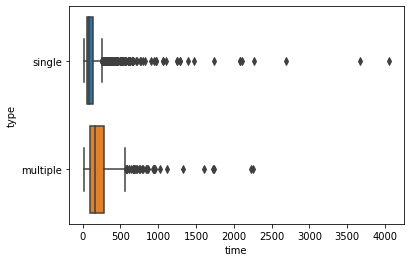

In [10]:
g = sns.boxplot(data = df_times, x='time', y='type')
g.set_xscale("linear")

# Feedback

In [11]:
USELESS_FEEDBACK = [
    'NICE', 'NOTHING', 'NONE', 'GREAT', 'VERY NICE', 'INTERESTING', 'VERY INTERESTING',
    'GOOD', 'NONE.', 'INTRUSTING', 'INTERESTING SURVEY', 'INTERESTING SURVEY.', 'INTRESTING SURVEY',
    'GOOD SURVEY', 'GOOD TO STUDY', 'GOOD JOB', 'NICE WORK', 'NICE WORK.'
]

from pprint import pprint
for task_type in TASK_TYPES:
    print('-'*10, task_type, '-'*10, '\n')
    for hit in TASK_HITS[task_type]:
        for a in hit['answers']:
            if a['values']['feedback'] != None :
                if not a['values']['feedback'].upper() in USELESS_FEEDBACK:
                    print('Hit _id:', hit['_id'])
                    print('Worker ID:', a['worker_id'])
                    print('Assignment ID:', a['assignment_id'])
                    print(a['values']['feedback'])
                    print('-----')
                    print('\n')
                
# Feedback applied!

---------- single ---------- 

Hit _id: 3X7837UUBGA7O1BWVVRLU5PR51XJ69
Worker ID: A3CGQOJC28OVGN
Assignment ID: 3P1L2B7AD516VH3UOEUUG4K3O6TLOJ
On the first one, I tried to put not sure, because I dont read french, but the correct answer was neither. I just think you might want to add that as an example, like if you cant read the language) of neither, because iot is kind of ambiguous in the instructions which one to choose.
-----


Hit _id: 3SSN80MU9F0FI01AE30NVX2OHUWXKG
Worker ID: A2BK45LZGGWPLX
Assignment ID: 3YMTUJH0DWSQA11HE3HCOXOF1SFT4K
Question, we can say yes it is in the USA if it says it is in WA, correct? Or is knowing WA is in the USA not info that we can rely on, since it is not in the text?
-----


Hit _id: 3NBFJK3IPKUNM5RZNLSCESJ2Y9AGOR
Worker ID: A1F9KLZGHE9DTA
Assignment ID: 3R2UR8A0IES1VBKJ2XXIRYFQVF3OX8
Thanks for the HIT!  I did my best and hope the data is useful!
-----


Hit _id: 30P8I9JKPLXKWSBC71VZ5NML4TTV5Q
Worker ID: A2BK45LZGGWPLX
Assignment ID: 3YT88D1N0CA6PMS

# Loading Values into DataFrames

In [12]:
from pprint import pprint

results_single = {
    'claim_id': [],
    'affirmation': [],
    'reference_id': [],
    'reference_url': [],
    'evidence_id': [],
    'sentence_id': [],
    'evidence': [],
    'score': [],
    'worker_id': [],
    'assignment_id': [],
    'relation': [],
    'reason_not_sure': [],
    'reason_not_sure_other': [],
    'times': []
}

for hit in TASK_HITS['single']:
    try:
        assert len(hit['answers']) == 5
        for answer in hit['answers']:
            for i, _ in enumerate(answer['values']['outputs']):
                subtask_info = hit['taskSet'][i]
                results_single['claim_id'].append(subtask_info['claim_id'])
                results_single['reference_id'].append(subtask_info['reference_id'])
                results_single['reference_url'].append(subtask_info['reference_url'])
                results_single['evidence_id'].append(subtask_info['evidence_id'])
                results_single['sentence_id'].append(subtask_info['sentence_id'])
                results_single['score'].append(subtask_info['score'])
                results_single['affirmation'].append(subtask_info['affirmation'])
                results_single['evidence'].append(subtask_info['evidence'])

                results_single['worker_id'].append(answer['worker_id'])
                results_single['assignment_id'].append(answer['assignment_id'])

                results_single['relation'].append(answer['values']['outputs'][i]['relation'])
                results_single['reason_not_sure'].append(answer['values']['outputs'][i]['reason_not_sure'])
                results_single['reason_not_sure_other'].append(answer['values']['outputs'][i]['reason_not_sure_other'])

                results_single['times'].append(answer['values']['times'][i])
    except Exception:
        print(hit['_id'])
        raise


results_single_df = pd.DataFrame(results_single)
assert results_single_df.shape[0] / 6 / 5 == len(TASK_HITS['single'])
results_single_df.head()

,claim_id,affirmation,reference_id,reference_url,evidence_id,sentence_id,evidence,score,worker_id,assignment_id,relation,reason_not_sure,reason_not_sure_other,times
0,Q7191929$8FD29EC7-6644-4109-8F66-5F5FAEE6887E,Piero Weiss died on 02/10/2011.,5585dca2dcee1370bb7966f8387d926d6e58ed8d,https://www.nytimes.com/2011/10/10/arts/music/...,4,19;20,Dr. Weiss specialized in the history of Italia...,0.154138,A48WNR6C4CI3J,39U1BHVTDP35S5IDEPCTESW9NSJT3Z,2,-1,,6506
1,Q276104$FBE9FFC3-A254-49D1-A207-1EB87B6E5D1D,Margaret Morris died on 29/02/1980.,0ad5794411e04d953f8ee4d88d7b872caa26e3e1,https://www.britannica.com/biography/Margaret-...,0,35;36,(Show more) See all related content →. Margare...,0.999884,A48WNR6C4CI3J,39U1BHVTDP35S5IDEPCTESW9NSJT3Z,0,-1,,44610
2,Q6254987$773C31D9-6CCA-4972-88D4-97D8416157C2,John Rippon was born on 29/04/1751.,5bc0f775565a29c227394e2f1888dda61f8efa1e,https://www.findagrave.com/memorial/22617/john...,2,74;75,Sarah Pyne Rippon. 1738–1831 (m. 1773) Flowers...,-0.336305,A48WNR6C4CI3J,39U1BHVTDP35S5IDEPCTESW9NSJT3Z,2,-1,,9294
3,Q7600978$2D912D76-7D29-4177-B2B7-EB1681B2AB6C,Majel Barrett is a voice actor in Star Trek: J...,410bd8658602cc859be22d5165ffd3ded97c9d82,https://memory-alpha.fandom.com/wiki/Star_Trek...,2,868;869,Melodee M. Spevack as Admiral Melanie Cain ( β...,0.094723,A48WNR6C4CI3J,39U1BHVTDP35S5IDEPCTESW9NSJT3Z,2,-1,,8504
4,Q63161093$2FB1FDF6-4497-4131-B645-B659A45403C3,Peter Alexander Peterson was born in 1839.,d1a974eaba1f3b32f7ebc2459c7cbf46e2f5aa92,https://www.gracesguide.co.uk/Peter_Alexander_...,1,35;36,"Retrieved from "" https://www.gracesguide.co.uk...",-0.625580,A48WNR6C4CI3J,39U1BHVTDP35S5IDEPCTESW9NSJT3Z,2,-1,,14757


In [13]:
from pprint import pprint

results_multiple = {
    'claim_id': [],
    'affirmation': [],
    'reference_id': [],
    'reference_url': [],
    'evidence_list': [],
    'worker_id': [],
    'assignment_id': [],
    'relation': [],
    'reason_not_sure': [],
    'reason_not_sure_other': [],
    'times': []
}

for hit in TASK_HITS['multiple']:
    try:
        #print(len(hit['answers']))
        assert len(hit['answers']) == 5
        for answer in hit['answers']:
            for i, _ in enumerate(answer['values']['outputs']):
                subtask_info = hit['taskSet'][i]
                results_multiple['claim_id'].append(subtask_info['claim_id'])
                results_multiple['reference_id'].append(subtask_info['reference_id'])
                results_multiple['reference_url'].append(subtask_info['reference_url'])
                results_multiple['affirmation'].append(subtask_info['affirmation'])
                results_multiple['evidence_list'].append(subtask_info['evidence_list'])

                results_multiple['worker_id'].append(answer['worker_id'])
                results_multiple['assignment_id'].append(answer['assignment_id'])

                results_multiple['relation'].append(answer['values']['outputs'][i]['relation'])
                results_multiple['reason_not_sure'].append(answer['values']['outputs'][i]['reason_not_sure'])
                results_multiple['reason_not_sure_other'].append(answer['values']['outputs'][i]['reason_not_sure_other'])

                results_multiple['times'].append(answer['values']['times'][i])
    except Exception:
        print(hit['_id'])
        raise


results_multiple_df = pd.DataFrame(results_multiple)
assert results_multiple_df.shape[0] / 6 / 5 == len(TASK_HITS['multiple'])
results_multiple_df.head()

,claim_id,affirmation,reference_id,reference_url,evidence_list,worker_id,assignment_id,relation,reason_not_sure,reason_not_sure_other,times
0,Q62637091$C1F95944-8A83-4901-80FF-931DB0F448EC,Priscila Farias was born in 1964.,5b14a71742a09446d03a95c9426a659cda3bad6f,https://www.lambiek.net/artists/f/farias_prisc...,"[{'evidence_id': 3, 'sentence_id': '26;27', 's...",AK3DF1BXS8DSM,3SB4CE2TJZ7CT7QISES0Q3VL6Z4XAP,0,-1,,668375
1,Q5798066$60E7A7BB-9549-4D96-8395-A4875F72E5C5,Daniel Diaz was born on 14/09/1966.,15bea5900b8dda1bcf6f622348d80ef5a5b7b71e,https://www.lambiek.net/artists/d/dani-the-o.htm,"[{'evidence_id': 4, 'sentence_id': '20', 'scor...",AK3DF1BXS8DSM,3SB4CE2TJZ7CT7QISES0Q3VL6Z4XAP,1,-1,,26767
2,Q99607134$2818F414-8F79-4677-8D9F-AD9B7E977A4A,The Value Added Tax (Section 55A) (Specified S...,74188de4f031ca41e7927959f818816dbdfc29af,https://www.bailii.org/uk/legis/num_reg/2016/u...,"[{'evidence_id': 4, 'sentence_id': '34;35', 's...",AK3DF1BXS8DSM,3SB4CE2TJZ7CT7QISES0Q3VL6Z4XAP,0,-1,,4209
3,Q99686151$4E1BDE62-B95E-4C12-92F2-192FB49E6449,The Proscribed Organisations (Name Changes) Or...,11513fdd381730dfa38bf9fb5a724a129dc8480c,https://www.bailii.org/uk/legis/num_reg/2011/u...,"[{'evidence_id': 0, 'sentence_id': '9', 'score...",AK3DF1BXS8DSM,3SB4CE2TJZ7CT7QISES0Q3VL6Z4XAP,2,-1,,3261
4,Q4815670$2BFBD30C-D13D-4A04-A76C-F4C60574852B,Athos Bulcão died on 31/07/2008.,99415d84e2b5632a86eaa925c4f7ae791816621e,http://www.msn.com/en-gb/news?cp-documentid,"[{'evidence_id': 3, 'sentence_id': '69', 'scor...",AK3DF1BXS8DSM,3SB4CE2TJZ7CT7QISES0Q3VL6Z4XAP,0,-1,,3286


In [14]:
results_single_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   claim_id               15000 non-null  object 
 1   affirmation            15000 non-null  object 
 2   reference_id           15000 non-null  object 
 3   reference_url          15000 non-null  object 
 4   evidence_id            15000 non-null  int64  
 5   sentence_id            15000 non-null  object 
 6   evidence               15000 non-null  object 
 7   score                  15000 non-null  float64
 8   worker_id              15000 non-null  object 
 9   assignment_id          15000 non-null  object 
 10  relation               15000 non-null  int64  
 11  reason_not_sure        15000 non-null  int64  
 12  reason_not_sure_other  15000 non-null  object 
 13  times                  15000 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 1.6+ 

In [15]:
results_multiple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730 entries, 0 to 2729
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   claim_id               2730 non-null   object
 1   affirmation            2730 non-null   object
 2   reference_id           2730 non-null   object
 3   reference_url          2730 non-null   object
 4   evidence_list          2730 non-null   object
 5   worker_id              2730 non-null   object
 6   assignment_id          2730 non-null   object
 7   relation               2730 non-null   int64 
 8   reason_not_sure        2730 non-null   int64 
 9   reason_not_sure_other  2730 non-null   object
 10  times                  2730 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 234.7+ KB


# Analysing Unaggregated Results

In [16]:
RELATION_LABELS = ['Supports','Refutes','Neither','Not Sure']
NOT_SURE_LABELS = ['Affirmation', 'Passage', 'Link', 'Other']

## Overall

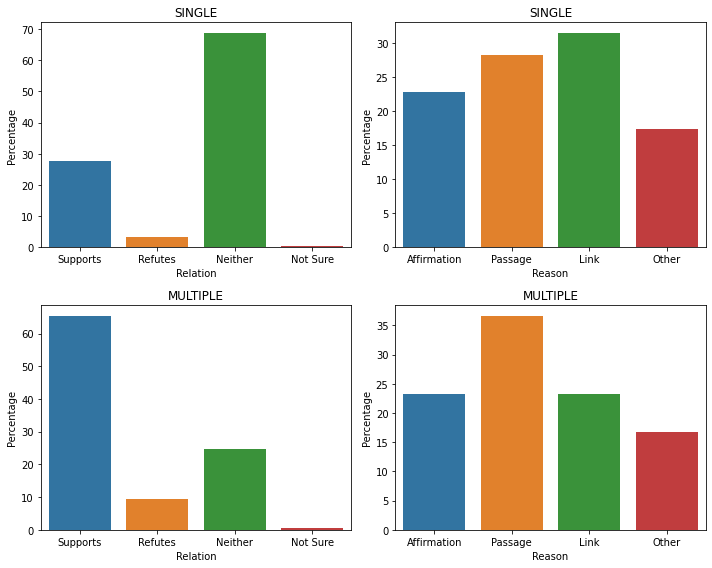

In [17]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

g = sns.barplot(
    data=results_single_df['relation']
        .value_counts(normalize=True)
        .mul(100)
        .reset_index(),
    x='index',
    y='relation',
    ax=ax[0][0]
)
g.set_xticklabels(RELATION_LABELS)
g.set_title('SINGLE')
g.set_xlabel('Relation')
g.set_ylabel('Percentage')

g = sns.barplot(
    data=results_single_df[
            results_single_df['reason_not_sure'] != -1
        ]['reason_not_sure']
        .value_counts(normalize=True).mul(100).reset_index(),
    x='index',
    y='reason_not_sure',
    ax=ax[0][1]
)
g.set_xticklabels(NOT_SURE_LABELS)
g.set_title('SINGLE')
g.set_xlabel('Reason')
g.set_ylabel('Percentage')

g = sns.barplot(
    data=results_multiple_df['relation']
        .value_counts(normalize=True)
        .mul(100)
        .reset_index(),
    x='index',
    y='relation',
    ax=ax[1][0]
)
g.set_xticklabels(RELATION_LABELS)
g.set_title('MULTIPLE')
g.set_xlabel('Relation')
g.set_ylabel('Percentage')

g = sns.barplot(
    data=pd.merge(
            pd.DataFrame([0,1,2,3], columns=['index']),
            results_multiple_df[results_multiple_df['reason_not_sure'] != -1]['reason_not_sure']
                .value_counts(normalize=True).mul(100).reset_index(),
            how='outer'
        ).fillna(0),
    x='index',
    y='reason_not_sure',
    ax=ax[1][1]
)
g.set_xticklabels(NOT_SURE_LABELS)
g.set_title('MULTIPLE')
g.set_xlabel('Reason')
g.set_ylabel('Percentage')

plt.tight_layout()

## Distribution of individual annotations by worker

In [18]:
print('-'*10,'single','-'*10)
print(f'{results_single_df.worker_id.unique().shape[0]} unique workers')
print(f'{results_single_df.shape[0]//6} unique assignments')
print(f'{results_single_df.shape[0]//6/results_single_df.worker_id.unique().shape[0]} assignments/worker')

print('-'*10,'multiple','-'*10)
print(f'{results_multiple_df.worker_id.unique().shape[0]} unique workers')
print(f'{results_multiple_df.shape[0]//6} unique assignments')
print(f'{results_multiple_df.shape[0]//6/results_multiple_df.worker_id.unique().shape[0]} assignments/worker')

---------- single ----------
199 unique workers
2500 unique assignments
12.56281407035176 assignments/worker
---------- multiple ----------
143 unique workers
455 unique assignments
3.1818181818181817 assignments/worker


Text(0.5, 1.0, 'MULTIPLE')

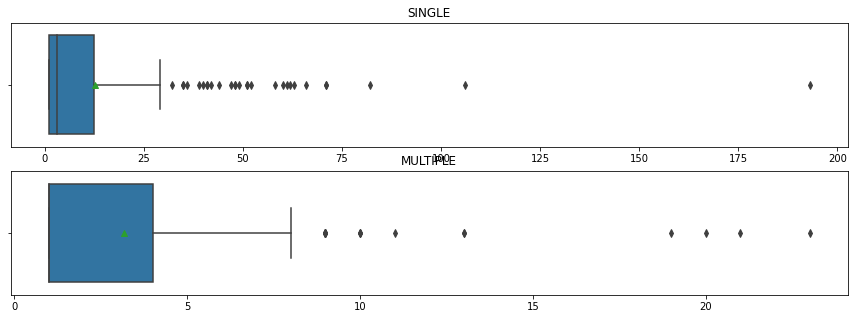

In [19]:
fig, ax = plt.subplots(2,1,figsize=(15,5))

g = sns.boxplot(
    x=results_single_df.groupby('worker_id').size()//6,
    orient='h',
    ax=ax[0],
    showmeans=True
)# Half of the people did only 1, and some people did more. A person did 12 out of the 23.
g.set_title('SINGLE')

g = sns.boxplot(
    x=results_multiple_df.groupby('worker_id').size()//6,
    orient='h',
    ax=ax[1],
    showmeans=True
) #Everyone did 1 task except a person who did 2
g.set_title('MULTIPLE')

In [20]:
worker_response_breakdown_relation_single =\
    results_single_df.groupby('worker_id')['relation'].apply(list).reset_index()

for i in range(0,4):
    worker_response_breakdown_relation_single[f'{RELATION_LABELS[i]}'] = worker_response_breakdown_relation_single['relation'].map(
        lambda x : sum([xx == i for xx in x])/len(x)
    )

worker_response_breakdown_relation_single.drop('relation', axis=1, inplace=True)

worker_response_breakdown_relation_multiple =\
    results_multiple_df.groupby('worker_id')['relation'].apply(list).reset_index()

for i in range(0,4):
    worker_response_breakdown_relation_multiple[f'{RELATION_LABELS[i]}'] = worker_response_breakdown_relation_multiple['relation'].map(
        lambda x : sum([xx == i for xx in x])/len(x)
    )

worker_response_breakdown_relation_multiple.drop('relation', axis=1, inplace=True)

<AxesSubplot:>

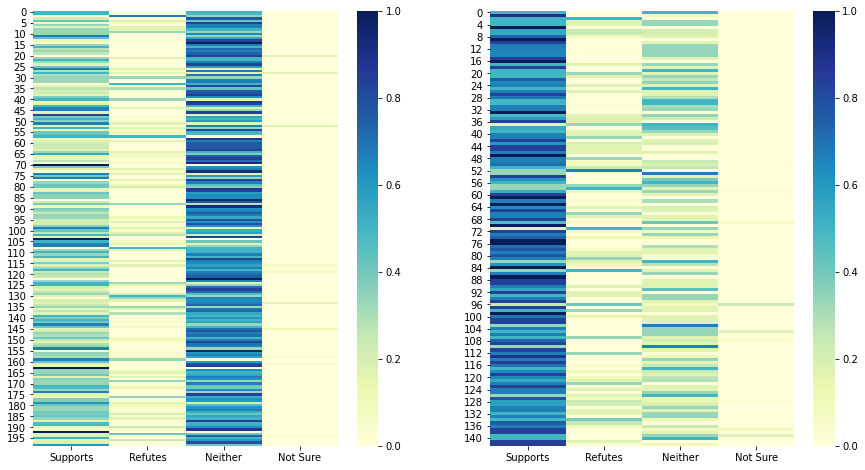

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.heatmap(
    worker_response_breakdown_relation_single.iloc[:,1:],
    ax=ax[0],
    vmin=0, vmax=1, cmap="YlGnBu"
)

sns.heatmap(
    worker_response_breakdown_relation_multiple.iloc[:,1:],
    ax=ax[1],
    vmin=0, vmax=1, cmap="YlGnBu"
)

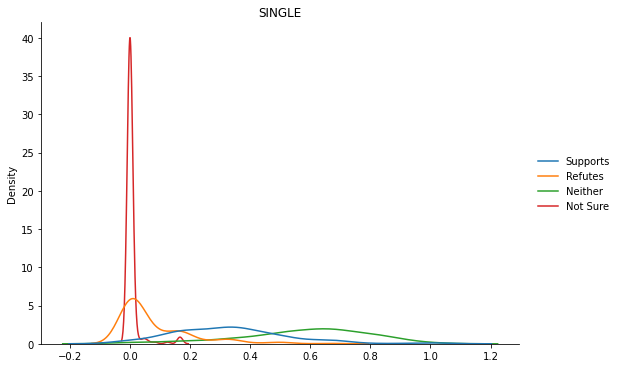

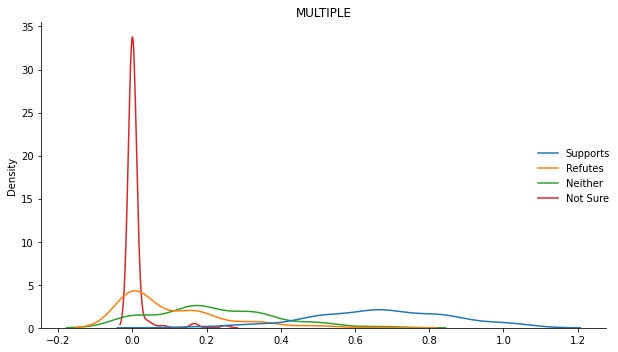

In [22]:
g=sns.displot(worker_response_breakdown_relation_single, kind='kde', height=5, aspect=1.5, common_norm=False)
g.set(title='SINGLE')

g=sns.displot(worker_response_breakdown_relation_multiple, kind='kde', height=5, aspect=1.5, common_norm=False)
g.set(title='MULTIPLE')
plt.tight_layout()

## Distribution of individual annotations by reference

In [23]:
reference_response_breakdown_relation_single =\
    results_single_df.groupby(['reference_id','evidence_id'])['relation'].apply(list).reset_index()

for i in range(0,4):
    reference_response_breakdown_relation_single[f'{RELATION_LABELS[i]}'] =\
        reference_response_breakdown_relation_single['relation'].map(
            lambda x : sum([xx == i for xx in x])/len(x)
        )

reference_response_breakdown_relation_single.drop(['evidence_id','relation'], axis=1, inplace=True)

reference_response_breakdown_relation_multiple =\
    results_multiple_df.groupby('reference_id')['relation'].apply(list).reset_index()

for i in range(0,4):
    reference_response_breakdown_relation_multiple[f'{RELATION_LABELS[i]}'] =\
        reference_response_breakdown_relation_multiple['relation'].map(
            lambda x : sum([xx == i for xx in x])/len(x)
        )

reference_response_breakdown_relation_multiple.drop('relation', axis=1, inplace=True)

<AxesSubplot:>

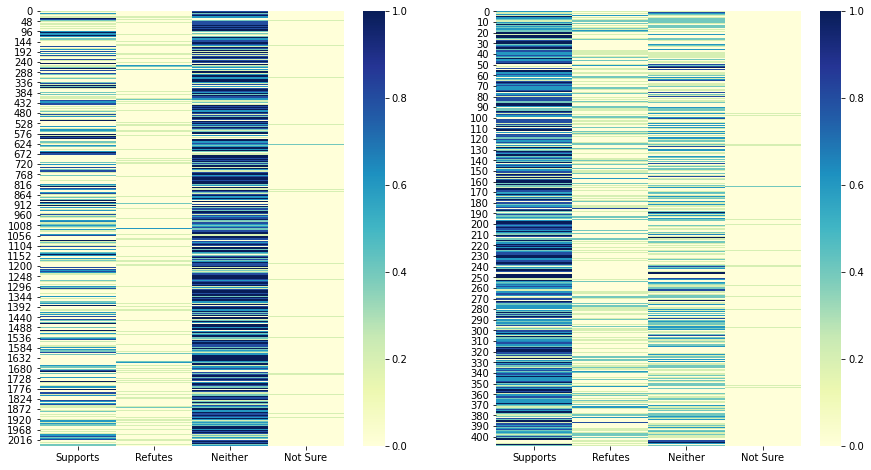

In [24]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.heatmap(
    reference_response_breakdown_relation_single.iloc[:,1:],
    ax=ax[0],
    vmin=0, vmax=1, cmap="YlGnBu"
)

sns.heatmap(
    reference_response_breakdown_relation_multiple.iloc[:,1:],
    ax=ax[1],
    vmin=0, vmax=1, cmap="YlGnBu"
)

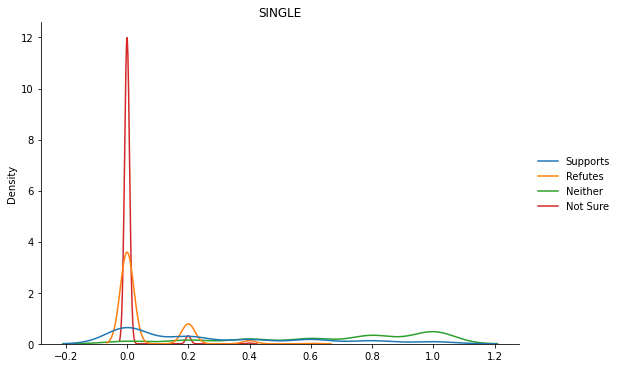

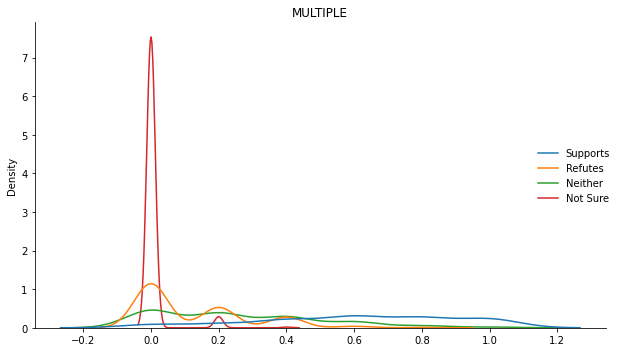

In [25]:
g=sns.displot(reference_response_breakdown_relation_single, kind='kde', height=5, aspect=1.5)
g.set(title='SINGLE')

g=sns.displot(reference_response_breakdown_relation_multiple, kind='kde', height=5, aspect=1.5)
g.set(title='MULTIPLE')
plt.tight_layout()

## Check relation between  non-aggregated scores and model outputs

In [26]:
# Get scored datasets (filtered for crowdsourcing from GenerateTaskSets)
te_df = pd.read_json('../data/textual_entailment_df_filtered_for_crowdsourcing.json')
# This dataset has scores for references and scores for individual evidence too
# it also has labels for references and labels for individual evidence
te_df.head()

,reference_id,claim_id,final_verbalisation,sampling_weight,final_url,netloc_agg,nlp_sentences,nlp_sentences_slide_2,nlp_sentences_scores,nlp_sentences_slide_2_scores,nlp_sentences_all_TOP_N,evidence_TE_prob_all_TOP_N,evidence_TE_prob_weighted_all_TOP_N,evidence_TE_labels_all_TOP_N,claim_TE_prob_weighted_sum_all_TOP_N,claim_TE_label_weighted_sum_all_TOP_N,claim_TE_label_malon_all_TOP_N
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,G V Raja died in Kullu Valley.,24749.538462,https://en.wikipedia.org/w/index.php?title=G._...,en.wikipedia.org,"[G. V. Raja., From Wikipedia, the free encyclo...","[G. V. Raja. From Wikipedia, the free encyclop...","[-0.9059305191, -0.9998914599000001, -0.999842...","[-0.9975231290000001, -0.9998638630000001, -0....",[{'sentence': 'He died in an air crash near Ku...,"[[0.9708649516000001, 0.0061447304, 0.02299031...","[[0.9707732797, 0.0061441502, 0.0229881462], [...","[SUPPORTS, SUPPORTS, NOT ENOUGH INFO, NOT ENOU...","[1.9523134232000001, 0.0484717116, 2.5008661747]",NOT ENOUGH INFO,SUPPORTS
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,Sebastian Sabol's religion is the Greek cathol...,24749.538462,https://en.wikipedia.org/w/index.php?title=Seb...,en.wikipedia.org,"[Sebastian Sabol., From Wikipedia, the free en...","[Sebastian Sabol. From Wikipedia, the free enc...","[-0.9904284477, -0.9997430444000001, -0.999761...","[-0.9976871014, -0.9997031689, -0.999774158, -...","[{'sentence': 'Sebastian Stepan Sabol, O.S.B.M...","[[0.09385417400000001, 0.2980020344, 0.6081437...","[[0.0830457285, 0.2636834979, 0.5381085873], [...","[NOT ENOUGH INFO, NOT ENOUGH INFO, NOT ENOUGH ...","[0.1000050157, 0.4289829731, 0.8527254462]",NOT ENOUGH INFO,SUPPORTS
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,The average white band started in 1972.,24749.538462,https://en.wikipedia.org/w/index.php?title=Ave...,en.wikipedia.org,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ...","[-0.9852669835000001, -0.9997751117, -0.999563...","[-0.9655147195, -0.9992546439000001, -0.999627...",[{'sentence': 'AWB was formed in early 1972 in...,"[[0.9388607144000001, 0.0051775482, 0.05596167...","[[0.9337435365000001, 0.0051493281, 0.05565666...","[SUPPORTS, REFUTES, NOT ENOUGH INFO, NOT ENOUG...","[0.964186728, 0.8969765306, 0.25956323740000004]",SUPPORTS,SUPPORTS
3,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,Yutaka Higuchi began work in 1983.,24749.538462,https://en.wikipedia.org/w/index.php?title=Yut...,en.wikipedia.org,"[Yutaka Higuchi (musician) From Wikipedia, the...","[Yutaka Higuchi (musician) From Wikipedia, the...","[-0.9987268448000001, -0.9997874498, -0.999821...","[-0.9918303490000001, -0.9996852875000001, -0....","[{'sentence': 'Yutaka Higuchi (桶口 豊, Higuchi Y...","[[0.7398596406, 0.0883401632, 0.17180021110000...","[[0.7397438288, 0.088326335, 0.1717733145], [0...","[SUPPORTS, NOT ENOUGH INFO, REFUTES, NOT ENOUG...","[0.7442157269, 0.3141435385, 0.5475053787]",SUPPORTS,SUPPORTS
4,1ee71b39caf6df395c64b436fea4895692812d38,Q5289513$B0532490-8FEC-4744-9D74-61238B633898,Dolores Delirio started work in 1994.,24749.538462,https://en.wikipedia.org/w/index.php?title=Dol...,en.wikipedia.org,"[Dolores Delirio., From Wikipedia, the free en...","[Dolores Delirio. From Wikipedia, the free enc...","[-0.49935883280000004, -0.9997779727, -0.99969...","[-0.9781491756, -0.9995777011, -0.9996224642, ...",[{'sentence': 'Dolores Delirio is a Peruvian r...,"[[0.7100448608000001, 0.0457550883, 0.24419999...","[[0.7099757195, 0.0457506366, 0.24417622390000...","[SUPPORTS, NOT ENOUGH INFO, NOT ENOUGH INFO, N...","[0.7102969885, 0.0495032594, 0.2685163021]",SUPPORTS,SUPPORTS


### Single evidence annot. VS. sentence retrieval relevance scores

In [27]:
# The pilot_results_single_df dataframe already has evidence-level scores, so we wont need to join from te_df
# we will need to join later for evidence-level textual entailment classification
results_single_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   claim_id               15000 non-null  object 
 1   affirmation            15000 non-null  object 
 2   reference_id           15000 non-null  object 
 3   reference_url          15000 non-null  object 
 4   evidence_id            15000 non-null  int64  
 5   sentence_id            15000 non-null  object 
 6   evidence               15000 non-null  object 
 7   score                  15000 non-null  float64
 8   worker_id              15000 non-null  object 
 9   assignment_id          15000 non-null  object 
 10  relation               15000 non-null  int64  
 11  reason_not_sure        15000 non-null  int64  
 12  reason_not_sure_other  15000 non-null  object 
 13  times                  15000 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 1.6+ 

In [28]:
# Check evidence score against annotations from the "single" task 
results_single_df_scores = results_single_df[['reference_id', 'evidence_id', 'score', 'relation']].copy()

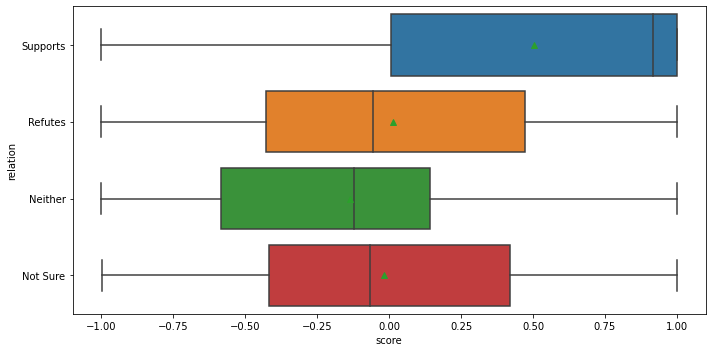

In [29]:
# Investigating sentence retrieval scores
fig, ax = plt.subplots(1, 1, figsize=(10,5))

g = sns.boxplot(
    data = results_single_df_scores,
    x = 'score',
    orient='h',
    y = 'relation', 
    ax=ax,
    showmeans=True
)
g.set_yticklabels(RELATION_LABELS)
plt.tight_layout()

In [30]:
results_single_df_scores.loc[:, 'relevant'] = results_single_df_scores['relation'].map(
    lambda x : 1 if x in [0,1] else (0 if x == 2 else -1)
)
results_single_df_scores[results_single_df_scores['relevant'] >= 0].corr()
#SCORE vs RELEVANT has a 0.415521 correlation

,evidence_id,score,relation,relevant
evidence_id,1.000000,-0.499359,0.337572,-0.326309
score,-0.499359,1.000000,-0.432519,0.415521
relation,0.337572,-0.432519,1.000000,-0.981345
relevant,-0.326309,0.415521,-0.981345,1.000000


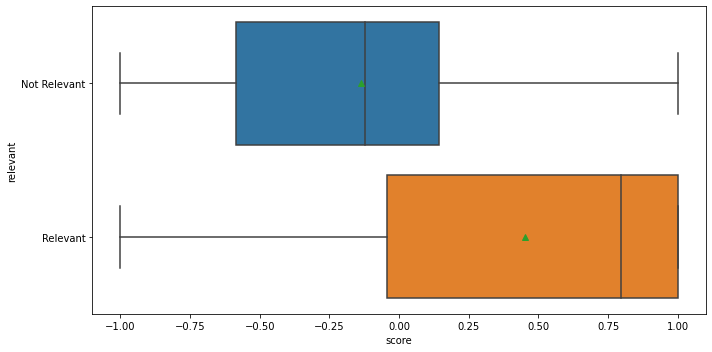

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

g = sns.boxplot(
    data = results_single_df_scores[results_single_df_scores['relevant'] >= 0],
    x = 'score',
    orient='h',
    y = 'relevant', 
    ax=ax,
    showmeans=True
)
g.set_yticklabels(['Not Relevant', 'Relevant'])
plt.tight_layout()

### Single evidence annot VS. textual entailment classifications

In [32]:
te_df_evidence_te_model_label = te_df[
    ['reference_id', 'evidence_TE_labels_all_TOP_N','evidence_TE_prob_all_TOP_N']
]
te_df_evidence_te_model_label = te_df_evidence_te_model_label.explode(
    ['evidence_TE_labels_all_TOP_N','evidence_TE_prob_all_TOP_N']
)
te_df_evidence_te_model_label['evidence_id'] = te_df_evidence_te_model_label.groupby('reference_id').cumcount()
te_df_evidence_te_model_label = te_df_evidence_te_model_label[
    ['reference_id', 'evidence_id', 'evidence_TE_labels_all_TOP_N', 'evidence_TE_prob_all_TOP_N']
].reset_index(drop=True)
te_df_evidence_te_model_label.rename({'evidence_TE_labels_all_TOP_N': 'TE_model_label'}, axis=1, inplace=True)
te_df_evidence_te_model_label[
    ['Supports_prob', 'Refutes_prob', 'Neither_prob']
] = pd.DataFrame(te_df_evidence_te_model_label['evidence_TE_prob_all_TOP_N'].to_list())
te_df_evidence_te_model_label.drop('evidence_TE_prob_all_TOP_N',axis=1,inplace=True)

te_labels = {'SUPPORTS':0, 'REFUTES':1, 'NOT ENOUGH INFO':2}

te_df_evidence_te_model_label['TE_model_label_num'] = te_df_evidence_te_model_label['TE_model_label'].map(te_labels)
te_df_evidence_te_model_label

,reference_id,evidence_id,TE_model_label,Supports_prob,Refutes_prob,Neither_prob,TE_model_label_num
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,0,SUPPORTS,0.970865,0.006145,0.022990,0
1,390d6c6e68a32e11f8d7b0883cda0557db529fe6,1,SUPPORTS,0.916387,0.004485,0.079128,0
2,390d6c6e68a32e11f8d7b0883cda0557db529fe6,2,NOT ENOUGH INFO,0.060523,0.021895,0.917582,2
3,390d6c6e68a32e11f8d7b0883cda0557db529fe6,3,NOT ENOUGH INFO,0.003394,0.008664,0.987942,2
4,390d6c6e68a32e11f8d7b0883cda0557db529fe6,4,NOT ENOUGH INFO,0.004058,0.013481,0.982461,2
...,...,...,...,...,...,...,...
2040,6e6204011de4f4176362a6f4067486a94fc6ac3e,0,NOT ENOUGH INFO,0.101774,0.009051,0.889175,2
2041,6e6204011de4f4176362a6f4067486a94fc6ac3e,1,NOT ENOUGH INFO,0.031923,0.008071,0.960006,2
2042,6e6204011de4f4176362a6f4067486a94fc6ac3e,2,NOT ENOUGH INFO,0.026303,0.006921,0.966776,2
2043,6e6204011de4f4176362a6f4067486a94fc6ac3e,3,NOT ENOUGH INFO,0.025316,0.008242,0.966442,2


In [33]:
results_single_df_te_labels = results_single_df[['reference_id', 'evidence_id', 'relation','score']]
results_single_df_te_labels = pd.merge(
    results_single_df_te_labels,
    te_df_evidence_te_model_label,
    on=['reference_id', 'evidence_id'],
    how='left'
)
results_single_df_te_labels

,reference_id,evidence_id,relation,score,TE_model_label,Supports_prob,Refutes_prob,Neither_prob,TE_model_label_num
0,5585dca2dcee1370bb7966f8387d926d6e58ed8d,4,2,0.154138,REFUTES,0.289753,0.565528,0.144719,1
1,0ad5794411e04d953f8ee4d88d7b872caa26e3e1,0,0,0.999884,REFUTES,0.133620,0.532041,0.334339,1
2,5bc0f775565a29c227394e2f1888dda61f8efa1e,2,2,-0.336305,REFUTES,0.018088,0.968598,0.013314,1
3,410bd8658602cc859be22d5165ffd3ded97c9d82,2,2,0.094723,NOT ENOUGH INFO,0.122886,0.056710,0.820404,2
4,d1a974eaba1f3b32f7ebc2459c7cbf46e2f5aa92,1,2,-0.625580,SUPPORTS,0.929305,0.049163,0.021532,0
...,...,...,...,...,...,...,...,...,...
14995,c9681f0c0f7d97dc983f2b6ce325f2adc598f43c,2,2,-0.993862,NOT ENOUGH INFO,0.008039,0.160836,0.831125,2
14996,16e1d8bbc347e2506ac55ef4105c7922a81015ba,4,2,-0.858519,NOT ENOUGH INFO,0.005726,0.096666,0.897608,2
14997,c807e80b2eff7c941c8062ab61a97632745a3fb8,1,2,0.114012,NOT ENOUGH INFO,0.096055,0.077630,0.826315,2
14998,539444c623cf37705a6a0b0260796497c16ba5f1,0,0,0.994451,SUPPORTS,0.639883,0.059770,0.300347,0


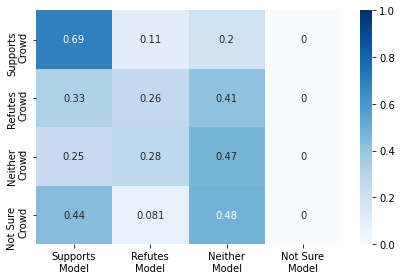

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(
    y_pred = results_single_df_te_labels['TE_model_label_num'],
    y_true = results_single_df_te_labels['relation'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS])
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS])
plt.tight_layout()

In [35]:
from sklearn.metrics import classification_report
cr = classification_report(
    y_pred = results_single_df_te_labels['TE_model_label_num'],
    y_true = results_single_df_te_labels['relation']
)
print(cr)

              precision    recall  f1-score   support

           0       0.51      0.69      0.59      4137
           1       0.04      0.26      0.07       492
           2       0.82      0.47      0.60     10309
           3       0.00      0.00      0.00        62

    accuracy                           0.52     15000
   macro avg       0.34      0.36      0.31     15000
weighted avg       0.71      0.52      0.58     15000



C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(
    y_pred = results_single_df_te_labels['TE_model_label_num'],
    y_true = results_single_df_te_labels['relation'],
)

cm = pd.DataFrame(cm)
cm.index = [x+' Crowd' for x in RELATION_LABELS]
cm.columns = [x+' Model' for x in RELATION_LABELS]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supports Model,Refutes Model,Neither Model,Not Sure Model,Total
Supports Crowd,2871,444,822,0,4137
Refutes Crowd,160,129,203,0,492
Neither Crowd,2592,2857,4860,0,10309
Not Sure Crowd,27,5,30,0,62
Total,5650,3435,5915,0,15000


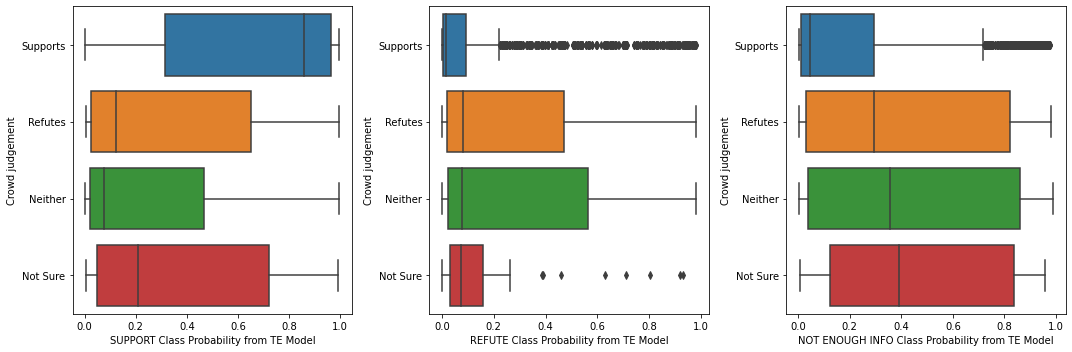

In [37]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

results_single_df_te_labels['relation_label'] = results_single_df_te_labels['relation']\
    .map({i: x for i, x in enumerate(RELATION_LABELS)})

g = sns.boxplot(
    data=results_single_df_te_labels,
    x='Supports_prob',
    y='relation_label',
    order = ['Supports', 'Refutes', 'Neither', 'Not Sure'],
    ax=ax[0]
)
g.set(xlabel='SUPPORT Class Probability from TE Model',ylabel='Crowd judgement')

g = sns.boxplot(
    data=results_single_df_te_labels,
    x='Refutes_prob',
    y='relation_label',
    order = ['Supports', 'Refutes', 'Neither', 'Not Sure'],
    ax=ax[1], 
)
g.set(xlabel='REFUTE Class Probability from TE Model',ylabel='Crowd judgement')

g = sns.boxplot(
    data=results_single_df_te_labels,
    x='Neither_prob',
    y='relation_label',
    order = ['Supports', 'Refutes', 'Neither', 'Not Sure'],
    ax=ax[2], 
)
g.set(xlabel='NOT ENOUGH INFO Class Probability from TE Model',ylabel='Crowd judgement')

plt.tight_layout()

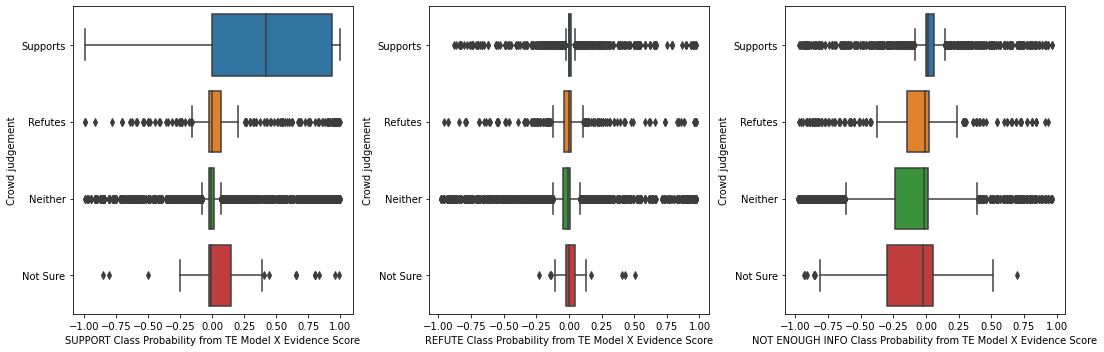

In [38]:
# Lastly, get the same as above but multiplying by scores
for r in ['Supports','Refutes','Neither']:
    results_single_df_te_labels[f'{r}_prob_times_ev_score'] =\
        results_single_df_te_labels[f'{r}_prob'] * results_single_df_te_labels['score']
results_single_df_te_labels

fig, ax = plt.subplots(1,3,figsize=(15,5))

results_single_df_te_labels['relation_label'] = results_single_df_te_labels['relation']\
    .map({i: x for i, x in enumerate(RELATION_LABELS)})

g = sns.boxplot(
    data=results_single_df_te_labels,
    x='Supports_prob_times_ev_score',
    y='relation_label',
    order = ['Supports', 'Refutes', 'Neither', 'Not Sure'],
    ax=ax[0], 
)
g.set(xlabel='SUPPORT Class Probability from TE Model X Evidence Score',ylabel='Crowd judgement')

g = sns.boxplot(
    data=results_single_df_te_labels,
    x='Refutes_prob_times_ev_score',
    y='relation_label',
    order = ['Supports', 'Refutes', 'Neither', 'Not Sure'],
    ax=ax[1], 
)
g.set(xlabel='REFUTE Class Probability from TE Model X Evidence Score',ylabel='Crowd judgement')

g = sns.boxplot(
    data=results_single_df_te_labels,
    x='Neither_prob_times_ev_score',
    y='relation_label',
    order = ['Supports', 'Refutes', 'Neither', 'Not Sure'],
    ax=ax[2], 
)
g.set(xlabel='NOT ENOUGH INFO Class Probability from TE Model X Evidence Score',ylabel='Crowd judgement')

plt.tight_layout()

#These charts are the probabilities multiplied by evidence score
# This is to see if, after accounting for relevance, we have:

# In the first chart (Support prob * relevance), a higher amount near the positive values for those voted "Supports"
# by the crowd. WE DO.

# In the second chart (Refute prob * relevance), a higher amount near the positive values for those voted "Refutes"
# by the crowd. WE DO, BUT BARELY, STILL SIMILAR TO NEITHER (although better than not multiplying by relevance)

# Third chart is very promissing, as it shows that there is a CLEAR difference between what the crowd has
# tagged as Neither and what the crowd as tagged as Refutes when one factors in the EVIDENCE SCORES
# on top of the TE class probabilities. This is promising in the case we want to use a final model predictor based
# on the collection of EV scores and TE probabilities for a given reference

### Multiple evidence annot. VS. aggregated (WM + MALON) textual entailment classifications

In [39]:
results_multiple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730 entries, 0 to 2729
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   claim_id               2730 non-null   object
 1   affirmation            2730 non-null   object
 2   reference_id           2730 non-null   object
 3   reference_url          2730 non-null   object
 4   evidence_list          2730 non-null   object
 5   worker_id              2730 non-null   object
 6   assignment_id          2730 non-null   object
 7   relation               2730 non-null   int64 
 8   reason_not_sure        2730 non-null   int64 
 9   reason_not_sure_other  2730 non-null   object
 10  times                  2730 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 234.7+ KB


In [40]:
te_labels = {'SUPPORTS':0, 'REFUTES':1, 'NOT ENOUGH INFO':2}
te_df_pre_join = te_df[
    ['reference_id','claim_id','claim_TE_prob_weighted_sum_all_TOP_N',
     'claim_TE_label_weighted_sum_all_TOP_N', 'claim_TE_label_malon_all_TOP_N']
].copy()
te_df_pre_join = te_df_pre_join.rename({
    'claim_TE_prob_weighted_sum_all_TOP_N': 'WS_TE_probs',
    'claim_TE_label_weighted_sum_all_TOP_N': 'WS_TE_label',
    'claim_TE_label_malon_all_TOP_N': 'MALON_TE_label'    
}, axis = 1)
te_df_pre_join['WS_TE_id'] = te_df_pre_join['WS_TE_label'].map(te_labels)
te_df_pre_join['MALON_TE_id'] = te_df_pre_join['MALON_TE_label'].map(te_labels)
te_df_pre_join

,reference_id,claim_id,WS_TE_probs,WS_TE_label,MALON_TE_label,WS_TE_id,MALON_TE_id
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,"[1.9523134232000001, 0.0484717116, 2.5008661747]",NOT ENOUGH INFO,SUPPORTS,2,0
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,"[0.1000050157, 0.4289829731, 0.8527254462]",NOT ENOUGH INFO,SUPPORTS,2,0
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,"[0.964186728, 0.8969765306, 0.25956323740000004]",SUPPORTS,SUPPORTS,0,0
3,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,"[0.7442157269, 0.3141435385, 0.5475053787]",SUPPORTS,SUPPORTS,0,0
4,1ee71b39caf6df395c64b436fea4895692812d38,Q5289513$B0532490-8FEC-4744-9D74-61238B633898,"[0.7102969885, 0.0495032594, 0.2685163021]",SUPPORTS,SUPPORTS,0,0
...,...,...,...,...,...,...,...
404,e004706cba4821386dc31a86faeb680e8fff4ae7,Q58480207$B8B66EE1-CD20-4426-846C-4B37DC5A55A4,"[0, 0, 0]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2
405,c714ca621d1fe1ca35f20e01a72587d23bdd8e1e,Q58485125$0B087946-63A0-4D69-BAEA-AD52DFBE2C6F,"[0.0111095207, 0.0077722026, 0.1802416742]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2
406,52968f905e88f2484e3cb43e6ab4e76f120bc3c3,Q58485081$AF144153-1EF3-4494-BBCC-90742E594482,"[0.0642338172, 0.0029714017, 0.1621499956]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2
407,8bb93e520f7ca8208f24078434b8f5f2ba8b520b,Q58484448$9611AF89-1BD2-4D49-9CBB-E3EC52C7765D,"[0.1575524956, 0.0082641244, 0.7491290569]",NOT ENOUGH INFO,SUPPORTS,2,0


In [41]:
results_multiple_df_scores = pd.merge(
    results_multiple_df,
    te_df_pre_join,
    on=['reference_id', 'claim_id'],
    how='left'
)[['reference_id', 'relation', 'WS_TE_probs', 'WS_TE_label', 'MALON_TE_label', 'WS_TE_id', 'MALON_TE_id']]

In [42]:
results_multiple_df_scores.head()

,reference_id,relation,WS_TE_probs,WS_TE_label,MALON_TE_label,WS_TE_id,MALON_TE_id
0,5b14a71742a09446d03a95c9426a659cda3bad6f,0,"[0.9960011244, 0.0014165407, 0.0024456519]",SUPPORTS,SUPPORTS,0,0
1,15bea5900b8dda1bcf6f622348d80ef5a5b7b71e,1,"[0.5644102097, 0.3127562404, 0.0403452292]",SUPPORTS,SUPPORTS,0,0
2,74188de4f031ca41e7927959f818816dbdfc29af,0,"[3.7863833904, 0.0230747759, 0.2821960747]",SUPPORTS,SUPPORTS,0,0
3,11513fdd381730dfa38bf9fb5a724a129dc8480c,2,"[2.4173943996, 0.025141583800000002, 0.2366851...",SUPPORTS,SUPPORTS,0,0
4,99415d84e2b5632a86eaa925c4f7ae791816621e,0,"[0, 0, 0]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2


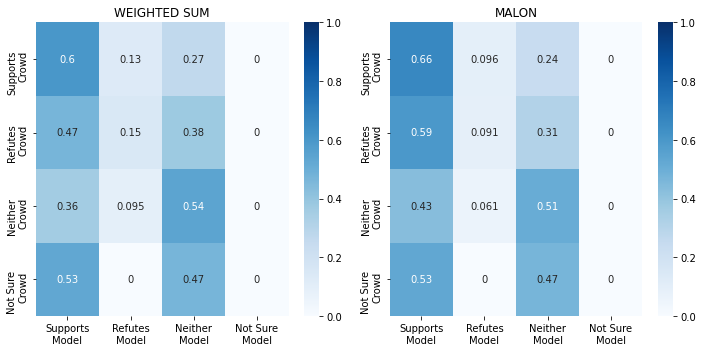

In [43]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1,2,figsize=(10,5))
cm = confusion_matrix(
    y_pred = results_multiple_df_scores['WS_TE_id'],
    y_true = results_multiple_df_scores['relation'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax = ax[0], vmin=0, vmax=1)
g.set_title('WEIGHTED SUM')
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS])
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS])

cm = confusion_matrix(
    y_pred = results_multiple_df_scores['MALON_TE_id'],
    y_true = results_multiple_df_scores['relation'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax[1], vmin=0, vmax=1)
g.set_title('MALON')
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS])
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS])

plt.tight_layout()

In [44]:
from sklearn.metrics import classification_report
cr = classification_report(
    y_pred = results_multiple_df_scores['WS_TE_id'],
    y_true = results_multiple_df_scores['relation'],
    zero_division=0
)
print(cr)

cr = classification_report(
    y_pred = results_multiple_df_scores['MALON_TE_id'],
    y_true = results_multiple_df_scores['relation'],
    zero_division=0
)
print(cr)

              precision    recall  f1-score   support

           0       0.74      0.60      0.67      1787
           1       0.11      0.15      0.13       254
           2       0.39      0.54      0.45       672
           3       0.00      0.00      0.00        17

    accuracy                           0.54      2730
   macro avg       0.31      0.32      0.31      2730
weighted avg       0.59      0.54      0.56      2730

              precision    recall  f1-score   support

           0       0.73      0.66      0.69      1787
           1       0.10      0.09      0.09       254
           2       0.40      0.51      0.45       672
           3       0.00      0.00      0.00        17

    accuracy                           0.57      2730
   macro avg       0.31      0.32      0.31      2730
weighted avg       0.58      0.57      0.57      2730



In [45]:
cm = confusion_matrix(
    y_pred = results_multiple_df_scores['WS_TE_id'],
    y_true = results_multiple_df_scores['relation']
)

cm = pd.DataFrame(cm)
cm.columns = [x+' Model' for x in RELATION_LABELS]
cm.index = [x+' Crowd' for x in RELATION_LABELS]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supports Model,Refutes Model,Neither Model,Not Sure Model,Total
Supports Crowd,1078,233,476,0,1787
Refutes Crowd,120,38,96,0,254
Neither Crowd,243,64,365,0,672
Not Sure Crowd,9,0,8,0,17
Total,1450,335,945,0,2730


In [46]:
cm = confusion_matrix(
    y_pred = results_multiple_df_scores['MALON_TE_id'],
    y_true = results_multiple_df_scores['relation']
)

cm = pd.DataFrame(cm)
cm.columns = [x+' Model' for x in RELATION_LABELS]
cm.index = [x+' Crowd' for x in RELATION_LABELS]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supports Model,Refutes Model,Neither Model,Not Sure Model,Total
Supports Crowd,1186,171,430,0,1787
Refutes Crowd,151,23,80,0,254
Neither Crowd,289,41,342,0,672
Not Sure Crowd,9,0,8,0,17
Total,1635,235,860,0,2730


## Agreement

In [47]:
def prep_for_kripp(df, id_col, resp_col, fun=np.median, fillna = None):
    '''
    WE TAKE THE MIN HERE, UNDER THE PREMISE THAT IF A WORKER SAW THE SAME SENTENCE TWICE AND GAVE IT TWO SCORES,
    THE LESSER SCORE WOULD REFLECT DIFFICULTIES THE WORKER HAD THAT MIGHT NOT HAVE BEEN ON THEIR MIND DURING THE
    GREATER SCORE ASSIGNMENT, BUT THAT ARE REAL NONETHELESS AND MUST BE REPORTED
    '''
    df = df.copy()
    df = df[['worker_id',id_col, resp_col]]\
        .groupby(['worker_id',id_col]).agg(fun).reset_index()
    df = df.pivot(index='worker_id',columns=id_col,values=resp_col)
    if fillna:
        df = df.fillna('*')
    return df

def prep_for_fleiss(df, id_col, resp_col):
    df = df.copy()    
    df = df[[id_col,resp_col]]
    df['count'] = 1
    df = df.groupby([id_col,resp_col]).sum().reset_index()
    df = df.pivot(index=id_col, columns=resp_col, values='count').fillna(0)
    df = df[df.apply(lambda x : sum(x) == 5.0, axis=1)]
    return df

In [48]:
df = pd.DataFrame({
  "a": [5,   5,    5,    5,    5],
  "b": [5,   5,    4,    5,    4],
  "c": ['*', 5,   '*', '*',    5],
  "d": [5,   5,    3,    5,  '*'],
  "e": [5, '*',    5,    4,    5],
  "f": [5,   3,    5,    4,    5],
}).T
ka.krippendorff_alpha(df.values, ka.interval_metric, missing_items='*')

# WHILE DISTRIBUTIONS LIKE THE ONE ABOVE SCORE VERY LOW, FLIPPING 3s AND 5s IN THE SECOND COLUMN, WHICH
# SHOULD NOT CHANGE AGREEMENT, ACTUALLY INCREASES IT A LOT (0.37)
# AND CHANGING IT TO [1,2,3,4,*,5] WHICH SHOULD DECREASE AGREEMENT ACTUALLY INCREASES IT TOO (to 0.34)

# THE ISSUE HERE, AFTER TALKING WITH EDDY, IS THE LACK OF ANNOTATION VARIABILITY. THERE IS NO INDICATION THAT PEOPLE
# CAN RATE ANYTHING OTHER THAN 5,4 AND 3, AND THE SPREAD SEEMS TO FAVOUR 5 SO THAT IT IS EXPECTED THAT THINGS WILL 
# MOSTLY BE A 5

-0.06779661016949157

In [49]:
import krippendorff_alpha as ka 
from statsmodels.stats.inter_rater import fleiss_kappa as fleiss

aggr_levels_relevancy = {}

aggr_levels_relevancy['single'] = {}

results_single_df['reference_evidence_id'] = results_single_df.apply(
    lambda row : row['reference_id'] + '$' + str(row['evidence_id']), axis=1
)

single_df_kripp = prep_for_kripp(
    results_single_df,
    id_col = 'reference_evidence_id',
    resp_col='relation',
    fillna='*'
)
single_df_fleiss = prep_for_fleiss(
    results_single_df,
    id_col = 'reference_evidence_id',
    resp_col='relation'
)

aggr_levels_relevancy['single']['kalpha'] = ka.krippendorff_alpha(
    single_df_kripp.values, ka.nominal_metric, missing_items='*'
)
aggr_levels_relevancy['single']['fkappa'] = fleiss(single_df_fleiss)
aggr_levels_relevancy['single']['rkappa'] = fleiss(single_df_fleiss, method = 'rand')


aggr_levels_relevancy['multiple'] = {}

multiple_df_kripp = prep_for_kripp(
    results_multiple_df,
    id_col = 'reference_id',
    resp_col='relation',
    fillna='*'
)
multiple_df_fleiss = prep_for_fleiss(
    results_multiple_df,
    id_col = 'reference_id',
    resp_col='relation'
)

aggr_levels_relevancy['multiple']['kalpha'] = ka.krippendorff_alpha(
    multiple_df_kripp.values, ka.nominal_metric, missing_items='*'
)
aggr_levels_relevancy['multiple']['fkappa'] = fleiss(multiple_df_fleiss)
aggr_levels_relevancy['multiple']['rkappa'] = fleiss(multiple_df_fleiss, method = 'rand')

aggr_metrics = pd.DataFrame(aggr_levels_relevancy)
aggr_metrics

,single,multiple
kalpha,0.397089,0.231016
fkappa,0.310491,0.122927
rkappa,0.564200,0.336996


RKappa values place agreement into fair-moderate brackets according to Landis & Koch

![Landis&Koch](https://www.researchgate.net/profile/William-Gallagher-6/publication/7074647/figure/tbl1/AS:669654062202881@1536669378842/Interpretation-of-Landis-and-Koch-kappa-values.png)

# Aggregated results

## Agg. Single evidence annot.

In [50]:
results_single_df_agg = results_single_df.copy()
results_single_df_agg = results_single_df_agg\
    .groupby(['reference_evidence_id']).agg(list)

for c in results_single_df_agg.columns:
    if c in ['worker_id','assignment_id','relation','reason_not_sure','reason_not_sure_others','time']:
        continue
    else:
        if results_single_df_agg[c].map(lambda x : pd.Series(x).unique().size == 1).all():
            results_single_df_agg[c] = results_single_df_agg[c]\
                .map(lambda x : pd.Series(x).unique()[0])
            
results_single_df_agg.head()

,claim_id,affirmation,reference_id,reference_url,evidence_id,sentence_id,evidence,score,worker_id,assignment_id,relation,reason_not_sure,reason_not_sure_other,times
reference_evidence_id,,,,,,,,,,,,,,
00d15820946d663523ad6ad9316fcc27ffe4a791$0,Q4750883$C5B95856-A961-4EA4-95F5-995B94509CC7,Anaheim Ice is located in Anaheim.,00d15820946d663523ad6ad9316fcc27ffe4a791,https://www.archinform.net/entry.htm?ID=bmkdbj...,0,11,"[Anaheim Ice, for­merly known as Disney Ice, i...",0.999882,"[A1KL6MRIHQFJND, A3BHKF9NJKCXPB, A3O0NNIW4KA2P...","[3KGTPGBS61XV701JAUOY0EDJ0STU2J, 386CSBG1O3YRX...","[0, 0, 0, 0, 1]","[-1, -1, -1, -1, -1]","[, , , , ]","[32987, 7022, 7298, 10080, 15916]"
00d15820946d663523ad6ad9316fcc27ffe4a791$1,Q4750883$C5B95856-A961-4EA4-95F5-995B94509CC7,Anaheim Ice is located in Anaheim.,00d15820946d663523ad6ad9316fcc27ffe4a791,https://www.archinform.net/entry.htm?ID=bmkdbj...,1,22,"[In late 2019, the Ducks re­lo­cated their pra...",0.536719,"[A1SSQSHIYUNDZ0, A9LXSGXZM4IJE, A12BUI6X0OB6SY...","[3HPZF4IVNQ5PMRDQHOATFCSI87HCY8, 3WS1NTTKE2OZS...","[2, 2, 2, 2, 2]","[-1, -1, -1, -1, -1]","[, , , , ]","[9818, 4381, 3047, 3960, 4949]"
00d15820946d663523ad6ad9316fcc27ffe4a791$2,Q4750883$C5B95856-A961-4EA4-95F5-995B94509CC7,Anaheim Ice is located in Anaheim.,00d15820946d663523ad6ad9316fcc27ffe4a791,https://www.archinform.net/entry.htm?ID=bmkdbj...,2,13;14,[It was the prac­tice and train­ing rink of th...,0.241545,"[A2R05XFXQLZEC0, A3O0NNIW4KA2PV, A2RKUDGK5PQ44...","[36NEMU28XJPY68UHFCMJXBCERDJWM9, 36TFCYNS48MR3...","[2, 2, 0, 2, 2]","[-1, -1, -1, -1, -1]","[, , , , ]","[32457, 12865, 15529, 3964, 13479]"
00d15820946d663523ad6ad9316fcc27ffe4a791$3,Q4750883$C5B95856-A961-4EA4-95F5-995B94509CC7,Anaheim Ice is located in Anaheim.,00d15820946d663523ad6ad9316fcc27ffe4a791,https://www.archinform.net/entry.htm?ID=bmkdbj...,3,20;21,[It opened in 1995. When the Ana­heim Ducks (t...,0.104416,"[A25SH3L1UR6Y1Z, A2OI65EUOJ0CBY, A2HUR35MRR4DY...","[3OHYZ19UGGHPZYCQRN547Q4SUUWAOS, 3X65QVEQI4Z5M...","[2, 2, 2, 2, 2]","[-1, -1, -1, -1, -1]","[, , , , ]","[8999, 6773, 15357, 9169, 4991]"
00d15820946d663523ad6ad9316fcc27ffe4a791$4,Q4750883$C5B95856-A961-4EA4-95F5-995B94509CC7,Anaheim Ice is located in Anaheim.,00d15820946d663523ad6ad9316fcc27ffe4a791,https://www.archinform.net/entry.htm?ID=bmkdbj...,4,25,"[De­spite later re­sum­ing op­er­a­tions, Ana­...",-0.126725,"[A7EP668Z0WF6G, A3LCGX74R6XR5I, A1PO4Z1B8661LE...","[3JJVG1YBEF98AYB0SM91TVO7VHD5BE, 320DUZ38GBYC8...","[0, 2, 2, 2, 2]","[-1, -1, -1, -1, -1]","[, , , , ]","[19809, 17110, 8458, 6651, 4168]"


Possible majority voting layouts:

The table lists the number of votes the #N-st voted choice received.\
E.g. the first row shows the case of an unanimous vote, the third shows a 60/40 split between two choices, etc.

There is a clear winner in cases 1-5:

|Case|\#1|\#2|\#3|\#4|
|----|---|---|---|---|
|*1*   |5  |0  |0  |0  |
|*2*   |4  |1  |0  |0  |
|*3*   |3  |1  |1  |0  |
|*4*   |3  |2  |0  |0  |
|*5*   |2  |1  |1  |1  |
|*6*   |2  |2  |1  |0  |

However in case 6, things get complicated as we have a tie.\
This depends on who is tying with who. Let's propose the following decision table for ties:


| |0|1|2|3|
|-|-|-|-|-|
|0| |2|0|0|
|1| | |1|1|
|2| | | |2|
|3| | | | |

Clarifications:\
0-1: Half of majority says supports, half says refutes, we assume conflicting evidence, take the middle ground and say 2 = Neither.\
0-2: Supporting is a stronger conclusion than neither, which might be due to misinterpretation, vagueness, or different subjective degrees of "enough proof".\
0-3: Any tie with "Not sure" will go to the other class, as "not sure" can not be relied upon.\
1-2: Same as 0-2.\
1-3: Same as 0-3.\
2-3: Same as 0-3.\

In [51]:
# Remember: 0=supports, 1=refutes, 2=neither, 3=notsure
def get_majority_relation(relations):
    relations = pd.Series(relations)
    relations_vc = relations.value_counts()
    
    majority_relation = -1
    tie = False
    
    if relations_vc.iloc[0] >= 3:
        # Cases 1-4
        majority_relation =  relations_vc.index[0]
        
    elif relations_vc.iloc[0] == 2:
        if relations_vc.iloc[1] == 1:
            # Case 5
            majority_relation =  relations_vc.index[0]
        else:
            # Case 6
            tie=True
            assert relations_vc.iloc[1] == 2
            # Implement tie table
            tie_1, tie_2 = relations_vc.index[0], relations_vc.index[1]
            if (tie_1, tie_2) in [(0,1), (1,0), (2,3), (3,2)]:
                majority_relation = 2
            elif (tie_1, tie_2) in [(0,2), (2,0), (0,3), (3,0)]:
                majority_relation = 0          
            elif (tie_1, tie_2) in [(1,2), (2,1), (1,3), (3,1)]:
                majority_relation = 1
            
    return majority_relation, tie

def get_majority_reason_not_sure(reasons):
    reasons = pd.Series(reasons)
    reasons_vc = reasons.value_counts()
    reasons_vc.drop(-1, inplace=True)
    if reasons_vc.size == 0:
        return -1
    return reasons_vc.index[0]

assert get_majority_relation([2,3,3,3,1]) == (3, False)
assert get_majority_relation([1, 1, 0, 0, 0]) == (0, False)
assert get_majority_relation([1, 1, 2, 2, 0]) == (1,True)


assert get_majority_reason_not_sure([-1, -1, -1, -1, -1]) == -1
assert get_majority_reason_not_sure([0, -1, -1, -1, -1]) == 0

In [52]:
relation_majs = results_single_df_agg['relation'].map(get_majority_relation)
results_single_df_agg['relation_maj'] = [x[0] for x in relation_majs]
results_single_df_agg['relation_maj_tie'] = [x[1] for x in relation_majs]
results_single_df_agg['reason_not_sure_maj'] = results_single_df_agg['reason_not_sure']\
    .map(get_majority_reason_not_sure)
results_single_df_agg = results_single_df_agg[
    ['reference_id','evidence_id','score','relation_maj','relation_maj_tie','reason_not_sure_maj']
].copy()
results_single_df_agg

,reference_id,evidence_id,score,relation_maj,relation_maj_tie,reason_not_sure_maj
reference_evidence_id,,,,,,
00d15820946d663523ad6ad9316fcc27ffe4a791$0,00d15820946d663523ad6ad9316fcc27ffe4a791,0,0.999882,0,False,-1
00d15820946d663523ad6ad9316fcc27ffe4a791$1,00d15820946d663523ad6ad9316fcc27ffe4a791,1,0.536719,2,False,-1
00d15820946d663523ad6ad9316fcc27ffe4a791$2,00d15820946d663523ad6ad9316fcc27ffe4a791,2,0.241545,2,False,-1
00d15820946d663523ad6ad9316fcc27ffe4a791$3,00d15820946d663523ad6ad9316fcc27ffe4a791,3,0.104416,2,False,-1
00d15820946d663523ad6ad9316fcc27ffe4a791$4,00d15820946d663523ad6ad9316fcc27ffe4a791,4,-0.126725,2,False,-1
...,...,...,...,...,...,...
fee28b055fe25d699a5092e83fdb146831cdefe1$0,fee28b055fe25d699a5092e83fdb146831cdefe1,0,0.958324,0,False,-1
fee28b055fe25d699a5092e83fdb146831cdefe1$1,fee28b055fe25d699a5092e83fdb146831cdefe1,1,0.843562,2,False,-1
fee28b055fe25d699a5092e83fdb146831cdefe1$2,fee28b055fe25d699a5092e83fdb146831cdefe1,2,0.181564,2,False,-1


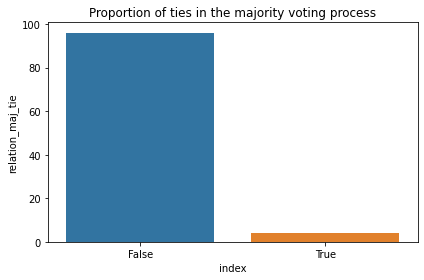

In [53]:
g = sns.barplot(
    data = results_single_df_agg
    .relation_maj_tie
    .value_counts(normalize=True)
    .mul(100)
    .reset_index(),    
    x='index',
    y='relation_maj_tie',
)
g.set_title('Proportion of ties in the majority voting process')
plt.tight_layout()

## Agg. Single evidence annot. VS.  Sentence Retrieval EV scores

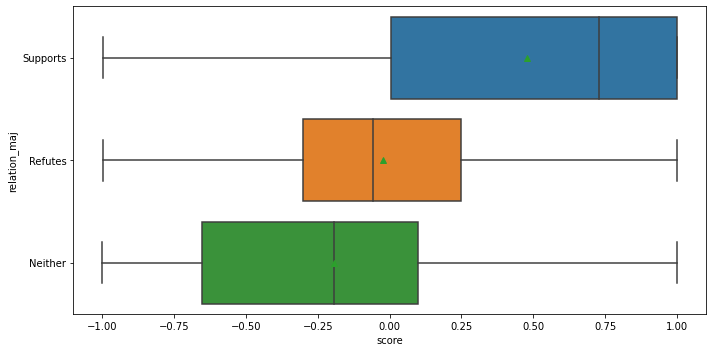

In [54]:
# Investigating sentence retrieval scores
fig, ax = plt.subplots(1, 1, figsize=(10,5))

g = sns.boxplot(
    data = results_single_df_agg,
    x = 'score',
    orient='h',
    y = 'relation_maj', 
    ax=ax,
    showmeans=True
)
g.set_yticklabels(RELATION_LABELS[:3])
plt.tight_layout()

In [55]:
results_single_df_agg.loc[:, 'relevant_maj'] = results_single_df_agg['relation_maj'].map(
    lambda x : 1 if x in [0,1] else (0 if x == 2 else -1)
)

results_single_df_agg[results_single_df_agg['relevant_maj'] >= 0].corr()
#SCORE vs RELEVANT has a 0.463540 correlation

,evidence_id,score,relation_maj,relation_maj_tie,reason_not_sure_maj,relevant_maj
evidence_id,1.000000,-0.500617,0.340003,-0.047586,-0.018770,-0.335009
score,-0.500617,1.000000,-0.469222,0.053616,0.009377,0.463540
relation_maj,0.340003,-0.469222,1.000000,-0.249797,-0.039258,-0.993891
relation_maj_tie,-0.047586,0.053616,-0.249797,1.000000,0.105534,0.282908
reason_not_sure_maj,-0.018770,0.009377,-0.039258,0.105534,1.000000,0.036659
relevant_maj,-0.335009,0.463540,-0.993891,0.282908,0.036659,1.000000


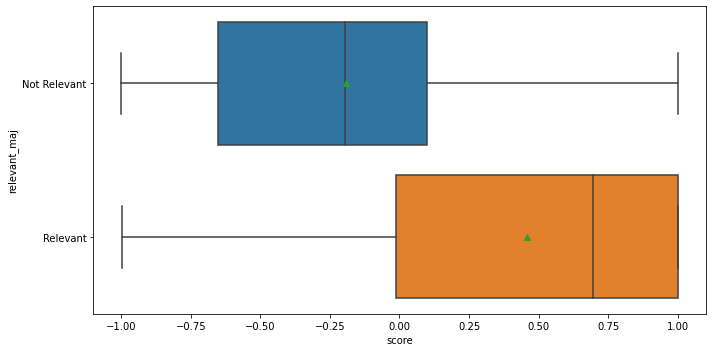

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

g = sns.boxplot(
    data = results_single_df_agg[results_single_df_agg['relevant_maj'] >= 0],
    x = 'score',
    orient='h',
    y = 'relevant_maj', 
    ax=ax,
    showmeans=True
)
g.set_yticklabels(['Not Relevant', 'Relevant'])
plt.tight_layout()

One way anova test:
F_onewayResult(statistic=559.1136803492492, pvalue=1.8333655907063352e-109)


PointbiserialrResult(correlation=0.46353969038927617, pvalue=1.833365590711751e-109)

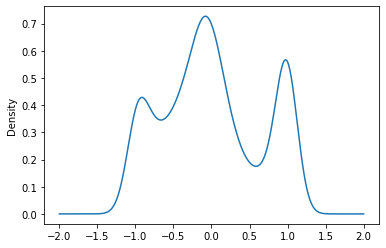

In [491]:
from scipy.stats import pointbiserialr, f_oneway

results_single_df_agg.score.plot.kde()

print('One way anova test:')
print(f_oneway(
    results_single_df_agg[results_single_df_agg['relevant_maj'] == 0].score,
    results_single_df_agg[results_single_df_agg['relevant_maj'] == 1].score
))

pointbiserialr(
    x = results_single_df_agg.relevant_maj.astype(bool),
    y = results_single_df_agg.score
)

## Agg. Single evidence annot. VS. TE label probs

### Argmax (trivial) + Distributions

In [57]:
results_single_df_agg_te_labels = pd.merge(
    results_single_df_agg,
    te_df_evidence_te_model_label,
    on=['reference_id', 'evidence_id'],
    how='left'
)
results_single_df_agg_te_labels

,reference_id,evidence_id,score,relation_maj,relation_maj_tie,reason_not_sure_maj,relevant_maj,TE_model_label,Supports_prob,Refutes_prob,Neither_prob,TE_model_label_num
0,00d15820946d663523ad6ad9316fcc27ffe4a791,0,0.999882,0,False,-1,1,SUPPORTS,0.994493,0.001133,0.004373,0
1,00d15820946d663523ad6ad9316fcc27ffe4a791,1,0.536719,2,False,-1,0,SUPPORTS,0.967906,0.002971,0.029123,0
2,00d15820946d663523ad6ad9316fcc27ffe4a791,2,0.241545,2,False,-1,0,SUPPORTS,0.985370,0.000905,0.013725,0
3,00d15820946d663523ad6ad9316fcc27ffe4a791,3,0.104416,2,False,-1,0,SUPPORTS,0.948274,0.002433,0.049293,0
4,00d15820946d663523ad6ad9316fcc27ffe4a791,4,-0.126725,2,False,-1,0,SUPPORTS,0.962176,0.002534,0.035290,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2040,fee28b055fe25d699a5092e83fdb146831cdefe1,0,0.958324,0,False,-1,1,NOT ENOUGH INFO,0.079671,0.045673,0.874655,2
2041,fee28b055fe25d699a5092e83fdb146831cdefe1,1,0.843562,2,False,-1,0,NOT ENOUGH INFO,0.023604,0.036812,0.939584,2
2042,fee28b055fe25d699a5092e83fdb146831cdefe1,2,0.181564,2,False,-1,0,NOT ENOUGH INFO,0.430545,0.018184,0.551271,2
2043,fee28b055fe25d699a5092e83fdb146831cdefe1,3,0.123930,2,False,-1,0,NOT ENOUGH INFO,0.038369,0.023471,0.938160,2


              precision    recall  f1-score   support

           0       0.56      0.72      0.63       583
           1       0.01      0.29      0.02        21
           2       0.86      0.49      0.63      1441

    accuracy                           0.56      2045
   macro avg       0.48      0.50      0.43      2045
weighted avg       0.77      0.56      0.62      2045



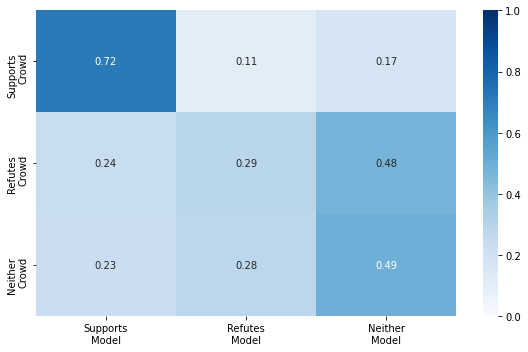

In [58]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = results_single_df_agg_te_labels['TE_model_label_num'],
    y_true = results_single_df_agg_te_labels['relation_maj'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

plt.tight_layout()

from sklearn.metrics import classification_report
cr = classification_report(
    y_pred = results_single_df_agg_te_labels['TE_model_label_num'],
    y_true = results_single_df_agg_te_labels['relation_maj']
)
print(cr)

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(
    y_pred = results_single_df_agg_te_labels['TE_model_label_num'],
    y_true = results_single_df_agg_te_labels['relation_maj']
)

cm = pd.DataFrame(cm)
cm.columns = [x+' Model' for x in RELATION_LABELS[:3]]
cm.index = [x+' Crowd' for x in RELATION_LABELS[:3]]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supports Model,Refutes Model,Neither Model,Total
Supports Crowd,419,62,102,583
Refutes Crowd,5,6,10,21
Neither Crowd,325,406,710,1441
Total,749,474,822,2045


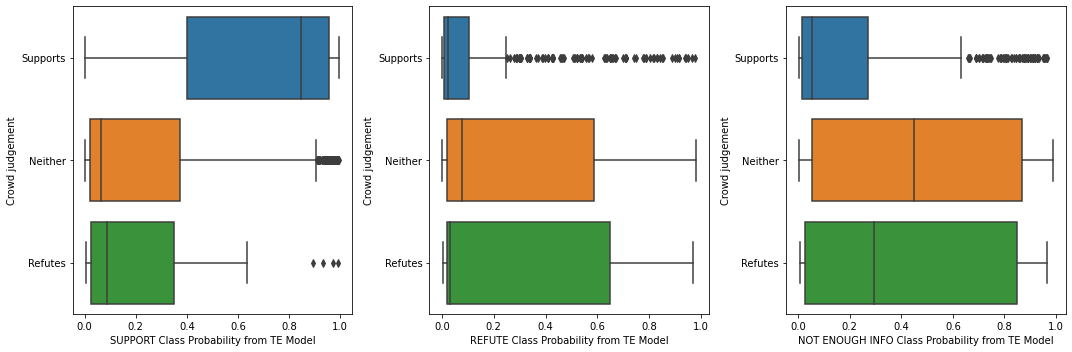

In [60]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

results_single_df_agg_te_labels['relation_maj_label'] = results_single_df_agg_te_labels['relation_maj']\
    .map({i: x for i, x in enumerate(RELATION_LABELS)})

g = sns.boxplot(
    data=results_single_df_agg_te_labels,
    x='Supports_prob',
    y='relation_maj_label',
    ax=ax[0]
)
g.set(xlabel='SUPPORT Class Probability from TE Model',ylabel='Crowd judgement')

g = sns.boxplot(
    data=results_single_df_agg_te_labels,
    x='Refutes_prob',
    y='relation_maj_label',
    ax=ax[1], 
)
g.set(xlabel='REFUTE Class Probability from TE Model',ylabel='Crowd judgement')

g = sns.boxplot(
    data=results_single_df_agg_te_labels,
    x='Neither_prob',
    y='relation_maj_label',
    ax=ax[2], 
)
g.set(xlabel='NOT ENOUGH INFO Class Probability from TE Model',ylabel='Crowd judgement')

plt.tight_layout()

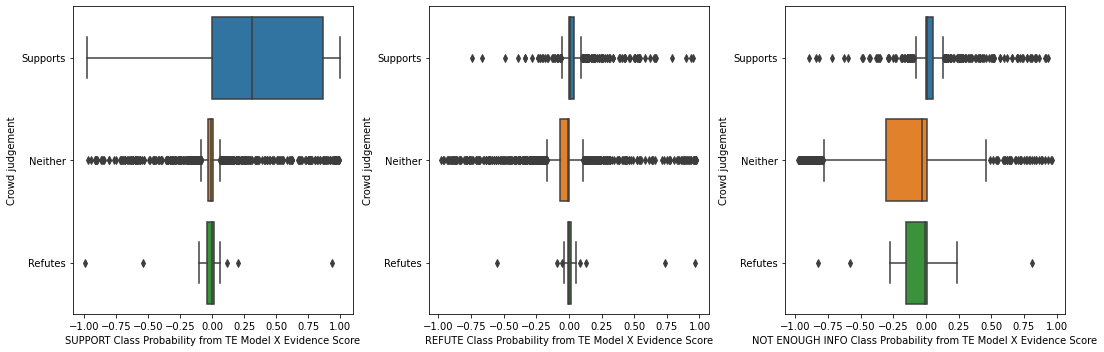

In [61]:
# Lastly, get the same as above but multiplying by scores
for r in ['Supports','Refutes','Neither']:
    results_single_df_agg_te_labels[f'{r}_prob_times_ev_score'] =\
        results_single_df_agg_te_labels[f'{r}_prob'] * results_single_df_agg_te_labels['score']
results_single_df_te_labels

fig, ax = plt.subplots(1,3,figsize=(15,5))

g = sns.boxplot(
    data=results_single_df_agg_te_labels,
    x='Supports_prob_times_ev_score',
    y='relation_maj_label',
    ax=ax[0], 
)
g.set(xlabel='SUPPORT Class Probability from TE Model X Evidence Score',ylabel='Crowd judgement')

g = sns.boxplot(
    data=results_single_df_agg_te_labels,
    x='Refutes_prob_times_ev_score',
    y='relation_maj_label',
    ax=ax[1], 
)
g.set(xlabel='REFUTE Class Probability from TE Model X Evidence Score',ylabel='Crowd judgement')

g = sns.boxplot(
    data=results_single_df_agg_te_labels,
    x='Neither_prob_times_ev_score',
    y='relation_maj_label',
    ax=ax[2], 
)
g.set(xlabel='NOT ENOUGH INFO Class Probability from TE Model X Evidence Score',ylabel='Crowd judgement')

plt.tight_layout()

EDIT OF THE COMMENTS ON INDIVIDUAL NON-AGGREGATED RELATION ANNOTATIONS because it still applies.

These charts are the probabilities multiplied by evidence score.\
This is to see if, after accounting for relevance, we have:

In the first chart (Support prob * relevance), a higher amount near the positive values for those voted "Supports" by the crowd. WE DO.

In the second chart (Refute prob * relevance), a higher amount near the positive values for those voted "Refutes" by the crowd. WE DO, BUT BARELY, STILL SIMILAR TO NEITHER (although better than not multiplying by relevance).

Third chart is promissing, as it shows that there is a CLEAR difference between what the crowd has tagged as Neither and what the crowd as tagged as Refutes when one factors in the EVIDENCE SCORES on top of the "Neither" TE class probability. This is promising in the case we want to use a final model predictor basedon the collection of EV scores and TE probabilities for a given reference.

This might be better visualised if we reorganise like below:

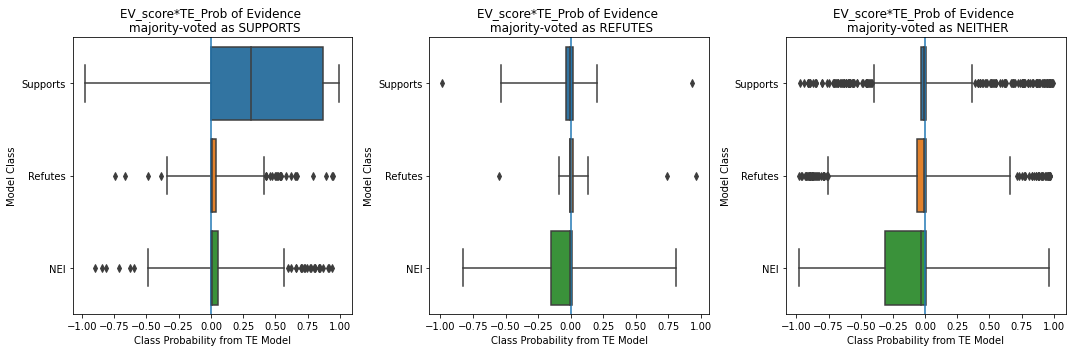

In [62]:
# These plots here are just an inverse of the plots above and illustrate the point written on the previous cell
fig, ax = plt.subplots(1,3,figsize=(15,5))

results_single_df_agg_te_labels['relation_maj_label'] = results_single_df_agg_te_labels['relation_maj']\
    .map({i: x for i, x in enumerate(RELATION_LABELS)})

for i, cl in enumerate(['SUPPORTS','REFUTES','NEITHER']):
    g = sns.boxplot(
        data=results_single_df_agg_te_labels[
                results_single_df_agg_te_labels['relation_maj'] == i
            ][['Supports_prob_times_ev_score','Refutes_prob_times_ev_score','Neither_prob_times_ev_score']]
            .melt(),
        y='variable', whis=10,
        x='value', ax=ax[i]
    )

    g.set(
        xlabel='Class Probability from TE Model',
        ylabel='Model Class',
        yticklabels=['Supports','Refutes','NEI'],
        title=f'EV_score*TE_Prob of Evidence \n majority-voted as {cl}'
    )
    
    g.axvline(x=0)
    
plt.tight_layout()


The takeaways HERE are that:
- for evidence judged by the crowd to be SUPPORTIVE, it has positive values of EV_score*Supports_prob and close to 0 values for the other two classes.
- for evidence judged by the crowd to be REFUTING, it has very near 0 EV_score*Supports_prob, slightly positive values of EV_score*Refutes_prob, and values of EV_score*NEI_prob mostly near zero. 
- for evidence judged by the crowd to be NEITHER, it has very near 0 or negative EV_score*X_prob for all classes.

The above observations mean that, given all 3 of an evidence's EV_score **and** TE_prob distributions, we might find the most probable class it would be majority voted as. We might also include evidence size.

Let's then repeat the Confusion Matrix but, for all Model class outputs, if the score is under THR (starting at 0), bin it to "Neither Model" instead and see what happens (also check classification scores based on THR).

### Applying hyper-models to the TE problem

This is an alternate to the usage of an argmax function, as was used before (see the confusion matrix at 7.3 for reference of performance on argmax).

In [63]:
ref_ev_texts = results_single_df[['reference_id','evidence_id','evidence']]\
    .drop_duplicates(['reference_id','evidence_id'])\
    .reset_index(drop=True)
ref_ev_texts

,reference_id,evidence_id,evidence
0,5585dca2dcee1370bb7966f8387d926d6e58ed8d,4,Dr. Weiss specialized in the history of Italia...
1,0ad5794411e04d953f8ee4d88d7b872caa26e3e1,0,(Show more) See all related content →. Margare...
2,5bc0f775565a29c227394e2f1888dda61f8efa1e,2,Sarah Pyne Rippon. 1738–1831 (m. 1773) Flowers...
3,410bd8658602cc859be22d5165ffd3ded97c9d82,2,Melodee M. Spevack as Admiral Melanie Cain ( β...
4,d1a974eaba1f3b32f7ebc2459c7cbf46e2f5aa92,1,"Retrieved from "" https://www.gracesguide.co.uk..."
...,...,...,...
2040,256847f032fdc46b46e3e4235c08c5e339b799b2,4,Visitor App. Our app is your one-stop shop for...
2041,c9681f0c0f7d97dc983f2b6ce325f2adc598f43c,2,"Steered by his 1913 railway guide, Michael Por..."
2042,c807e80b2eff7c941c8062ab61a97632745a3fb8,1,"Leveson, a member of the king’s privy chamber,..."
2043,539444c623cf37705a6a0b0260796497c16ba5f1,0,Central to Tony's ideas is the Mind Map® which...


In [64]:
results_single_df_agg_te_labels = pd.merge(
    results_single_df_agg_te_labels,
    ref_ev_texts,
    on=['reference_id','evidence_id']
)
results_single_df_agg_te_labels['evidence_len'] = results_single_df_agg_te_labels['evidence'].map(len)
results_single_df_agg_te_labels = pd.merge(
    results_single_df_agg_te_labels,
    te_df[['reference_id','netloc_agg']],
    on='reference_id'
)

In [65]:
results_single_df_agg_te_labels

,reference_id,evidence_id,score,relation_maj,relation_maj_tie,reason_not_sure_maj,relevant_maj,TE_model_label,Supports_prob,Refutes_prob,Neither_prob,TE_model_label_num,relation_maj_label,Supports_prob_times_ev_score,Refutes_prob_times_ev_score,Neither_prob_times_ev_score,evidence,evidence_len,netloc_agg
0,00d15820946d663523ad6ad9316fcc27ffe4a791,0,0.999882,0,False,-1,1,SUPPORTS,0.994493,0.001133,0.004373,0,Supports,0.994376,0.001133,0.004373,"Anaheim Ice, for­merly known as Disney Ice, is...",103,deu.archinform.net
1,00d15820946d663523ad6ad9316fcc27ffe4a791,1,0.536719,2,False,-1,0,SUPPORTS,0.967906,0.002971,0.029123,0,Neither,0.519494,0.001594,0.015631,"In late 2019, the Ducks re­lo­cated their prac...",93,deu.archinform.net
2,00d15820946d663523ad6ad9316fcc27ffe4a791,2,0.241545,2,False,-1,0,SUPPORTS,0.985370,0.000905,0.013725,0,Neither,0.238011,0.000219,0.003315,It was the prac­tice and train­ing rink of the...,245,deu.archinform.net
3,00d15820946d663523ad6ad9316fcc27ffe4a791,3,0.104416,2,False,-1,0,SUPPORTS,0.948274,0.002433,0.049293,0,Neither,0.099015,0.000254,0.005147,It opened in 1995. When the Ana­heim Ducks (th...,215,deu.archinform.net
4,00d15820946d663523ad6ad9316fcc27ffe4a791,4,-0.126725,2,False,-1,0,SUPPORTS,0.962176,0.002534,0.035290,0,Neither,-0.121932,-0.000321,-0.004472,"De­spite later re­sum­ing op­er­a­tions, Ana­h...",158,deu.archinform.net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,fee28b055fe25d699a5092e83fdb146831cdefe1,0,0.958324,0,False,-1,1,NOT ENOUGH INFO,0.079671,0.045673,0.874655,2,Supports,0.076351,0.043770,0.838203,This episode marks Wesley Crusher's final regu...,233,memory-alpha.fandom.com
2041,fee28b055fe25d699a5092e83fdb146831cdefe1,1,0.843562,2,False,-1,0,NOT ENOUGH INFO,0.023604,0.036812,0.939584,2,Neither,0.019912,0.031053,0.792597,He later appeared in the fifth season Next Gen...,168,memory-alpha.fandom.com
2042,fee28b055fe25d699a5092e83fdb146831cdefe1,2,0.181564,2,False,-1,0,NOT ENOUGH INFO,0.430545,0.018184,0.551271,2,Neither,0.078171,0.003302,0.100091,Brent Spiner as Lt. Commander Data. Wil Wheato...,73,memory-alpha.fandom.com
2043,fee28b055fe25d699a5092e83fdb146831cdefe1,3,0.123930,2,False,-1,0,NOT ENOUGH INFO,0.038369,0.023471,0.938160,2,Neither,0.004755,0.002909,0.116266,After Picard leaves a directional marker on th...,162,memory-alpha.fandom.com


In [66]:
from sklearn.model_selection import train_test_split as tts

prediction_data = results_single_df_agg_te_labels[
    ['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len','relation_maj','netloc_agg']
]
prediction_data

,score,Supports_prob,Refutes_prob,Neither_prob,evidence_len,relation_maj,netloc_agg
0,0.999882,0.994493,0.001133,0.004373,103,0,deu.archinform.net
1,0.536719,0.967906,0.002971,0.029123,93,2,deu.archinform.net
2,0.241545,0.985370,0.000905,0.013725,245,2,deu.archinform.net
3,0.104416,0.948274,0.002433,0.049293,215,2,deu.archinform.net
4,-0.126725,0.962176,0.002534,0.035290,158,2,deu.archinform.net
...,...,...,...,...,...,...,...
2040,0.958324,0.079671,0.045673,0.874655,233,0,memory-alpha.fandom.com
2041,0.843562,0.023604,0.036812,0.939584,168,2,memory-alpha.fandom.com
2042,0.181564,0.430545,0.018184,0.551271,73,2,memory-alpha.fandom.com
2043,0.123930,0.038369,0.023471,0.938160,162,2,memory-alpha.fandom.com


#### RFC

              precision    recall  f1-score   support

           0       0.57      0.77      0.66       186
           1       0.00      0.00      0.00         6
           2       0.89      0.75      0.82       483

    accuracy                           0.75       675
   macro avg       0.49      0.51      0.49       675
weighted avg       0.79      0.75      0.76       675



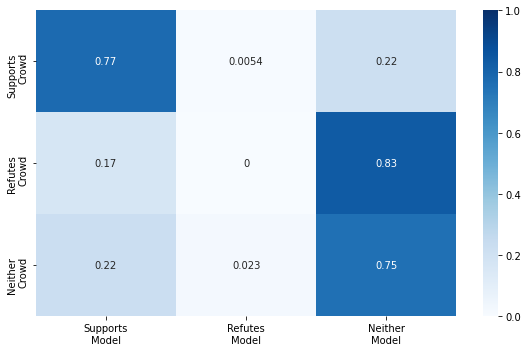

In [347]:
from sklearn.ensemble import RandomForestClassifier as RFC

prediction_data_train, prediction_data_test = tts(prediction_data, test_size=0.33, random_state=42)

rfc = RFC(
    class_weight = 'balanced',
    n_estimators = 100,
    max_depth = 4
)

rfc.fit(
    X = prediction_data_train[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']],
    y = prediction_data_train['relation_maj']
)

y_pred = rfc.predict(prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']])
y_true = prediction_data_test['relation_maj']

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

              precision    recall  f1-score   support

           0       0.56      0.75      0.64       186
           1       0.07      0.17      0.10         6
           2       0.88      0.76      0.81       483

    accuracy                           0.75       675
   macro avg       0.50      0.56      0.52       675
weighted avg       0.79      0.75      0.76       675



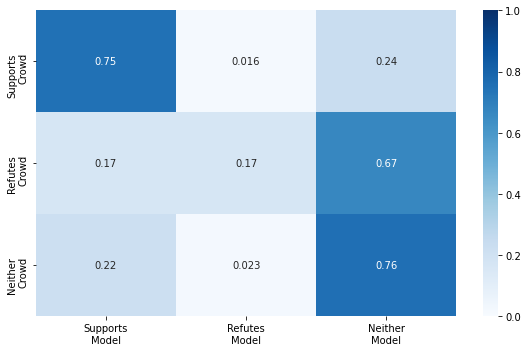

In [348]:
from sklearn.ensemble import RandomForestClassifier as RFC
from imblearn.over_sampling import BorderlineSMOTE

# RFC with oversampling

prediction_data_train, prediction_data_test = tts(prediction_data, test_size=0.33, random_state=42)

sm = BorderlineSMOTE(random_state=42)

X_res, y_res = sm.fit_resample(
    prediction_data_train[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']], 
    prediction_data_train['relation_maj']
) 

rfc = RFC(
    class_weight='balanced',
    n_estimators = 10,
    max_depth = 10
)

rfc.fit(
    X = X_res,
    y = y_res
)

y_pred = rfc.predict(prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']])
y_true = prediction_data_test['relation_maj']

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

# Works better, as no supports/refutes confusion is made

#### NN

In [349]:
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Dense
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.utils import to_categorical
#
#prediction_data_train, prediction_data_test = tts(prediction_data, test_size=0.5, random_state=42)
#prediction_data_val, prediction_data_test = tts(prediction_data_test, test_size=0.5, random_state=42)
#
#sm = BorderlineSMOTE(random_state=42)
#
#X_res, y_res = sm.fit_resample(
#    prediction_data_train[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']], 
#    prediction_data_train['relation_maj']
#)
#
#y_res = to_categorical(y_res)
#
#input_layer = Input(shape=(X_res.shape[1],))
#hidden_act = 'tanh'
#dense = Dense(16, activation=hidden_act)(input_layer)
#dense = Dense(32, activation=hidden_act)(dense)
#dense = Dense(8, activation=hidden_act)(dense)
#output_layer = Dense(y_res.shape[1], activation='sigmoid')(dense)
#clf = Model(inputs=input_layer, outputs=output_layer)
#clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#
#print(clf.summary())
#
#X_val = prediction_data_val[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']]
#y_val = prediction_data_val['relation_maj']
#y_val = to_categorical(y_val)
#
#training_lstm = clf.fit(
#    X_res,
#    y_res,
#    epochs=100,
#    batch_size=1,
#    validation_data= (X_val, y_val),
#    callbacks=[
#        EarlyStopping(monitor='val_loss', patience=5),             
#    ]
#)

In [350]:
#y_pred = clf.predict(prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']])
#y_true = prediction_data_test['relation_maj']
#
#from sklearn.metrics import confusion_matrix
#fig, ax = plt.subplots(1,1, figsize=(8,5))
#
#cm = confusion_matrix(
#    y_pred = np.argmax(y_pred, axis=1),
#    y_true = y_true,
#    normalize='true'
#)
#
#g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
#g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
#g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])
#
#plt.tight_layout()
#
#print(classification_report(
#    y_pred = np.argmax(y_pred, axis=1),
#    y_true = y_true,
#    zero_division=0
#))

#### XGBoost

C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:19:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.52      0.76      0.62       186
           1       0.00      0.00      0.00         6
           2       0.88      0.73      0.80       483

    accuracy                           0.73       675
   macro avg       0.47      0.50      0.47       675
weighted avg       0.77      0.73      0.74       675



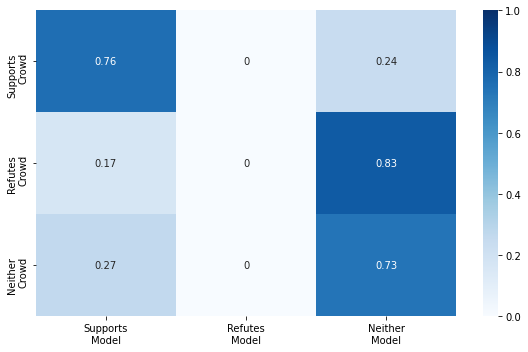

In [351]:
import xgboost as xgb

prediction_data_train, prediction_data_test = tts(prediction_data, test_size=0.33, random_state=42)

xgbc = xgb.XGBClassifier(
    #class_weight = 'balanced',
    n_estimators = 100,
    max_depth = 4
)

xgbc.fit(
    sample_weight = [15 if x==0 else 1 for x in prediction_data_train['relation_maj']],
    X = prediction_data_train[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']],
    y = prediction_data_train['relation_maj']
)

y_pred = xgbc.predict(prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']])
y_true = prediction_data_test['relation_maj']

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

### Single Evidence VS. Two-class simpler problems

#### Supportive or NOT

In [352]:
TWO_CLASS_LABELS = ['Supportive','NOT Supporitive']
to_two_class = lambda x : int(x != 0)

##### ARGMAX (Trivial approach)

              precision    recall  f1-score   support

           0       0.56      0.72      0.63       583
           1       0.87      0.77      0.82      1462

    accuracy                           0.76      2045
   macro avg       0.72      0.75      0.73      2045
weighted avg       0.78      0.76      0.77      2045



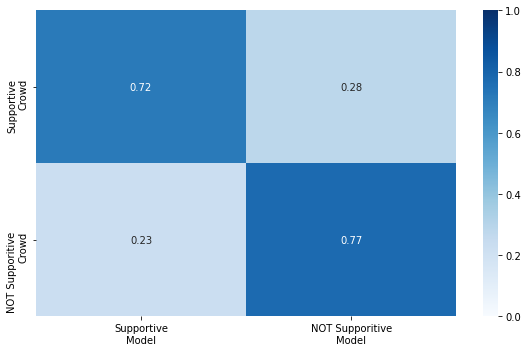

In [353]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = results_single_df_agg_te_labels['TE_model_label_num'].map(to_two_class),
    y_true = results_single_df_agg_te_labels['relation_maj'].map(to_two_class),
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

plt.tight_layout()

from sklearn.metrics import classification_report
cr = classification_report(
    y_pred = results_single_df_agg_te_labels['TE_model_label_num'].map(to_two_class),
    y_true = results_single_df_agg_te_labels['relation_maj'].map(to_two_class)
)
print(cr)

##### RFC

              precision    recall  f1-score   support

           0       0.55      0.74      0.63       186
           1       0.89      0.77      0.83       489

    accuracy                           0.76       675
   macro avg       0.72      0.75      0.73       675
weighted avg       0.79      0.76      0.77       675



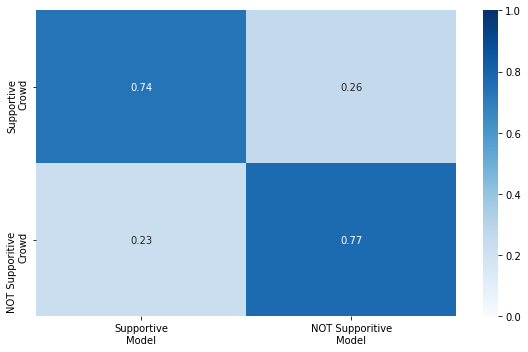

In [354]:
from sklearn.ensemble import RandomForestClassifier as RFC
from imblearn.over_sampling import BorderlineSMOTE

# RFC with oversampling

prediction_data_train, prediction_data_test = tts(prediction_data, test_size=0.33, random_state=42)

sm = BorderlineSMOTE(random_state=42)

X_res, y_res = sm.fit_resample(
    prediction_data_train[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']], 
    prediction_data_train['relation_maj'].map(to_two_class)
) 

rfc = RFC(class_weight='balanced')

rfc.fit(    
    X = X_res,
    y = y_res
)

y_pred = rfc.predict(prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']])
y_true = prediction_data_test['relation_maj'].map(to_two_class)

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

# Works better, as no supports/refutes confusion is made

<AxesSubplot:>

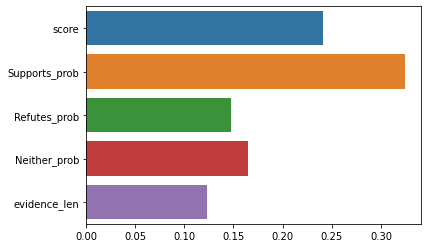

In [355]:
sns.barplot(x=rfc.feature_importances_, y=['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len'])

In [356]:
class_metrics_per_netloc = []
for netloc in prediction_data_test['netloc_agg'].unique():
    prediction_data_test_netloc = prediction_data_test[prediction_data_test['netloc_agg'] == netloc]
    y_pred = rfc.predict(prediction_data_test_netloc[
        ['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']
    ])
    y_true = prediction_data_test_netloc['relation_maj'].map(to_two_class)
    cf = classification_report(
        y_pred = y_pred,
        y_true = y_true,
        zero_division=0,
        output_dict = True
    )
    class_metrics_per_netloc.append({
        'netloc_agg': netloc,
        'accuracy': cf['accuracy'],
        'f1_macro': cf['macro avg']['f1-score'],
        'support': cf['macro avg']['support'],
    })
class_metrics_per_netloc = pd.DataFrame(class_metrics_per_netloc)

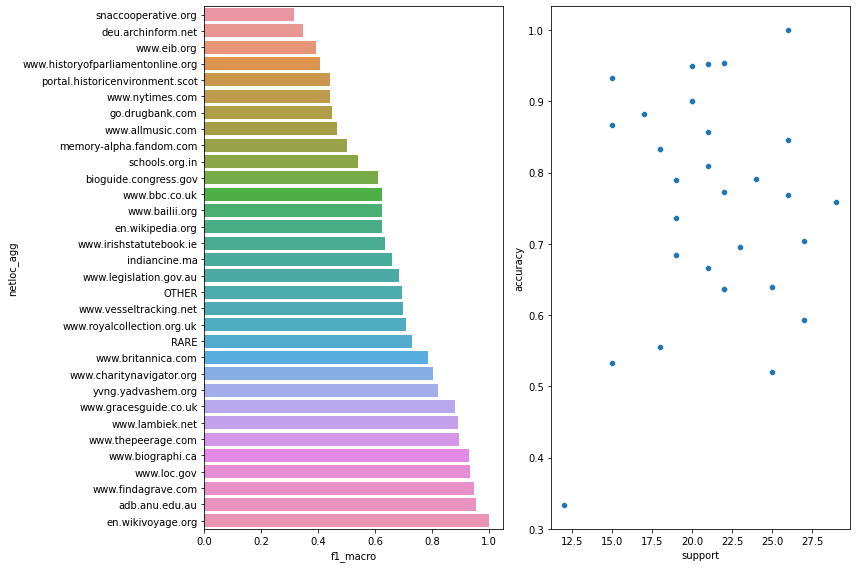

In [357]:
fig, ax = plt.subplots(1, 2, figsize = (12,8))

sns.barplot(
    data=class_metrics_per_netloc,
    y = 'netloc_agg',
    x='f1_macro',
    order=class_metrics_per_netloc.sort_values('f1_macro')['netloc_agg'],
    ax=ax[0]
)

sns.scatterplot(
    data=class_metrics_per_netloc,
    y ='accuracy',
    x='support',
    ax=ax[1]
)

plt.tight_layout()

              precision    recall  f1-score   support

           0       0.47      0.90      0.62       186
           1       0.94      0.62      0.75       489

    accuracy                           0.70       675
   macro avg       0.71      0.76      0.69       675
weighted avg       0.81      0.70      0.71       675



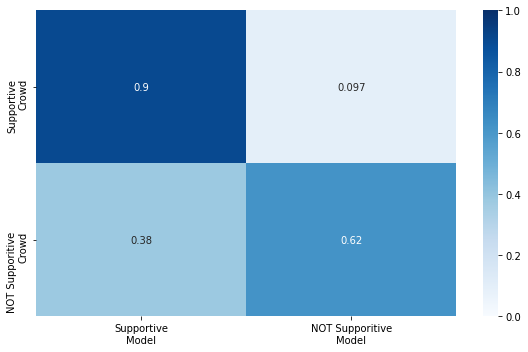

In [359]:
# MINIMIZING FALSE-POSITIVES

from sklearn.ensemble import RandomForestClassifier as RFC
from imblearn.over_sampling import BorderlineSMOTE

# RFC with oversampling

prediction_data_train, prediction_data_test = tts(prediction_data, test_size=0.33, random_state=42)

X_res = prediction_data_train[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']]
y_res = prediction_data_train['relation_maj'].map(to_two_class)

class_weights = dict(1/y_res.value_counts(normalize=True))
class_weights[0] = class_weights[0]*2

rfc = RFC(
    class_weight=class_weights,
    n_estimators = 100,
    max_depth = 3
)

rfc.fit(    
    X = X_res,
    y = y_res
)

y_pred = rfc.predict(prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']])
y_true = prediction_data_test['relation_maj'].map(to_two_class)

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

# Works better, as no supports/refutes confusion is made

0.8485003408316292


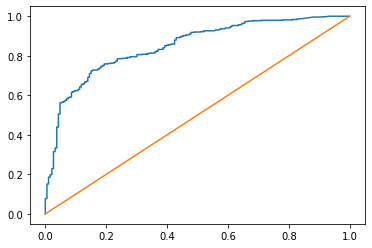

In [360]:
from sklearn.metrics import roc_curve, roc_auc_score

def get_roc(y_true, y_pred_prob):

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_score = roc_auc_score(y_true, y_pred_prob, average=None)

    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1])
    print(roc_score)
    return fpr, tpr, thresholds, roc_score

y_pred_prob = rfc.predict_proba(
    prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']]
)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);

##### NN

In [79]:
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Dense
#from tensorflow.keras.callbacks import EarlyStopping
#
#prediction_data_train, prediction_data_test = tts(prediction_data, test_size=0.5, random_state=42)
#prediction_data_val, prediction_data_test = tts(prediction_data_test, test_size=0.5, random_state=42)
#
#sm = BorderlineSMOTE(random_state=42)
#
#X_res, y_res = sm.fit_resample(
#    prediction_data_train[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']], 
#    prediction_data_train['relation_maj'].map(to_two_class)
#)
##X_res = prediction_data_train[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']]
##y_res = prediction_data_train['relation_maj'].map(to_two_class)
#y_res = to_categorical(y_res)
#
#input_layer = Input(shape=(X_res.shape[1],))
#hidden_act = 'sigmoid'
#dense = Dense(16, activation=hidden_act)(input_layer)
#dense = Dense(8, activation=hidden_act)(dense)
#output_layer = Dense(y_res.shape[1], activation='softmax')(dense)
#clf = Model(inputs=input_layer, outputs=output_layer)
#clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#
#print(clf.summary())
#
#X_val = prediction_data_val[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']]
#y_val = prediction_data_val['relation_maj'].map(to_two_class)
#y_val = to_categorical(y_val)
#
#training_lstm = clf.fit(
#    X_res,
#    y_res,
#    epochs=100,
#    batch_size=4,
#    validation_data= (X_val, y_val),
#    callbacks=[
#        EarlyStopping(monitor='val_accuracy', patience=5),             
#    ]
#)

In [80]:
#y_pred = clf.predict(prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']])
#y_true = prediction_data_test['relation_maj'].map(to_two_class)
#
#from sklearn.metrics import confusion_matrix
#fig, ax = plt.subplots(1,1, figsize=(8,5))
#
#cm = confusion_matrix(
#    y_pred = np.argmax(y_pred, axis=1),
#    y_true = y_true,
#    normalize='true'
#)
#
#g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
#g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
#g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])
#
#plt.tight_layout()
#
#print(classification_report(
#    y_pred = np.argmax(y_pred, axis=1),
#    y_true = y_true,
#    zero_division=0
#))

##### XGBoost

C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:20:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       186
           1       0.86      0.87      0.86       489

    accuracy                           0.80       675
   macro avg       0.75      0.75      0.75       675
weighted avg       0.80      0.80      0.80       675



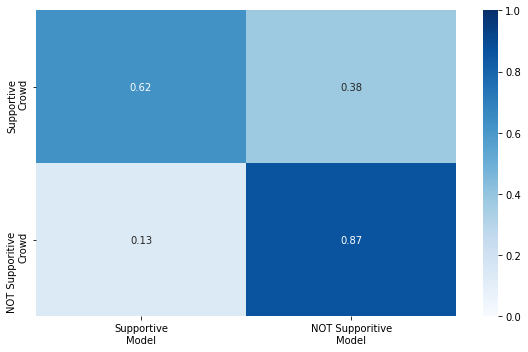

In [361]:
prediction_data_train, prediction_data_test = tts(prediction_data, test_size=0.33, random_state=42)

X_res = prediction_data_train[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']]
y_res = prediction_data_train['relation_maj'].map(to_two_class)

class_weights = dict(1/y_res.value_counts(normalize=True))
class_weights[0] = class_weights[0]

xgbc = xgb.XGBClassifier(
    #n_estimators = 100,
    #max_depth = 3
)

xgbc.fit(    
    sample_weight = [class_weights[y] for y in y_res],
    X = X_res,
    y = y_res
)

y_pred = xgbc.predict(prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']])
y_true = prediction_data_test['relation_maj'].map(to_two_class)

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

# Optimizes overall acc/f1

0.8236526156078896


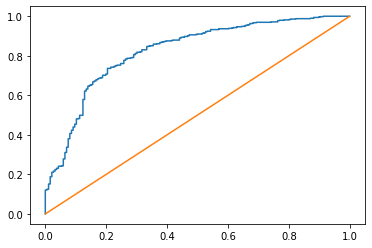

In [364]:
y_pred_prob = xgbc.predict_proba(
    prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']]
)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);

#### Relevant or NOT

In [82]:
TWO_CLASS_LABELS_2 = ['Relevant','NOT Relevant']
to_two_class_2 = lambda x : int(x not in  [0,1])

##### Argmax

              precision    recall  f1-score   support

           0       0.40      0.81      0.54       604
           1       0.86      0.49      0.63      1441

    accuracy                           0.59      2045
   macro avg       0.63      0.65      0.58      2045
weighted avg       0.73      0.59      0.60      2045



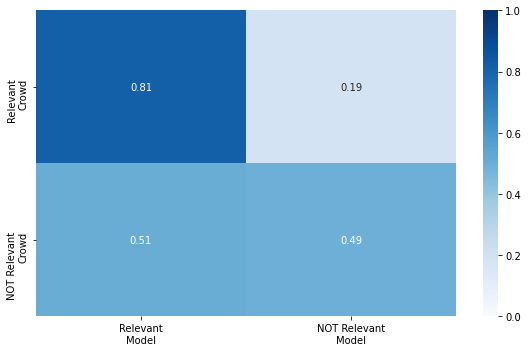

In [83]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = results_single_df_agg_te_labels['TE_model_label_num'].map(to_two_class_2),
    y_true = results_single_df_agg_te_labels['relation_maj'].map(to_two_class_2),
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS_2])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS_2])

plt.tight_layout()

from sklearn.metrics import classification_report
cr = classification_report(
    y_pred = results_single_df_agg_te_labels['TE_model_label_num'].map(to_two_class_2),
    y_true = results_single_df_agg_te_labels['relation_maj'].map(to_two_class_2)
)
print(cr)

##### RFC

              precision    recall  f1-score   support

           0       0.56      0.71      0.62       192
           1       0.87      0.78      0.82       483

    accuracy                           0.76       675
   macro avg       0.71      0.74      0.72       675
weighted avg       0.78      0.76      0.76       675



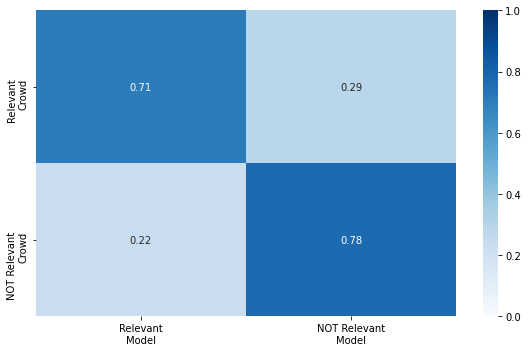

In [84]:
from sklearn.ensemble import RandomForestClassifier as RFC
from imblearn.over_sampling import BorderlineSMOTE

# RFC with oversampling

prediction_data_train, prediction_data_test = tts(prediction_data, test_size=0.33, random_state=42)

sm = BorderlineSMOTE(random_state=42)

X_res, y_res = sm.fit_resample(
    prediction_data_train[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']], 
    prediction_data_train['relation_maj'].map(to_two_class_2)
) 

rfc = RFC()

rfc.fit(
    X = X_res,
    y = y_res
)

y_pred = rfc.predict(prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']])
y_true = prediction_data_test['relation_maj'].map(to_two_class_2)

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS_2])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS_2])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

# Works better, as no supports/refutes confusion is made

              precision    recall  f1-score   support

           0       0.48      0.89      0.62       192
           1       0.93      0.61      0.74       483

    accuracy                           0.69       675
   macro avg       0.71      0.75      0.68       675
weighted avg       0.80      0.69      0.71       675



array([[171,  21],
       [186, 297]], dtype=int64)

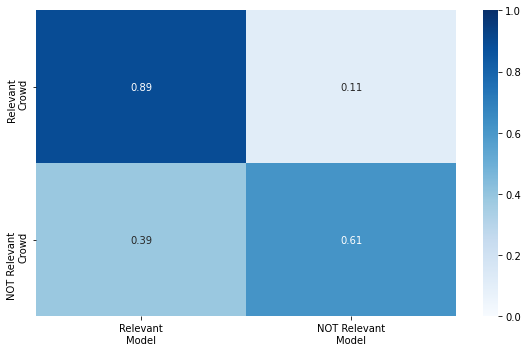

In [274]:
from sklearn.ensemble import RandomForestClassifier as RFC
from imblearn.over_sampling import BorderlineSMOTE


prediction_data_train, prediction_data_test = tts(prediction_data, test_size=0.33, random_state=42)

X_res = prediction_data_train[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']]
y_res = prediction_data_train['relation_maj'].map(to_two_class_2)

class_weights = dict(1/y_res.value_counts(normalize=True))
class_weights[0] = class_weights[0]*2

rfc = RFC(
    class_weight=class_weights,
    n_estimators = 100,
    max_depth = 3
)

rfc.fit(
    X = X_res,
    y = y_res
)

y_pred = rfc.predict(prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']])
y_true = prediction_data_test['relation_maj'].map(to_two_class_2)

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS_2])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS_2])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

confusion_matrix(
    y_pred = y_pred,
    y_true = y_true
)

# Minimising False Positive Rate (1-Recall) (positive = not relevant)
# Can be done with recalls: 0: 90, 1:60 (weight mult 2)
# can also be done with recalls 0: 95, 1:37 (weight mult 5)

0.8341690389924085


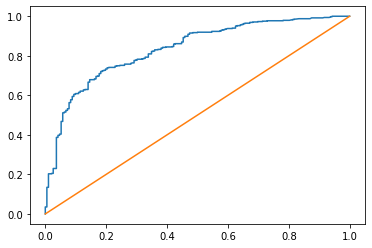

In [291]:
y_pred_prob = rfc.predict_proba(
    prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']]
)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);

##### XGBoost

[17:51:50] WARNING: ..\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:51:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.69      0.59      0.64       192
           1       0.85      0.90      0.87       483

    accuracy                           0.81       675
   macro avg       0.77      0.74      0.75       675
weighted avg       0.80      0.81      0.80       675



C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


array([[113,  79],
       [ 50, 433]], dtype=int64)

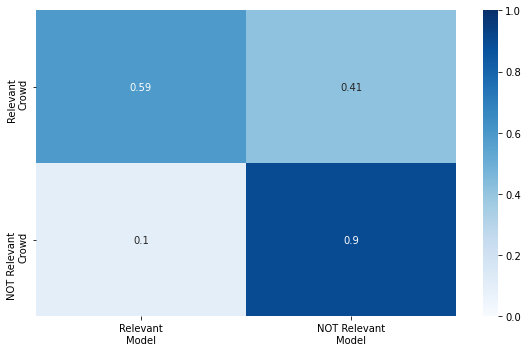

In [273]:
prediction_data_train, prediction_data_test = tts(prediction_data, test_size=0.33, random_state=42)

X_res = prediction_data_train[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']]
y_res = prediction_data_train['relation_maj'].map(to_two_class_2)

class_weights = dict(1/y_res.value_counts(normalize=True))
class_weights[0] = class_weights[0]*2

xgbc = xgb.XGBClassifier(
    class_weight=class_weights,
    n_estimators = 100,
    max_depth = 3
)

xgbc.fit(
    X = X_res,
    y = y_res
)

y_pred = xgbc.predict(prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']])
y_true = prediction_data_test['relation_maj'].map(to_two_class_2)

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS_2])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS_2])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

confusion_matrix(
    y_pred = y_pred,
    y_true = y_true
)

# Minimising False Negative Rate

0.8259090320910972


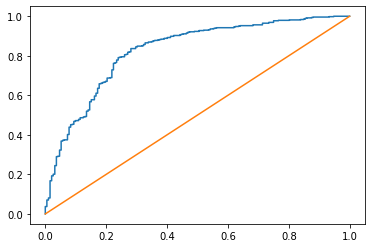

In [292]:
y_pred_prob = xgbc.predict_proba(
    prediction_data_test[['score','Supports_prob','Refutes_prob','Neither_prob','evidence_len']]
)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);

## Agg. Multiple Evidence annot. VS. Agg. TE labels (WS + ML)

### WS and ML + Distributions

In [86]:
results_multiple_df_agg = results_multiple_df.copy()
results_multiple_df_agg = results_multiple_df_agg\
    .groupby(['reference_id']).agg(list)
results_multiple_df_agg.drop(
    ['evidence_list'], axis=1, inplace=True
)

for c in results_multiple_df_agg.columns:
    if c in ['worker_id','assignment_id','relation','reason_not_sure','reason_not_sure_others','time']:
        continue
    else:
        if results_multiple_df_agg[c].map(lambda x : pd.Series(x).unique().size == 1).all():
            results_multiple_df_agg[c] = results_multiple_df_agg[c]\
                .map(lambda x : pd.Series(x).unique()[0])
            
results_multiple_df_agg.head()

,claim_id,affirmation,reference_url,worker_id,assignment_id,relation,reason_not_sure,reason_not_sure_other,times
reference_id,,,,,,,,,
00d15820946d663523ad6ad9316fcc27ffe4a791,Q4750883$C5B95856-A961-4EA4-95F5-995B94509CC7,Anaheim Ice is located in Anaheim.,https://www.archinform.net/entry.htm?ID=bmkdbj...,"[A1SAAR4KRNSLKQ, A2D74QPANDB2I7, A1EQ8UXKOUDYT...","[3JV9LGBJWXQQ9PPTDNXE3CFVSQCGOF, 3AZHRG4CU8W4C...","[1, 0, 0, 2, 0]","[-1, -1, -1, -1, -1]","[, , , , ]","[6920, 43217, 23941, 10066, 70548]"
00d4fa84c656b876dddecc868489d261554c4ca1,Q17849283$4EDA0CCF-7158-485C-9D9C-28326CAEC967,"Forth And Clyde Canal, Bowling Basin, Drawbrid...",http://portal.historicenvironment.scot/designa...,"[A1B1DPJRVIAV3L, A39MKVROUZ1UWR, AZ5ZYUCAQ0XDL...","[3E337GFOLDK8R4PHC8X1ONFQ2G7GN0, 3SLE99ER0RP6H...","[2, 2, 2, 2, 0]","[-1, -1, -1, -1, -1]","[, , , , ]","[27871, 38728, 20531, 24575, 6573]"
00d94a4a5c4ea458a8abe9a15682a4499114b634,Q17777953$c15f71a3-4c08-3798-78dd-a4ed158a5286,"Dunnottar Castle, East Guardhouse is designate...",http://portal.historicenvironment.scot/designa...,"[AZ5ZYUCAQ0XDL, A1RGKVJZAFBN4Q, A1EQ8UXKOUDYT4...","[3QY5DC2MXVWF8UDVYP35KX789X0UF7, 3X73LLYYQ5QMR...","[2, 0, 2, 2, 1]","[-1, -1, -1, -1, -1]","[, , , , ]","[58603, 56068, 35421, 4366, 58321]"
0280723077b22b8f9cf2c636fa889db510e0272d,Q56818480$2D60B386-F18B-43B3-9B76-C5B4BE960D2A,The Department of Finance is the administrator...,https://www.legislation.gov.au/Details/C2004A0...,"[A219SZBLCCCXN9, A3774HPOUKYTX7, AB7ZGKRL87OZ1...","[3483FV8BEIVA5PBIECQVK8Z3X7E26U, 337RC3OW09E1L...","[0, 0, 0, 2, 2]","[-1, -1, -1, -1, -1]","[, , , , ]","[38893, 12117, 74042, 110405, 78648]"
0427581cda67794db9cab34a1f91379a8004acbd,Q76051026$0ad99c6c-43fb-846f-5698-dcc435710ae1,Noel Short died in 2001.,https://www.telegraph.co.uk/news/obituaries/mi...,"[ATBBPV37O4K6N, A1MXDBILWV8RXN, ACOGH7IWJZR6A,...","[3M1CVSFP64HSKAP660X8WVZS9WIQAM, 3HSYG7LRBNACL...","[1, 2, 1, 1, 0]","[-1, -1, -1, -1, -1]","[, , , , ]","[3256, 86417, 61207, 58797, 61562]"


In [87]:
relation_majs = results_multiple_df_agg['relation'].map(get_majority_relation)
results_multiple_df_agg['relation_maj'] = [x[0] for x in relation_majs]
results_multiple_df_agg['relation_maj_tie'] = [x[1] for x in relation_majs]
results_multiple_df_agg['reason_not_sure_maj'] = results_multiple_df_agg['reason_not_sure']\
    .map(get_majority_reason_not_sure)
results_multiple_df_agg = results_multiple_df_agg[
    ['claim_id','relation_maj','relation_maj_tie','reason_not_sure_maj']
].copy()
results_multiple_df_agg.head()

,claim_id,relation_maj,relation_maj_tie,reason_not_sure_maj
reference_id,,,,
00d15820946d663523ad6ad9316fcc27ffe4a791,Q4750883$C5B95856-A961-4EA4-95F5-995B94509CC7,0,False,-1
00d4fa84c656b876dddecc868489d261554c4ca1,Q17849283$4EDA0CCF-7158-485C-9D9C-28326CAEC967,2,False,-1
00d94a4a5c4ea458a8abe9a15682a4499114b634,Q17777953$c15f71a3-4c08-3798-78dd-a4ed158a5286,2,False,-1
0280723077b22b8f9cf2c636fa889db510e0272d,Q56818480$2D60B386-F18B-43B3-9B76-C5B4BE960D2A,0,False,-1
0427581cda67794db9cab34a1f91379a8004acbd,Q76051026$0ad99c6c-43fb-846f-5698-dcc435710ae1,1,False,-1


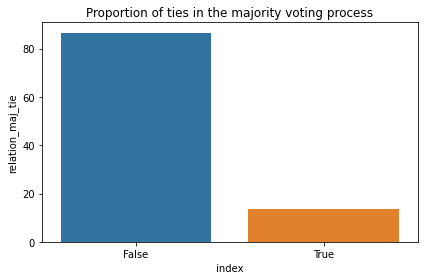

In [88]:
g = sns.barplot(
    data = results_multiple_df_agg
    .relation_maj_tie
    .value_counts(normalize=True)
    .mul(100)
    .reset_index(),    
    x='index',
    y='relation_maj_tie',
)
g.set_title('Proportion of ties in the majority voting process')
plt.tight_layout()

In [89]:
results_multiple_df_agg_scores = pd.merge(
    results_multiple_df_agg.reset_index(),
    te_df_pre_join,
    on=['reference_id', 'claim_id'],
    how='left'
)[['reference_id', 'relation_maj', 'WS_TE_probs', 'WS_TE_label', 'MALON_TE_label', 'WS_TE_id', 'MALON_TE_id']]
results_multiple_df_agg_scores.head()

,reference_id,relation_maj,WS_TE_probs,WS_TE_label,MALON_TE_label,WS_TE_id,MALON_TE_id
0,00d15820946d663523ad6ad9316fcc27ffe4a791,0,"[1.8508957624, 0.0032003894000000002, 0.028466...",SUPPORTS,SUPPORTS,0,0
1,00d4fa84c656b876dddecc868489d261554c4ca1,2,"[0, 0, 0]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2
2,00d94a4a5c4ea458a8abe9a15682a4499114b634,2,"[0.9907205701, 0.005673307000000001, 0.1567551...",SUPPORTS,SUPPORTS,0,0
3,0280723077b22b8f9cf2c636fa889db510e0272d,0,"[0.37096500400000004, 0.25674223900000004, 1.6...",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2
4,0427581cda67794db9cab34a1f91379a8004acbd,1,"[1.0231661797, 1.5575964451000002, 0.0721564665]",REFUTES,SUPPORTS,1,0


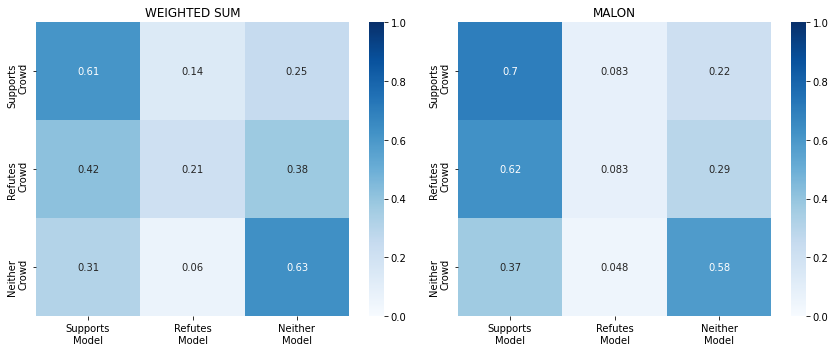

In [90]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1,2,figsize=(12,5))
cm = confusion_matrix(
    y_pred = results_multiple_df_agg_scores['WS_TE_id'],
    y_true = results_multiple_df_agg_scores['relation_maj'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax = ax[0], vmin=0, vmax=1)
g.set_title('WEIGHTED SUM')
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

cm = confusion_matrix(
    y_pred = results_multiple_df_agg_scores['MALON_TE_id'],
    y_true = results_multiple_df_agg_scores['relation_maj'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax[1], vmin=0, vmax=1)
g.set_title('MALON')
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

plt.tight_layout()

In [91]:
from sklearn.metrics import classification_report
cr = classification_report(
    y_pred = results_multiple_df_agg_scores['WS_TE_id'],
    y_true = results_multiple_df_agg_scores['relation_maj']
)
print(cr)

cr = classification_report(
    y_pred = results_multiple_df_agg_scores['MALON_TE_id'],
    y_true = results_multiple_df_agg_scores['relation_maj']
)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.61      0.71       301
           1       0.10      0.21      0.13        24
           2       0.38      0.63      0.48        84

    accuracy                           0.59       409
   macro avg       0.44      0.48      0.44       409
weighted avg       0.70      0.59      0.63       409

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       301
           1       0.06      0.08      0.07        24
           2       0.40      0.58      0.48        84

    accuracy                           0.64       409
   macro avg       0.43      0.46      0.44       409
weighted avg       0.69      0.64      0.66       409



In [92]:
cm = confusion_matrix(
    y_pred = results_multiple_df_agg_scores['WS_TE_id'],
    y_true = results_multiple_df_agg_scores['relation_maj']
)

cm = pd.DataFrame(cm)
cm.index = [x+' Crowd' for x in RELATION_LABELS[:3]]
cm.columns = [x+' Model' for x in RELATION_LABELS[:3]]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supports Model,Refutes Model,Neither Model,Total
Supports Crowd,184,41,76,301
Refutes Crowd,10,5,9,24
Neither Crowd,26,5,53,84
Total,220,51,138,409


In [93]:
results_multiple_df_agg_scores[
    ['Supports_WS_TE_prob', 'Refutes_WS_TE_prob', 'NEI_WS_TE_prob']
] = pd.DataFrame(results_multiple_df_agg_scores['WS_TE_probs'].tolist())
results_multiple_df_agg_scores.drop('WS_TE_probs', axis=1, inplace=True)
results_multiple_df_agg_scores.head()

,reference_id,relation_maj,WS_TE_label,MALON_TE_label,WS_TE_id,MALON_TE_id,Supports_WS_TE_prob,Refutes_WS_TE_prob,NEI_WS_TE_prob
0,00d15820946d663523ad6ad9316fcc27ffe4a791,0,SUPPORTS,SUPPORTS,0,0,1.850896,0.003200,0.028466
1,00d4fa84c656b876dddecc868489d261554c4ca1,2,NOT ENOUGH INFO,NOT ENOUGH INFO,2,2,0.000000,0.000000,0.000000
2,00d94a4a5c4ea458a8abe9a15682a4499114b634,2,SUPPORTS,SUPPORTS,0,0,0.990721,0.005673,0.156755
3,0280723077b22b8f9cf2c636fa889db510e0272d,0,NOT ENOUGH INFO,NOT ENOUGH INFO,2,2,0.370965,0.256742,1.603238
4,0427581cda67794db9cab34a1f91379a8004acbd,1,REFUTES,SUPPORTS,1,0,1.023166,1.557596,0.072156


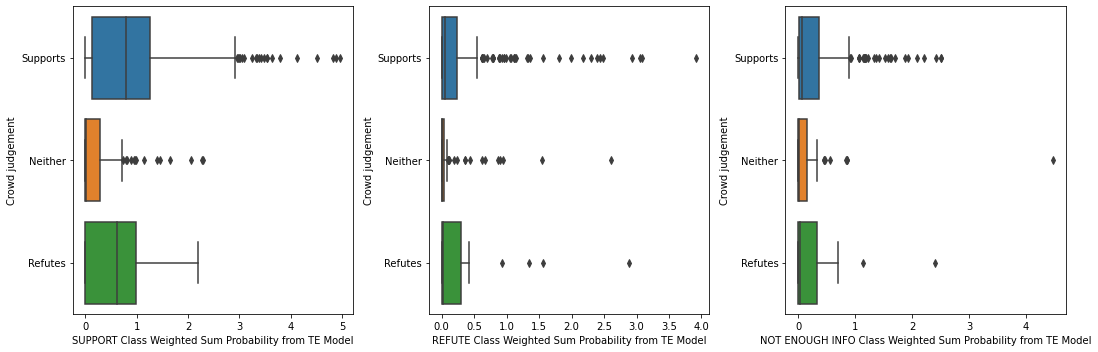

In [94]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

results_multiple_df_agg_scores['relation_maj_label'] = results_multiple_df_agg_scores['relation_maj']\
    .map({i: x for i, x in enumerate(RELATION_LABELS)})

g = sns.boxplot(
    data=results_multiple_df_agg_scores,
    x='Supports_WS_TE_prob',
    y='relation_maj_label',
    ax=ax[0]
)
g.set(xlabel='SUPPORT Class Weighted Sum Probability from TE Model',ylabel='Crowd judgement')

g = sns.boxplot(
    data=results_multiple_df_agg_scores,
    x='Refutes_WS_TE_prob',
    y='relation_maj_label',
    ax=ax[1], 
)
g.set(xlabel='REFUTE Class Weighted Sum Probability from TE Model',ylabel='Crowd judgement')

g = sns.boxplot(
    data=results_multiple_df_agg_scores,
    x='NEI_WS_TE_prob',
    y='relation_maj_label',
    ax=ax[2], 
)
g.set(xlabel='NOT ENOUGH INFO Class Weighted Sum Probability from TE Model',ylabel='Crowd judgement')

plt.tight_layout()
# Remember: This does not take into consideration evidence with non-positive EV score
# See how 

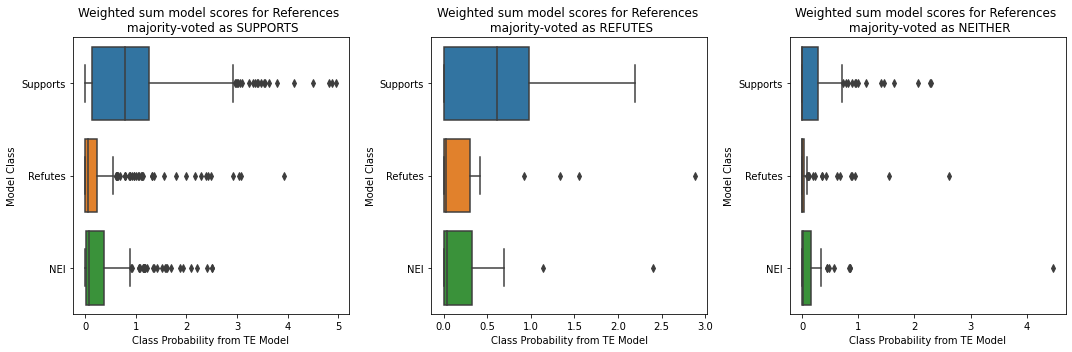

In [95]:
# These plots here are just an inverse of the plots above and illustrate the point written on the previous cell
fig, ax = plt.subplots(1,3,figsize=(15,5))

for i, cl in enumerate(['SUPPORTS','REFUTES','NEITHER']):
    g = sns.boxplot(
        data=results_multiple_df_agg_scores[
                results_multiple_df_agg_scores['relation_maj'] == i
            ][['Supports_WS_TE_prob','Refutes_WS_TE_prob','NEI_WS_TE_prob']]
            .melt(),
        y='variable',
        x='value', ax=ax[i]
    )

    g.set(
        xlabel='Class Probability from TE Model',
        ylabel='Model Class',
        yticklabels=['Supports','Refutes','NEI'],
        title=f'Weighted sum model scores for References \n majority-voted as {cl}'
    )
    
plt.tight_layout()
# Not enough data for reasonable conclusion
# Only conclusiou is that there is a slight difference between Supports and Neither, which
# The max-of-weighted-sum approach seems to explore well, given the classification performance
# seen in the confusion matrices above

### Applying hyper-models to the TE problem

In [96]:
results_evidence_grouped = results_single_df_agg_te_labels.groupby(['reference_id'])
assert (results_evidence_grouped.size() == 5).all()
results_evidence_grouped = results_evidence_grouped.agg(list)
results_evidence_grouped = results_evidence_grouped[
    ['score','Supports_prob', 'Refutes_prob', 'Neither_prob', 'evidence_len', 'netloc_agg']
]
assert results_evidence_grouped['netloc_agg'].map(lambda x : len(set(x)) == 1).all()
results_evidence_grouped.reset_index(inplace=True)

results_evidence_grouped['netloc_agg'] = results_evidence_grouped['netloc_agg'].map(lambda x : x[0])

for col in ['score','Supports_prob', 'Refutes_prob', 'Neither_prob', 'evidence_len']:
    results_evidence_grouped[[f'{col}_{i}' for i in range(5)]] = pd.DataFrame(results_evidence_grouped[col].tolist())
    results_evidence_grouped.drop(col, axis=1, inplace=True)

results_evidence_grouped = pd.merge(
    results_evidence_grouped,
    results_multiple_df_agg_scores[['reference_id','relation_maj']],
    on='reference_id'
)
    
results_evidence_grouped

,reference_id,netloc_agg,score_0,score_1,score_2,score_3,score_4,Supports_prob_0,Supports_prob_1,Supports_prob_2,...,Neither_prob_1,Neither_prob_2,Neither_prob_3,Neither_prob_4,evidence_len_0,evidence_len_1,evidence_len_2,evidence_len_3,evidence_len_4,relation_maj
0,00d15820946d663523ad6ad9316fcc27ffe4a791,deu.archinform.net,0.999882,0.536719,0.241545,0.104416,-0.126725,0.994493,0.967906,0.985370,...,0.029123,0.013725,0.049293,0.035290,103,93,245,215,158,0
1,00d4fa84c656b876dddecc868489d261554c4ca1,portal.historicenvironment.scot,-0.424648,-0.888065,-0.958842,-0.962393,-0.979610,0.004423,0.005542,0.005751,...,0.979668,0.975359,0.958768,0.970740,138,107,101,39,71,2
2,00d94a4a5c4ea458a8abe9a15682a4499114b634,portal.historicenvironment.scot,0.968321,0.103479,0.050842,0.030507,-0.057603,0.898928,0.564047,0.731945,...,0.425888,0.258408,0.183607,0.163935,247,43,147,178,119,2
3,0280723077b22b8f9cf2c636fa889db510e0272d,www.legislation.gov.au,0.603881,0.466609,0.411178,0.378457,0.370819,0.226590,0.074195,0.221267,...,0.558280,0.695422,0.826398,0.803380,34,3232,1499,901,802,0
4,0427581cda67794db9cab34a1f91379a8004acbd,OTHER,0.999870,0.851842,0.287836,0.282742,0.230629,0.987041,0.006516,0.004681,...,0.047482,0.031454,0.052212,0.017502,241,107,140,173,139,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,fa32de5f1a53eeaefbfd553190ca1ecd0ac3c8a6,www.nytimes.com,-0.434443,-0.978719,-0.984270,-0.993084,-0.993736,0.553750,0.865646,0.156935,...,0.123945,0.832222,0.963820,0.937970,371,115,33,24,217,2
405,fa3dbf3fc3baa365e9b90114a310f42b757d2809,en.wikipedia.org,0.030071,-0.321559,-0.395207,-0.398291,-0.453663,0.980284,0.033057,0.466866,...,0.873620,0.462722,0.943985,0.929559,19,91,291,28,17,2
406,facce5a2ba1e1a15fa43222fd84e4b37148bb0fc,www.nytimes.com,-0.818912,-0.828447,-0.931363,-0.931963,-0.984309,0.136958,0.084015,0.009832,...,0.609095,0.910930,0.903241,0.867153,667,585,87,121,22,2
407,fc90c58b59e8e6bd1876ecf0caf7b2953eaf2817,www.gracesguide.co.uk,0.999565,0.903917,-0.333436,-0.676959,-0.805264,0.985031,0.305690,0.020945,...,0.630428,0.008654,0.013560,0.020288,292,952,47,231,24,0


In [365]:
from sklearn.model_selection import train_test_split as tts

X = results_evidence_grouped[
    [f'{c}_{i}' for c in ['score','Supports_prob','Neither_prob','evidence_len'] for i in range(5)]
]

y = results_evidence_grouped['relation_maj']

In [366]:
X.info(), y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409 entries, 0 to 408
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   score_0          409 non-null    float64
 1   score_1          409 non-null    float64
 2   score_2          409 non-null    float64
 3   score_3          409 non-null    float64
 4   score_4          409 non-null    float64
 5   Supports_prob_0  409 non-null    float64
 6   Supports_prob_1  409 non-null    float64
 7   Supports_prob_2  409 non-null    float64
 8   Supports_prob_3  409 non-null    float64
 9   Supports_prob_4  409 non-null    float64
 10  Neither_prob_0   409 non-null    float64
 11  Neither_prob_1   409 non-null    float64
 12  Neither_prob_2   409 non-null    float64
 13  Neither_prob_3   409 non-null    float64
 14  Neither_prob_4   409 non-null    float64
 15  evidence_len_0   409 non-null    int64  
 16  evidence_len_1   409 non-null    int64  
 17  evidence_len_2  

(None, None)

#### RFC

              precision    recall  f1-score   support

           0       0.82      0.94      0.87       100
           1       0.00      0.00      0.00         9
           2       0.63      0.46      0.53        26

    accuracy                           0.79       135
   macro avg       0.48      0.47      0.47       135
weighted avg       0.73      0.79      0.75       135



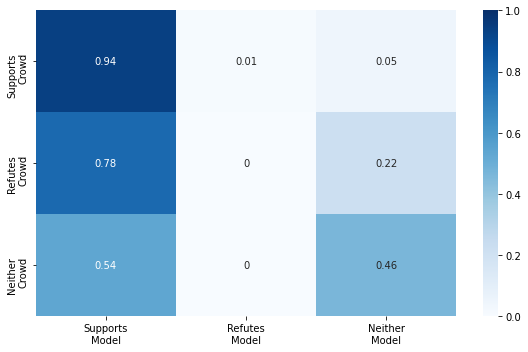

In [367]:
from sklearn.ensemble import RandomForestClassifier as RFC
from imblearn.over_sampling import BorderlineSMOTE

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33, random_state=42)

sm = BorderlineSMOTE(random_state=42)

#X_res, y_res = sm.fit_resample(
#    X_train, 
#    y_train
#) 
X_res, y_res = X_train, y_train

class_weights = dict(1/y_train.value_counts(normalize=True))

rfc = RFC(
    class_weight=class_weights,
    n_estimators = 100,
    max_depth = 4
)

rfc.fit(
    X = X_res,
    y = y_res
)

y_pred = rfc.predict(X_test)
y_true = y_test

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

#### NN

In [368]:
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Dense
#from tensorflow.keras import regularizers
#from tensorflow.keras.callbacks import EarlyStopping
#
#X_train, X_test, y_train, y_test = tts(X, y, test_size=0.66, random_state=42)
#X_val, X_test, y_val, y_test = tts(X_test, y_test, test_size=0.5, random_state=42)
#
#class_weights = dict(1/y_train.value_counts(normalize=True))
#y_train = to_categorical(y_train)
#y_val = to_categorical(y_val)
#
#regularizers = {
#    'kernel_regularizer':regularizers.L1L2(l1=1e-5, l2=1e-4),
#    'bias_regularizer':regularizers.L2(1e-4),
#    'activity_regularizer':regularizers.L2(1e-5)
#}
#
#input_layer = Input(shape=(X_train.shape[1],))
#hidden_act = 'sigmoid'
#dense = Dense(32, activation=hidden_act, **regularizers)(input_layer)
#dense = Dense(8, activation=hidden_act, **regularizers)(dense)
#output_layer = Dense(y_train.shape[1], activation='softmax')(dense)
#clf = Model(inputs=input_layer, outputs=output_layer)
#clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#
#print(clf.summary())
#
#training_lstm = clf.fit(
#    X_train,
#    y_train,
#    epochs=1000,
#    batch_size=4,
#    validation_data= (X_val, y_val),
#    callbacks=[
#        EarlyStopping(monitor='loss', patience=5),             
#    ],
#    class_weight = class_weights
#)

In [369]:
#y_pred = clf.predict(X_test)
#y_true = y_test
#
##y_pred = clf.predict(X_train)
##y_true = np.argmax(y_train, axis=1)
#
#from sklearn.metrics import confusion_matrix
#fig, ax = plt.subplots(1,1, figsize=(8,5))
#
#cm = confusion_matrix(
#    y_pred = np.argmax(y_pred, axis=1),
#    y_true = y_true,
#    normalize='true'
#)
#
#g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
#g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
#g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])
#
#plt.tight_layout()
#
#print(classification_report(
#    y_pred = np.argmax(y_pred, axis=1),
#    y_true = y_true,
#    zero_division=0
#))

#### XGBoost

C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:22:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       100
           1       0.00      0.00      0.00         9
           2       0.47      0.35      0.40        26

    accuracy                           0.73       135
   macro avg       0.42      0.42      0.41       135
weighted avg       0.68      0.73      0.70       135



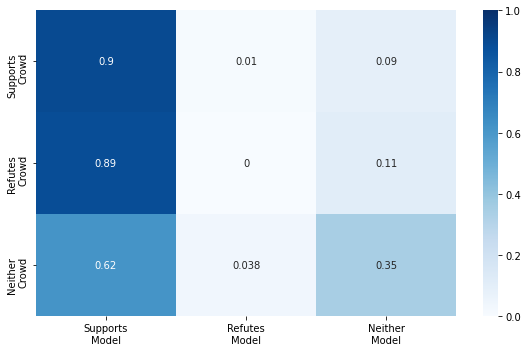

In [370]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33, random_state=42)

X_res, y_res = X_train, y_train

class_weights = dict(1/y_train.value_counts(normalize=True))
#class_weights[2] = class_weights[2]*10

xgbc = xgb.XGBClassifier(
    #class_weight=class_weights,
    n_estimators = 100,
    max_depth = 4
)

xgbc.fit(
    sample_weight = [class_weights[y] for y in y_res],
    X = X_res,
    y = y_res
)

y_pred = xgbc.predict(X_test)
y_true = y_test

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

### Multiple Evidence  VS. Supportive or NOT Two-class simpler problem

In [371]:
TWO_CLASS_LABELS = ['Supportive','NOT Supporitive']
to_two_class = lambda x : int(x != 0)

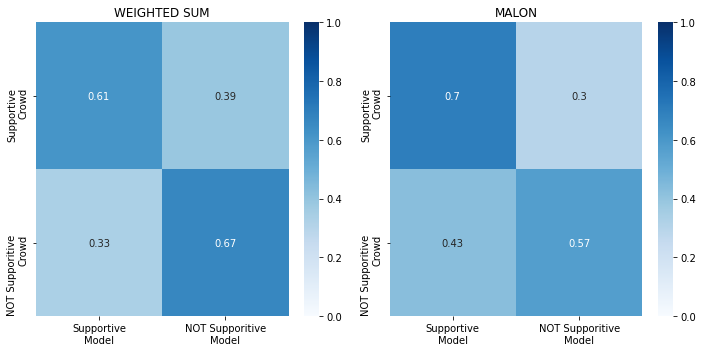

In [372]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1,2,figsize=(10,5))
cm = confusion_matrix(
    y_pred = results_multiple_df_agg_scores['WS_TE_id'].map(to_two_class),
    y_true = results_multiple_df_agg_scores['relation_maj'].map(to_two_class),
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax = ax[0], vmin=0, vmax=1)
g.set_title('WEIGHTED SUM')
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

cm = confusion_matrix(
    y_pred = results_multiple_df_agg_scores['MALON_TE_id'].map(to_two_class),
    y_true = results_multiple_df_agg_scores['relation_maj'].map(to_two_class),
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax[1], vmin=0, vmax=1)
g.set_title('MALON')
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

plt.tight_layout()

In [373]:
from sklearn.metrics import classification_report
cr = classification_report(
    y_pred = results_multiple_df_agg_scores['WS_TE_id'].map(to_two_class),
    y_true = results_multiple_df_agg_scores['relation_maj'].map(to_two_class)
)
print(cr)

cr = classification_report(
    y_pred = results_multiple_df_agg_scores['MALON_TE_id'].map(to_two_class),
    y_true = results_multiple_df_agg_scores['relation_maj'].map(to_two_class)
)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.61      0.71       301
           1       0.38      0.67      0.48       108

    accuracy                           0.63       409
   macro avg       0.61      0.64      0.60       409
weighted avg       0.72      0.63      0.65       409

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       301
           1       0.41      0.57      0.48       108

    accuracy                           0.67       409
   macro avg       0.61      0.64      0.62       409
weighted avg       0.71      0.67      0.68       409



In [374]:
cm = confusion_matrix(
    y_pred = results_multiple_df_agg_scores['WS_TE_id'].map(to_two_class),
    y_true = results_multiple_df_agg_scores['relation_maj'].map(to_two_class)
)

cm = pd.DataFrame(cm)
cm.index = [x+' Crowd' for x in TWO_CLASS_LABELS]
cm.columns = [x+' Model' for x in TWO_CLASS_LABELS]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supportive Model,NOT Supporitive Model,Total
Supportive Crowd,184,117,301
NOT Supporitive Crowd,36,72,108
Total,220,189,409


#### RFC

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       157
           1       0.59      0.42      0.49        48

    accuracy                           0.80       205
   macro avg       0.71      0.66      0.68       205
weighted avg       0.78      0.80      0.78       205



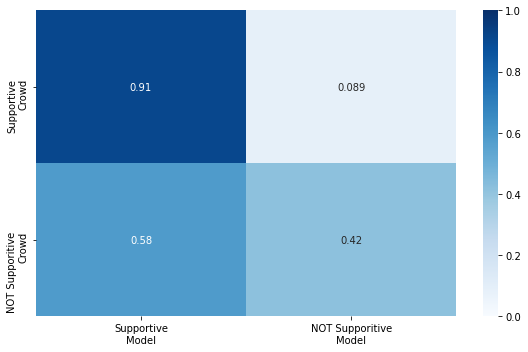

In [381]:
from sklearn.ensemble import RandomForestClassifier as RFC
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = tts(X, y.map(to_two_class), test_size=0.5, random_state=42)

pca = PCA(n_components=15)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

X_res, y_res = X_train, y_train

class_weights = dict(1/y_train.value_counts(normalize=True))
#class_weights[0] = class_weights[0]*1.5

rfc = RFC(
    class_weight=class_weights,
    n_estimators = 100,
    max_depth = 3
)

rfc.fit(
    X = X_res,
    y = y_res
)

y_pred = rfc.predict(X_test)
y_true = y_test

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

0.6441082802547771


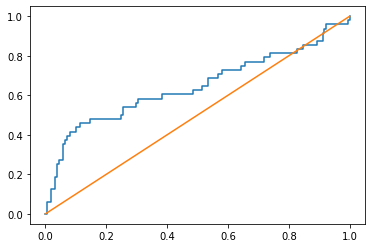

In [384]:
y_pred_prob = rfc.predict_proba(X_test)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);

In [383]:
cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true
)

cm = pd.DataFrame(cm)
cm.index = [x+' Crowd' for x in TWO_CLASS_LABELS]
cm.columns = [x+' Model' for x in TWO_CLASS_LABELS]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supportive Model,NOT Supporitive Model,Total
Supportive Crowd,143,14,157
NOT Supporitive Crowd,28,20,48
Total,171,34,205


              precision    recall  f1-score   support

           0       0.83      0.92      0.88       157
           1       0.61      0.40      0.48        48

    accuracy                           0.80       205
   macro avg       0.72      0.66      0.68       205
weighted avg       0.78      0.80      0.78       205



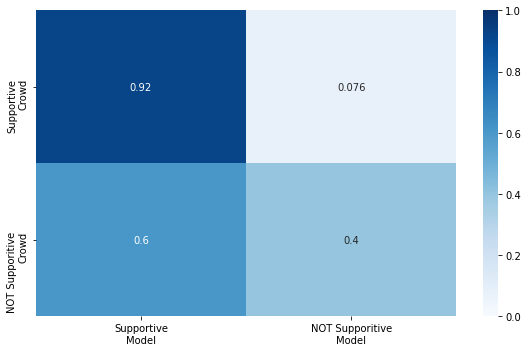

In [385]:
from sklearn.ensemble import RandomForestClassifier as RFC
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = tts(X, y.map(to_two_class), test_size=0.5, random_state=42)


X_res, y_res = X_train, y_train

class_weights = dict(1/y_train.value_counts(normalize=True))
class_weights[0] = class_weights[0]*1.5

rfc = RFC(
    class_weight=class_weights,
    n_estimators = 100,
    max_depth = 3
)

rfc.fit(
    X = X_res,
    y = y_res
)

y_pred = rfc.predict(X_test)
y_true = y_test

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

0.6541932059447984


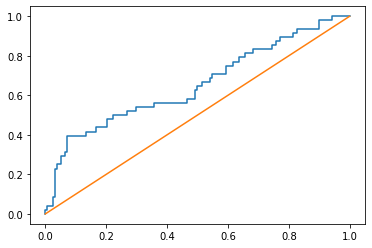

In [386]:
y_pred_prob = rfc.predict_proba(X_test)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);

<AxesSubplot:>

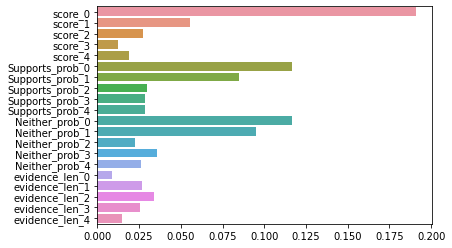

In [387]:
sns.barplot(x=rfc.feature_importances_, y=X_train.columns)

In [388]:
X_test_netlocs = pd.merge(
    X_test, results_evidence_grouped['netloc_agg'],
    how='left', left_index  = True, right_index = True
)
class_metrics_per_netloc = []
for netloc in X_test_netlocs['netloc_agg'].unique():
    X_test_netloc = X_test_netlocs[X_test_netlocs['netloc_agg'] == netloc].drop('netloc_agg',axis=1)
    y_test_netloc = y_test[X_test_netlocs['netloc_agg'] == netloc]
    y_pred = rfc.predict(X_test_netloc)
    y_true = y_test_netloc
    cf = classification_report(
        y_pred = y_pred,
        y_true = y_true,
        zero_division=0,
        output_dict = True
    )
    class_metrics_per_netloc.append({
        'netloc_agg': netloc,
        'accuracy': cf['accuracy'],
        'f1_macro': cf['macro avg']['f1-score'],
        'support': cf['macro avg']['support'],
    })
class_metrics_per_netloc = pd.DataFrame(class_metrics_per_netloc)

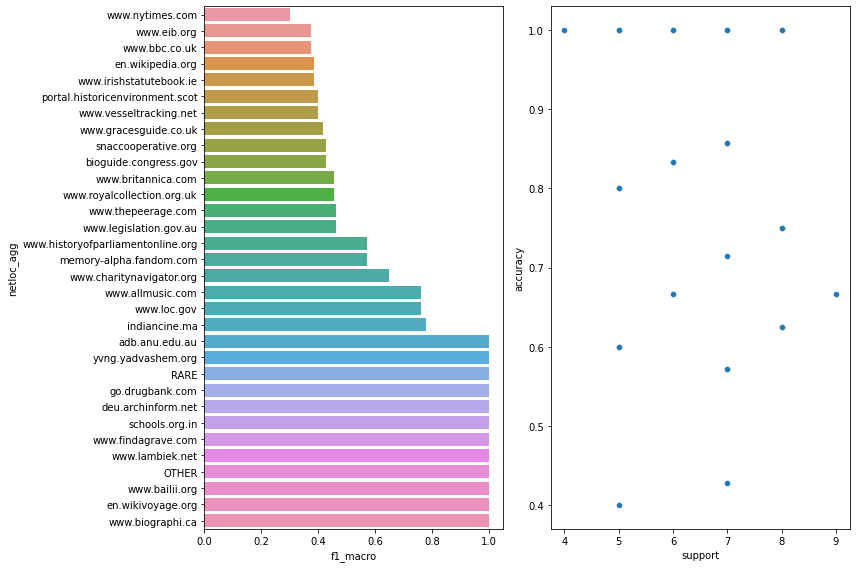

In [389]:
fig, ax = plt.subplots(1, 2, figsize = (12,8))

sns.barplot(
    data=class_metrics_per_netloc,
    y = 'netloc_agg',
    x='f1_macro',
    order=class_metrics_per_netloc.sort_values('f1_macro')['netloc_agg'],
    ax=ax[0]
)

sns.scatterplot(
    data=class_metrics_per_netloc,
    y ='accuracy',
    x='support',
    ax=ax[1]
)

plt.tight_layout()

#### NN

In [390]:
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Dense
#from tensorflow.keras import regularizers
#
#from tensorflow.keras.callbacks import EarlyStopping
#
#X_train, X_test, y_train, y_test = tts(X, y.map(to_two_class), test_size=0.5, random_state=42)
#X_val, X_test, y_val, y_test = tts(X_test, y_test, test_size=0.5, random_state=42)
#
#pca = PCA(n_components=15)
#sm = BorderlineSMOTE(random_state=42)
#
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)
#X_val = pca.transform(X_val)
#
#X_res, y_res = sm.fit_resample(
#    X_train, 
#    y_train
#)
#X_res, y_res = X_train, y_train
#
#class_weights = dict(1/y_train.value_counts(normalize=True))
#
#y_res = to_categorical(y_res)
#y_val = to_categorical(y_val)
#
#regularizers = {
#    'kernel_regularizer':regularizers.L1L2(l1=1e-5, l2=1e-4),
#    'bias_regularizer':regularizers.L2(1e-4),
#    'activity_regularizer':regularizers.L2(1e-5)
#}
#
#input_layer = Input(shape=(X_res.shape[1],))
#hidden_act = 'relu'
#dense = Dense(16, activation=hidden_act, **regularizers)(input_layer)
#dense = Dense(32, activation=hidden_act, **regularizers)(dense)
#dense = Dense(64, activation=hidden_act, **regularizers)(dense)
#dense = Dense(32, activation=hidden_act, **regularizers)(dense)
#dense = Dense(16, activation=hidden_act, **regularizers)(dense)
#dense = Dense(8, activation=hidden_act, **regularizers)(dense)
#output_layer = Dense(y_res.shape[1], activation='softmax')(dense)
#clf = Model(inputs=input_layer, outputs=output_layer)
#clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#print(clf.summary())
#
#training_lstm = clf.fit(
#    X_res,
#    y_res,
#    epochs=100,
#    batch_size=4,
#    validation_data= (X_val, y_val),
#    callbacks=[
#        EarlyStopping(monitor='val_loss', patience=5),             
#    ],
#    class_weight = class_weights
#)
#
#y_pred = clf.predict(X_test)
#y_true = y_test
#
#from sklearn.metrics import confusion_matrix
#fig, ax = plt.subplots(1,1, figsize=(8,5))
#
#cm = confusion_matrix(
#    y_pred = np.argmax(y_pred, axis=1),
#    y_true = y_true,
#    normalize='true'
#)
#
#g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
#g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
#g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])
#
#plt.tight_layout()
#
#print(classification_report(
#    y_pred = np.argmax(y_pred, axis=1),
#    y_true = y_true,
#    zero_division=0
#))

#### XGBoost

C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:30:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       157
           1       0.49      0.44      0.46        48

    accuracy                           0.76       205
   macro avg       0.66      0.65      0.65       205
weighted avg       0.75      0.76      0.76       205



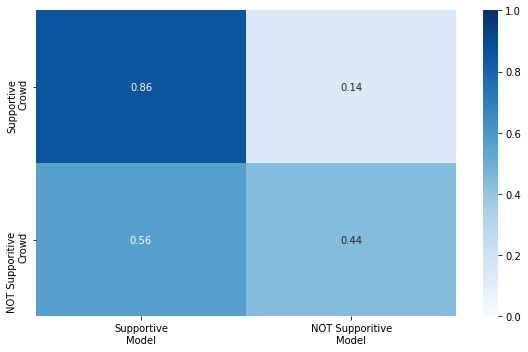

In [405]:
X_train, X_test, y_train, y_test = tts(X, y.map(to_two_class), test_size=0.5, random_state=42)

X_res, y_res = X_train, y_train

class_weights = dict(1/y_train.value_counts(normalize=True))
#class_weights[1] = class_weights[1]*1000

xgbc = xgb.XGBClassifier(
    #class_weight=class_weights,
    #n_estimators = 100,
    #max_depth = 3
)

xgbc.fit(
    sample_weight = [class_weights[y] for y in y_res],
    X = X_res,
    y = y_res
)

y_pred = xgbc.predict(X_test)
y_true = y_test

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,1, figsize=(8,5))

cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true,
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

plt.tight_layout()

print(classification_report(
    y_pred = y_pred,
    y_true = y_true,
    zero_division=0
))

0.6625530785562632


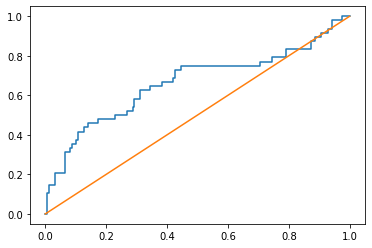

In [406]:
y_pred_prob = xgbc.predict_proba(X_test)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);

In [139]:
# The RELEVANT OR NOT judgement is not AS necessary for the recommendation of an entire page. The goal is for the
# page(reference) to be tested for supportiveness. Individual entries can be judged for supportiveness AND relevancy, as
# we DO care if individual sentences can be refuting.

# Comparing crowd judgements (multi task), TE model outputs, and hypermodel TE (three and two class tasks) final classes to GROUND TRUTH

Ground Truth here refers to a manual annotation of each reference/claim pair to investigate whether they are supportive of the information or not.

Crowd judgements only received 5 most-relevant selected sentences by a sentence-selector model. So it would be nice to see how it relates to true labels.

Model outputs are the evidence scores + the TE class probabilities.

Hypermodel final classes are the outputs from the random forest classifiers used here.

Why we need this: *Since all this comparison is done BASED ON the 5-highest scoring "segments of text" extracted from a reference, we need to ground this to "anywhere in the reference".* In other words, we are **assuming** that, *if there is any relevant segment of text in the reference, it is extracted within these 5-highest-scoring segments*.

I suspect this: The tool works quite well for references written in long-text or running-text format. This is because, if there is relevant segments of text, they are very likely to have been extracted. The tool works not so much for when the relevant parts are in table/header fields or when inferenced. This is because the relevant portions of text/information are *less likely* to be extracted within the 5-highest-scoring portions of text.

Steps:
1. Annotate websites with classes:
    1. Relevant
        1. Relevancy on written text
        2. Relevancy on written text dependant on display position / headers
        3. Relevancy not on written text
        4. Relevancy inferred (might be the joined as not on written text)
    2. Not Relevant
        1. Refuting
        2. Unrelated
2. Join these labels (multi-level) on all intermediate datasets above used for classification analysis. Use them as true labels.
3. Compare annotated classes to agg multi-evidence crowd judgements
4. Compare annotated classes to agg multi-evidence TE model outputs (WS/ML)
5. Compare annotated classes to agg multi-evidence results from hyper models
    1. Do so and split accuracy by netloc
    2. Check accuracy by text size

## Data Annotation

In [140]:
#unique_references_for_manual_annotation = results_multiple_df[
#    ['reference_id','claim_id','affirmation']
#].drop_duplicates().reset_index(drop=True)
#
#claim_data = pd.read_csv('../data/verbalised_claims_df_final.csv')
#
#unique_references_for_manual_annotation = pd.merge(
#    unique_references_for_manual_annotation,
#    claim_data[['reference_id','claim_id','entity_label','property_label','object_label','final_url']],
#    on = ['reference_id','claim_id']
#)

In [141]:
#unique_references_for_manual_annotation.to_csv('../data/unique_references_for_manual_annotation.csv', index=None)

1. Supportive
    1. Support explicitly stated on written text in natural language
    2. Support explicitly stated on written text dependant on display position or headers (not fluent natural language)
    3. Support explicitly stated but not on written text (images, videos, etc)
    4. Support NOT explicitly stated (inferred)
2. Not Supportive
    1. Refuting (Affirmation is wrong)
    2. Unrelated (No information found)

In [142]:
unique_references_for_manual_annotation = pd.read_csv(
    '../data/unique_references_for_manual_annotation.csv'
)
unique_references_for_manual_annotation

,index,reference_id,claim_id,affirmation,entity_label,property_label,object_label,final_url,manual_label
0,0,5b14a71742a09446d03a95c9426a659cda3bad6f,Q62637091$C1F95944-8A83-4901-80FF-931DB0F448EC,Priscila Farias was born in 1964.,Priscila Farias,date of birth,1964,https://www.lambiek.net/artists/f/farias_prisc...,1.A.
1,1,15bea5900b8dda1bcf6f622348d80ef5a5b7b71e,Q5798066$60E7A7BB-9549-4D96-8395-A4875F72E5C5,Daniel Diaz was born on 14/09/1966.,Daniel Diaz,date of birth,14/09/1966,https://www.lambiek.net/artists/d/dani-the-o.htm,1.B.
2,2,74188de4f031ca41e7927959f818816dbdfc29af,Q99607134$2818F414-8F79-4677-8D9F-AD9B7E977A4A,The Value Added Tax (Section 55A) (Specified S...,The Value Added Tax (Section 55A) (Specified S...,publication date,2016,https://www.bailii.org/uk/legis/num_reg/2016/u...,1.B.
3,3,11513fdd381730dfa38bf9fb5a724a129dc8480c,Q99686151$4E1BDE62-B95E-4C12-92F2-192FB49E6449,The Proscribed Organisations (Name Changes) Or...,The Proscribed Organisations (Name Changes) Or...,publication date,2011,https://www.bailii.org/uk/legis/num_reg/2011/u...,1.B.
4,4,99415d84e2b5632a86eaa925c4f7ae791816621e,Q4815670$2BFBD30C-D13D-4A04-A76C-F4C60574852B,Athos Bulcão died on 31/07/2008.,Athos Bulcão,date of death,31/07/2008,http://archive.ph/m6yCn,2.B.
...,...,...,...,...,...,...,...,...,...
404,404,c30a95bb7d44805e1d654b05b5f0bc31a49d8123,Q14650496$409733e3-46f4-7c38-ceaf-cb5e4f40c573,Furious 7 is an action film.,Furious 7,genre,action film,http://archive.ph/Pf2Dq,1.B.
405,405,d2adcd8a228546ea69fec3002a066217cce0e97b,Q64460267$F6CEBC9F-F532-403F-83E9-CB2CD486C1D8,Naravoor Lps is located in Kannur district.,Naravoor Lps,is located in,Kannur district,https://schools.org.in/Kannur/32020700608/,1.A.
406,406,080da364904fb2c94058b444213026d02570411d,Q63156797$F98C48C4-F906-4958-82A1-6E0EA56EDE5E,William Welham Clarke died in 1877.,William Welham Clarke,date of death,1877,https://www.gracesguide.co.uk/William_Welham_C...,1.A.
407,407,2dc9ec5431b25c65b58b5ef7df8fd975ce042d73,Q64552403$0CAB500E-D30B-4631-A385-AF4EB850C885,Gmlps Unnikulam is located in Kozhikode district.,Gmlps Unnikulam,is located in,Kozhikode district,https://schools.org.in/kozhikode/32040100425/,1.A.


<AxesSubplot:xlabel='index', ylabel='manual_label'>

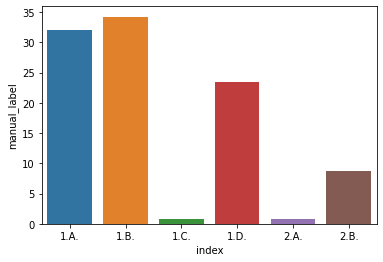

In [143]:
sns.barplot(
    data = unique_references_for_manual_annotation['manual_label']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index(),
    x = 'index', y='manual_label',
    order= ['1.A.', '1.B.', '1.C.', '1.D.', '2.A.', '2.B.']
)

## Manual labels VS. aggregated crowd judgements

In [407]:
# Manual annotations
unique_references_for_manual_annotation[['reference_id', 'manual_label']].head()

,reference_id,manual_label
0,5b14a71742a09446d03a95c9426a659cda3bad6f,1.A.
1,15bea5900b8dda1bcf6f622348d80ef5a5b7b71e,1.B.
2,74188de4f031ca41e7927959f818816dbdfc29af,1.B.
3,11513fdd381730dfa38bf9fb5a724a129dc8480c,1.B.
4,99415d84e2b5632a86eaa925c4f7ae791816621e,2.B.


In [408]:
# Aggregated crowd judgements
results_multiple_df_agg.reset_index()[['reference_id', 'relation_maj','relation_maj_tie']].head()

,reference_id,relation_maj,relation_maj_tie
0,00d15820946d663523ad6ad9316fcc27ffe4a791,0,False
1,00d4fa84c656b876dddecc868489d261554c4ca1,2,False
2,00d94a4a5c4ea458a8abe9a15682a4499114b634,2,False
3,0280723077b22b8f9cf2c636fa889db510e0272d,0,False
4,0427581cda67794db9cab34a1f91379a8004acbd,1,False


In [409]:
manual_vs_crowd_df = pd.merge(
    unique_references_for_manual_annotation[['reference_id', 'manual_label']],
    results_multiple_df_agg.reset_index()[['reference_id', 'relation_maj','relation_maj_tie']],
    on = 'reference_id'
)
manual_vs_crowd_df_untied = manual_vs_crowd_df[~manual_vs_crowd_df['relation_maj_tie']]

In [410]:
from sklearn.metrics import cohen_kappa_score as ckappa

manual_annot_to_crowd_label = {
    '1.A.': 0, '1.B.': 0, '1.C.': 0, '1.D.': 0,
    '2.A.': 1, '2.B.': 2
}

ckappa(
    manual_vs_crowd_df_untied.manual_label.map(manual_annot_to_crowd_label),
    manual_vs_crowd_df_untied.relation_maj
)

0.3574588769143505

In [411]:
print(classification_report(
    manual_vs_crowd_df_untied.manual_label.map(manual_annot_to_crowd_label),
    manual_vs_crowd_df_untied.relation_maj
))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       322
           1       0.10      0.50      0.17         2
           2       0.31      0.73      0.44        30

    accuracy                           0.82       354
   macro avg       0.46      0.69      0.50       354
weighted avg       0.92      0.82      0.85       354



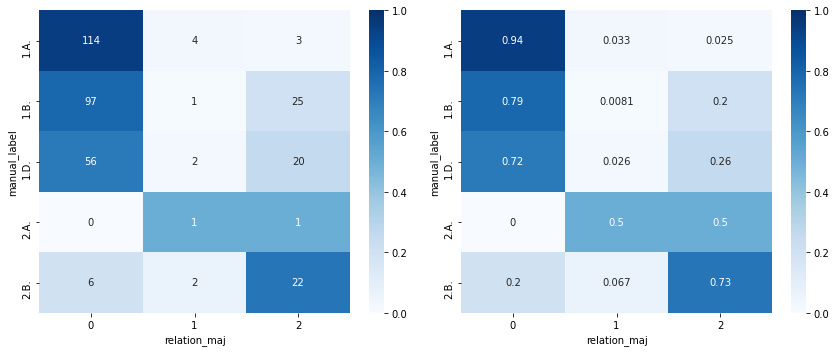

In [412]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ct = pd.crosstab(
    manual_vs_crowd_df_untied['manual_label'],
    manual_vs_crowd_df_untied['relation_maj']
)

sns.heatmap(
    ct.div(ct.sum(axis=1), axis=0), 
    annot=ct, 
    cmap='Blues', 
    fmt='d',
    vmin=0, vmax=1,
    ax=ax[0]
)

sns.heatmap(
    ct.div(ct.sum(axis=1), axis=0), 
    annot=True, 
    cmap='Blues', 
    vmin=0, vmax=1,
    ax=ax[1]
)

plt.tight_layout()

In [413]:
#MANUAL_CAT = '2.B.'
#CROWD_CAT = 1
#
#ct_cross_category = manual_vs_crowd_df_untied[
#    (manual_vs_crowd_df_untied['manual_label'] == MANUAL_CAT) &\
#    (manual_vs_crowd_df_untied['relation_maj'] == CROWD_CAT)
#]
#
#unique_references_for_manual_annotation[
#    unique_references_for_manual_annotation.reference_id.isin(ct_cross_category.reference_id)
#]

## Manual labels VS.  Agg. TE labels (WS + ML)

This is just like 7.4, except using the manual labels instead of the aggregated crowd annotations.

In [414]:
manual_vs_crowd_df['manual_label_relation'] = manual_vs_crowd_df.manual_label.map(manual_annot_to_crowd_label)
manual_vs_crowd_df

,reference_id,manual_label,relation_maj,relation_maj_tie,manual_label_relation
0,5b14a71742a09446d03a95c9426a659cda3bad6f,1.A.,0,False,0
1,15bea5900b8dda1bcf6f622348d80ef5a5b7b71e,1.B.,0,False,0
2,74188de4f031ca41e7927959f818816dbdfc29af,1.B.,0,False,0
3,11513fdd381730dfa38bf9fb5a724a129dc8480c,1.B.,0,False,0
4,99415d84e2b5632a86eaa925c4f7ae791816621e,2.B.,2,False,2
...,...,...,...,...,...
404,c30a95bb7d44805e1d654b05b5f0bc31a49d8123,1.B.,0,False,0
405,d2adcd8a228546ea69fec3002a066217cce0e97b,1.A.,0,False,0
406,080da364904fb2c94058b444213026d02570411d,1.A.,0,False,0
407,2dc9ec5431b25c65b58b5ef7df8fd975ce042d73,1.A.,0,False,0


In [415]:
manual_vs_crowd_df_scores = pd.merge(
    manual_vs_crowd_df.reset_index(),
    te_df_pre_join,
    on=['reference_id'],
    how='left'
)[[
    'reference_id', 'manual_label', 'manual_label_relation', 'WS_TE_probs',
   'WS_TE_label', 'MALON_TE_label', 'WS_TE_id', 'MALON_TE_id'
]]
manual_vs_crowd_df_scores.head()

,reference_id,manual_label,manual_label_relation,WS_TE_probs,WS_TE_label,MALON_TE_label,WS_TE_id,MALON_TE_id
0,5b14a71742a09446d03a95c9426a659cda3bad6f,1.A.,0,"[0.9960011244, 0.0014165407, 0.0024456519]",SUPPORTS,SUPPORTS,0,0
1,15bea5900b8dda1bcf6f622348d80ef5a5b7b71e,1.B.,0,"[0.5644102097, 0.3127562404, 0.0403452292]",SUPPORTS,SUPPORTS,0,0
2,74188de4f031ca41e7927959f818816dbdfc29af,1.B.,0,"[3.7863833904, 0.0230747759, 0.2821960747]",SUPPORTS,SUPPORTS,0,0
3,11513fdd381730dfa38bf9fb5a724a129dc8480c,1.B.,0,"[2.4173943996, 0.025141583800000002, 0.2366851...",SUPPORTS,SUPPORTS,0,0
4,99415d84e2b5632a86eaa925c4f7ae791816621e,2.B.,2,"[0, 0, 0]",NOT ENOUGH INFO,NOT ENOUGH INFO,2,2


### Overall

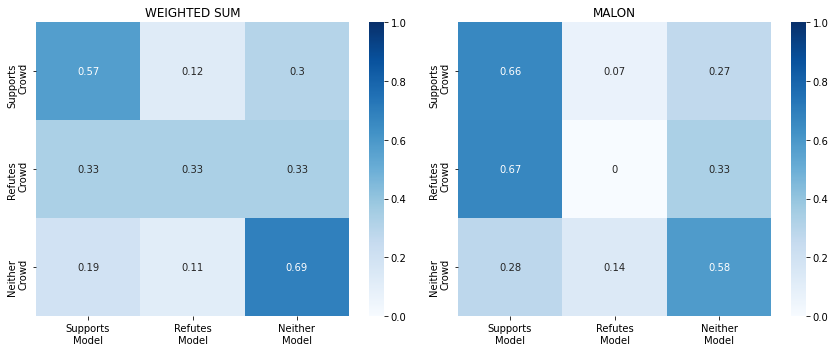

In [416]:
#from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1,2,figsize=(12,5))
cm = confusion_matrix(
    y_true = manual_vs_crowd_df_scores['manual_label_relation'],
    y_pred = manual_vs_crowd_df_scores['WS_TE_id'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax = ax[0], vmin=0, vmax=1)
g.set_title('WEIGHTED SUM')
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

cm = confusion_matrix(
    y_true = manual_vs_crowd_df_scores['manual_label_relation'],
    y_pred = manual_vs_crowd_df_scores['MALON_TE_id'],
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax[1], vmin=0, vmax=1)
g.set_title('MALON')
g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

plt.tight_layout()

In [417]:
#from sklearn.metrics import classification_report
cr = classification_report(
    y_true = manual_vs_crowd_df_scores['manual_label_relation'],
    y_pred = manual_vs_crowd_df_scores['WS_TE_id'],
)
print(cr)

cr = classification_report(
    y_true = manual_vs_crowd_df_scores['manual_label_relation'],
    y_pred = manual_vs_crowd_df_scores['MALON_TE_id'],
)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.57      0.72       370
           1       0.02      0.33      0.04         3
           2       0.18      0.69      0.29        36

    accuracy                           0.58       409
   macro avg       0.39      0.53      0.35       409
weighted avg       0.89      0.58      0.68       409

              precision    recall  f1-score   support

           0       0.95      0.66      0.78       370
           1       0.00      0.00      0.00         3
           2       0.17      0.58      0.27        36

    accuracy                           0.65       409
   macro avg       0.38      0.42      0.35       409
weighted avg       0.88      0.65      0.73       409



In [418]:
cm = confusion_matrix(
    y_true = manual_vs_crowd_df_scores['manual_label_relation'],
    y_pred = manual_vs_crowd_df_scores['WS_TE_id'],
)

cm = pd.DataFrame(cm)
cm.index = [x+' Crowd' for x in RELATION_LABELS[:3]]
cm.columns = [x+' Model' for x in RELATION_LABELS[:3]]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
print('WS')
print(cm)

cm = confusion_matrix(
    y_true = manual_vs_crowd_df_scores['manual_label_relation'],
    y_pred = manual_vs_crowd_df_scores['MALON_TE_id'],
)

cm = pd.DataFrame(cm)
cm.index = [x+' Crowd' for x in RELATION_LABELS[:3]]
cm.columns = [x+' Model' for x in RELATION_LABELS[:3]]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
print()
print('MALON')
print(cm)

WS
                Supports Model  Refutes Model  Neither Model  Total
Supports Crowd             212             46            112    370
Refutes Crowd                1              1              1      3
Neither Crowd                7              4             25     36
Total                      220             51            138    409

MALON
                Supports Model  Refutes Model  Neither Model  Total
Supports Crowd             245             26             99    370
Refutes Crowd                2              0              1      3
Neither Crowd               10              5             21     36
Total                      257             31            121    409


### Sub-labels (A-D)

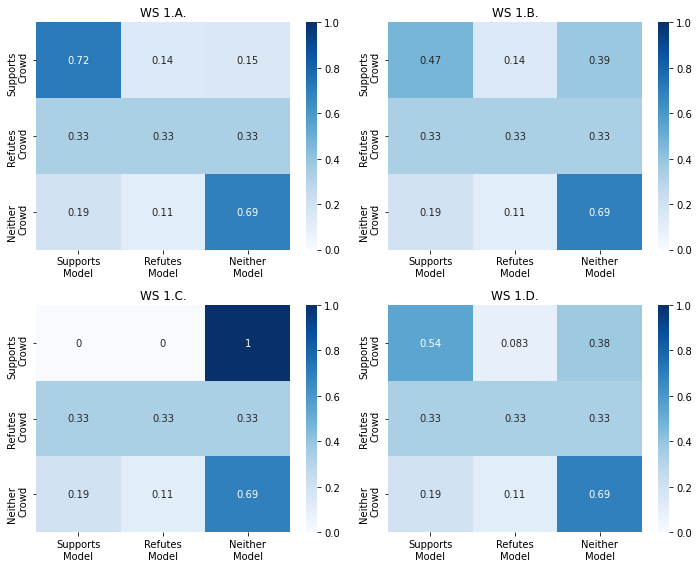

In [419]:
fig, ax = plt.subplots(2,2,figsize=(10,8))

for i, l in enumerate(['1.A.','1.B.','1.C.', '1.D.']):
    manual_vs_crowd_df_scores_l = manual_vs_crowd_df_scores[
        manual_vs_crowd_df_scores['manual_label'].isin(['2.A.', '2.B.', l])
    ]
    cm = confusion_matrix(
        y_true = manual_vs_crowd_df_scores_l['manual_label_relation'],
        y_pred = manual_vs_crowd_df_scores_l['WS_TE_id'],
        normalize='true'
    )

    g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax[i//2,i%2], vmin=0, vmax=1)
    g.set_title(f'WS {l}')
    g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
    g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

plt.tight_layout()

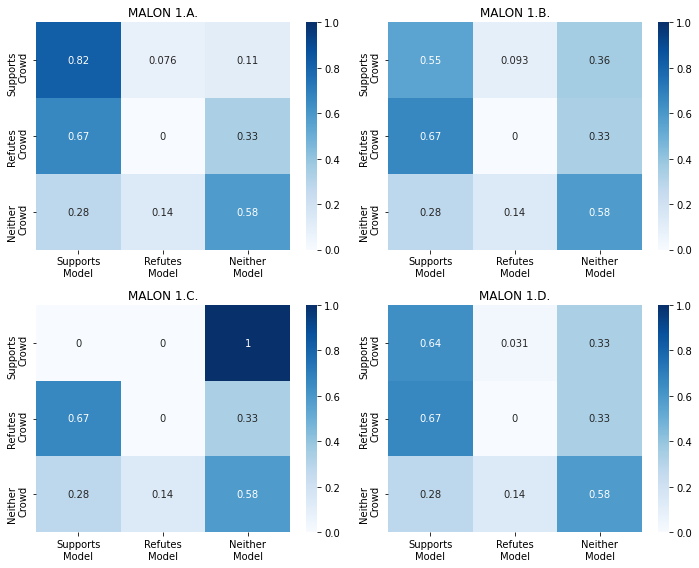

In [420]:
fig, ax = plt.subplots(2,2,figsize=(10,8))

for i, l in enumerate(['1.A.','1.B.','1.C.', '1.D.']):
    manual_vs_crowd_df_scores_l = manual_vs_crowd_df_scores[
        manual_vs_crowd_df_scores['manual_label'].isin(['2.A.', '2.B.', l])
    ]
    cm = confusion_matrix(
        y_true = manual_vs_crowd_df_scores_l['manual_label_relation'],
        y_pred = manual_vs_crowd_df_scores_l['MALON_TE_id'],
        normalize='true'
    )

    g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax[i//2,i%2], vmin=0, vmax=1)
    g.set_title(f'MALON {l}')
    g.set_xticklabels([x+'\nModel' for x in RELATION_LABELS[:3]])
    g.set_yticklabels([x+'\nCrowd' for x in RELATION_LABELS[:3]])

plt.tight_layout()

## Manual labels VS. Two-class TE hyper-model

### Overall

In [421]:
TWO_CLASS_LABELS = ['Supportive','NOT Supportive']
to_two_class = lambda x : int(x != 0)

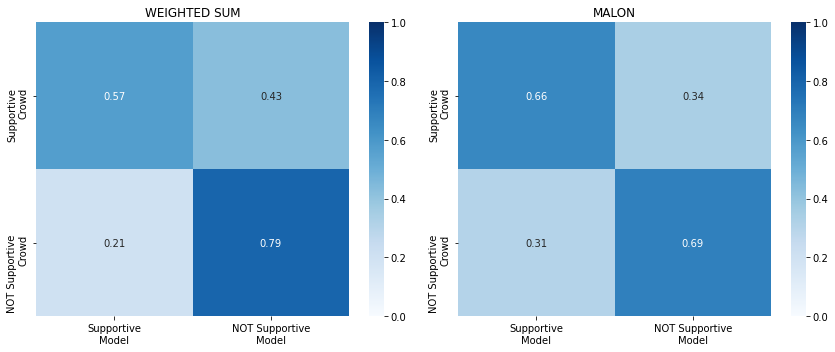

In [422]:
#from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1,2,figsize=(12,5))
cm = confusion_matrix(
    y_true = manual_vs_crowd_df_scores['manual_label_relation'].map(to_two_class),
    y_pred = manual_vs_crowd_df_scores['WS_TE_id'].map(to_two_class),
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax = ax[0], vmin=0, vmax=1)
g.set_title('WEIGHTED SUM')
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

cm = confusion_matrix(
    y_true = manual_vs_crowd_df_scores['manual_label_relation'].map(to_two_class),
    y_pred = manual_vs_crowd_df_scores['MALON_TE_id'].map(to_two_class),
    normalize='true'
)

g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax[1], vmin=0, vmax=1)
g.set_title('MALON')
g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

plt.tight_layout()

In [423]:
#from sklearn.metrics import classification_report
cr = classification_report(
    y_true = manual_vs_crowd_df_scores['manual_label_relation'].map(to_two_class),
    y_pred = manual_vs_crowd_df_scores['WS_TE_id'].map(to_two_class),
)
print('WS')
print(cr)

cr = classification_report(
    y_true = manual_vs_crowd_df_scores['manual_label_relation'].map(to_two_class),
    y_pred = manual_vs_crowd_df_scores['MALON_TE_id'].map(to_two_class),
)
print('MALON')
print(cr)

WS
              precision    recall  f1-score   support

           0       0.96      0.57      0.72       370
           1       0.16      0.79      0.27        39

    accuracy                           0.59       409
   macro avg       0.56      0.68      0.50       409
weighted avg       0.89      0.59      0.68       409

MALON
              precision    recall  f1-score   support

           0       0.95      0.66      0.78       370
           1       0.18      0.69      0.28        39

    accuracy                           0.67       409
   macro avg       0.57      0.68      0.53       409
weighted avg       0.88      0.67      0.73       409



In [424]:
cm = confusion_matrix(
    y_true = manual_vs_crowd_df_scores['manual_label_relation'].map(to_two_class),
    y_pred = manual_vs_crowd_df_scores['WS_TE_id'].map(to_two_class),
)

cm = pd.DataFrame(cm)
cm.index = [x+' Crowd' for x in TWO_CLASS_LABELS]
cm.columns = [x+' Model' for x in TWO_CLASS_LABELS]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
print('WS')
print(cm)

cm = confusion_matrix(
    y_true = manual_vs_crowd_df_scores['manual_label_relation'].map(to_two_class),
    y_pred = manual_vs_crowd_df_scores['MALON_TE_id'].map(to_two_class),
)

cm = pd.DataFrame(cm)
cm.index = [x+' Crowd' for x in TWO_CLASS_LABELS]
cm.columns = [x+' Model' for x in TWO_CLASS_LABELS]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
print()
print('MALON')
print(cm)

WS
                      Supportive Model  NOT Supportive Model  Total
Supportive Crowd                   212                   158    370
NOT Supportive Crowd                 8                    31     39
Total                              220                   189    409

MALON
                      Supportive Model  NOT Supportive Model  Total
Supportive Crowd                   245                   125    370
NOT Supportive Crowd                12                    27     39
Total                              257                   152    409


In [425]:
results_evidence_grouped_manual = pd.merge(
    results_evidence_grouped,
    manual_vs_crowd_df_scores[['reference_id', 'manual_label', 'manual_label_relation']],
    on = 'reference_id'
)

X_manual = results_evidence_grouped_manual[
    [f'{c}_{i}' for c in ['score','Supports_prob','Neither_prob','evidence_len'] for i in range(5)]
]

y_manual = results_evidence_grouped_manual['manual_label_relation']

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       186
           1       0.31      0.42      0.36        19

    accuracy                           0.86       205
   macro avg       0.62      0.66      0.64       205
weighted avg       0.88      0.86      0.87       205



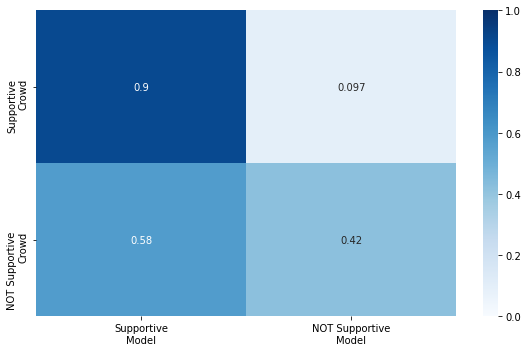

In [446]:
from sklearn.ensemble import RandomForestClassifier as RFC
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = tts(X_manual, y_manual.map(to_two_class), test_size=0.5, random_state=42)

def train_test_RFC(X_train, X_test, y_train, y_test, weight_0, print_cm=True, print_cr=True):

    class_weights = dict(1/y_train.value_counts(normalize=True))
    class_weights[0] = class_weights[0]*weight_0

    rfc = RFC(
        class_weight=class_weights,
        n_estimators = 100,
        max_depth = 3
    )

    rfc.fit(
        X = X_train,
        y = y_train
    )

    y_pred = rfc.predict(X_test)
    y_true = y_test
 
    if print_cm:
        cm = confusion_matrix(
            y_pred = y_pred,
            y_true = y_true,
            normalize='true'
        )

        fig, ax = plt.subplots(1,1, figsize=(8,5))
        g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
        g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
        g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

        plt.tight_layout()
    if print_cr:
        print(classification_report(
            y_pred = y_pred,
            y_true = y_true,
            zero_division=0
        ))
    return classification_report(
        y_pred = y_pred,
        y_true = y_true,
        zero_division=0,
        output_dict = True
    ), rfc, y_pred, y_true

_, rfc, y_pred, y_true = train_test_RFC(X_train, X_test, y_train, y_test, 0.8)

0.7821165817770233


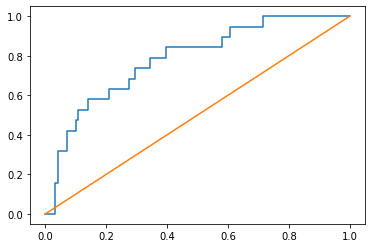

In [447]:
y_pred_prob = rfc.predict_proba(X_test)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);

In [427]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outputs = []
for train_index, test_index in skf.split(X_manual, y_manual.map(to_two_class)):
    X_train, X_test = X_manual.iloc[train_index], X_manual.iloc[test_index]
    y_train, y_test = y_manual.iloc[train_index].map(to_two_class), y_manual.iloc[test_index].map(to_two_class)
    
    outputs.append(train_test_RFC(
        X_train, X_test,
        y_train, y_test,
        0.8, print_cm=False, print_cr=False
    )[0])

print('0 - recall - precision - f1')
print(np.mean([output['0']['recall'] for output in outputs]))
print(np.mean([output['0']['precision'] for output in outputs]))
print(np.mean([output['0']['f1-score'] for output in outputs]))
print('1 - recall - precision - f1')
print(np.mean([output['1']['recall'] for output in outputs]))
print(np.mean([output['1']['precision'] for output in outputs]))
print(np.mean([output['1']['f1-score'] for output in outputs]))
print('acc - macro f1')
print(np.mean([output['accuracy'] for output in outputs]))
print(np.mean([output['macro avg']['f1-score'] for output in outputs]))

0 - recall - precision - f1
0.8054054054054054
0.9320944811108746
0.8634605733930278
1 - recall - precision - f1
0.4392857142857142
0.18276942355889725
0.25675971538040504
acc - macro f1
0.7701294790725685
0.5601101443867165


In [428]:
cm = confusion_matrix(
    y_pred = y_pred,
    y_true = y_true
)

cm = pd.DataFrame(cm)
cm.index = [x+' Crowd' for x in TWO_CLASS_LABELS]
cm.columns = [x+' Model' for x in TWO_CLASS_LABELS]
cm = pd.concat(
    [cm, cm.agg(sum, axis=1).rename('Total')],
    axis=1
)
cm = pd.concat(
    [cm, pd.DataFrame([cm.agg(sum, axis=0).to_dict()]).rename(index={0: 'Total'})],
    axis=0, names=['x','y']
)
cm

,Supportive Model,NOT Supportive Model,Total
Supportive Crowd,166,20,186
NOT Supportive Crowd,10,9,19
Total,176,29,205


<AxesSubplot:>

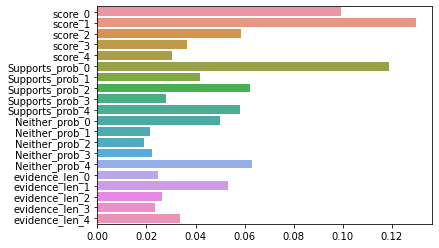

In [429]:
sns.barplot(x=rfc.feature_importances_, y=X_train.columns)

In [430]:
X_test_netlocs = pd.merge(
    X_test, results_evidence_grouped['netloc_agg'],
    how='left', left_index  = True, right_index = True
)
class_metrics_per_netloc = []
for netloc in X_test_netlocs['netloc_agg'].unique():
    X_test_netloc = X_test_netlocs[X_test_netlocs['netloc_agg'] == netloc].drop('netloc_agg',axis=1)
    y_test_netloc = y_test[X_test_netlocs['netloc_agg'] == netloc]
    y_pred = rfc.predict(X_test_netloc)
    y_true = y_test_netloc
    cf = classification_report(
        y_pred = y_pred,
        y_true = y_true,
        zero_division=0,
        output_dict = True
    )
    class_metrics_per_netloc.append({
        'netloc_agg': netloc,
        'accuracy': cf['accuracy'],
        'f1_macro': cf['macro avg']['f1-score'],
        'support': cf['macro avg']['support'],
    })
class_metrics_per_netloc = pd.DataFrame(class_metrics_per_netloc)

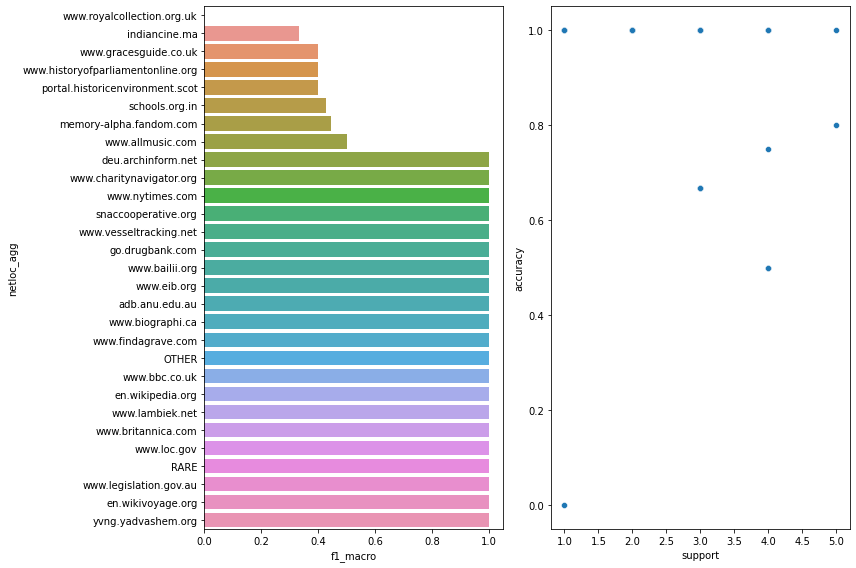

In [431]:
fig, ax = plt.subplots(1, 2, figsize = (12,8))

sns.barplot(
    data=class_metrics_per_netloc,
    y = 'netloc_agg',
    x='f1_macro',
    order=class_metrics_per_netloc.sort_values('f1_macro')['netloc_agg'],
    ax=ax[0]
)

sns.scatterplot(
    data=class_metrics_per_netloc,
    y ='accuracy',
    x='support',
    ax=ax[1]
)

plt.tight_layout()

C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


              precision    recall  f1-score   support

           0       0.92      0.98      0.95       186
           1       0.50      0.16      0.24        19

    accuracy                           0.91       205
   macro avg       0.71      0.57      0.60       205
weighted avg       0.88      0.91      0.88       205



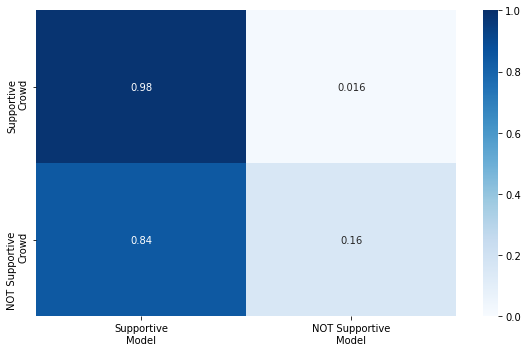

In [459]:
X_train, X_test, y_train, y_test = tts(X_manual, y_manual.map(to_two_class), test_size=0.5, random_state=42)

def train_test_XGBC(X_train, X_test, y_train, y_test, weight_0, print_cm=True, print_cr=True):

    class_weights = dict(1/y_train.value_counts(normalize=True))
    class_weights[0] = class_weights[0]*weight_0

    xgbc = xgb.XGBClassifier(
        #class_weight=class_weights,
        n_estimators = 100,
        max_depth = 3
    )

    xgbc.fit(
        sample_weight = [class_weights[y] for y in y_train],
        X = X_train,
        y = y_train,
        eval_metric = 'logloss'
    )

    y_pred = xgbc.predict(X_test)
    y_true = y_test
 
    if print_cm:
        cm = confusion_matrix(
            y_pred = y_pred,
            y_true = y_true,
            normalize='true'
        )

        fig, ax = plt.subplots(1,1, figsize=(8,5))
        g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
        g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
        g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

        plt.tight_layout()
    if print_cr:
        print(classification_report(
            y_pred = y_pred,
            y_true = y_true,
            zero_division=0
        ))
    return classification_report(
        y_pred = y_pred,
        y_true = y_true,
        zero_division=0,
        output_dict = True
    ), xgbc, y_pred, y_true

_, xgbc, y_pred, y_true = train_test_XGBC(X_train, X_test, y_train, y_test, 1)

0.7705149971703453


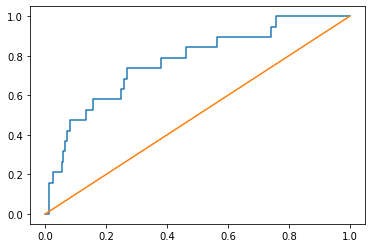

In [460]:
y_pred_prob = xgbc.predict_proba(X_test)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);

### Sub-labels (A-D)

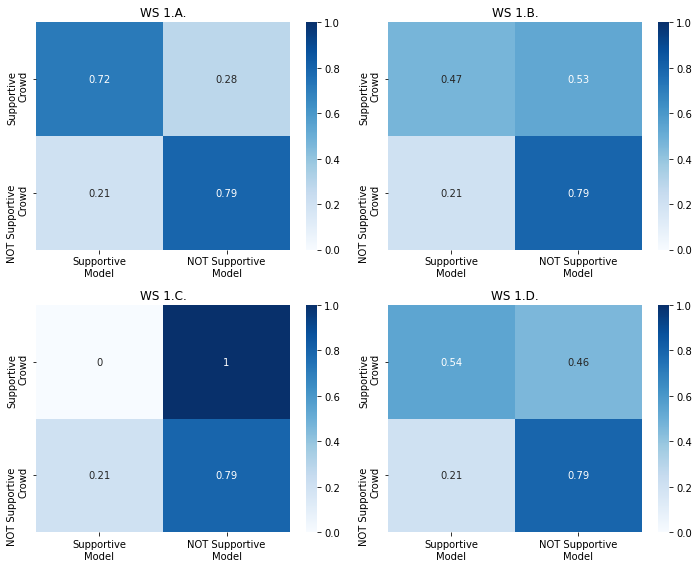

In [432]:
fig, ax = plt.subplots(2,2,figsize=(10,8))

for i, l in enumerate(['1.A.','1.B.','1.C.', '1.D.']):
    manual_vs_crowd_df_scores_l = manual_vs_crowd_df_scores[
        manual_vs_crowd_df_scores['manual_label'].isin(['2.A.', '2.B.', l])
    ]
    cm = confusion_matrix(
        y_true = manual_vs_crowd_df_scores_l['manual_label_relation'].map(to_two_class),
        y_pred = manual_vs_crowd_df_scores_l['WS_TE_id'].map(to_two_class),
        normalize='true'
    )

    g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax[i//2,i%2], vmin=0, vmax=1)
    g.set_title(f'WS {l}')
    g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
    g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

plt.tight_layout()

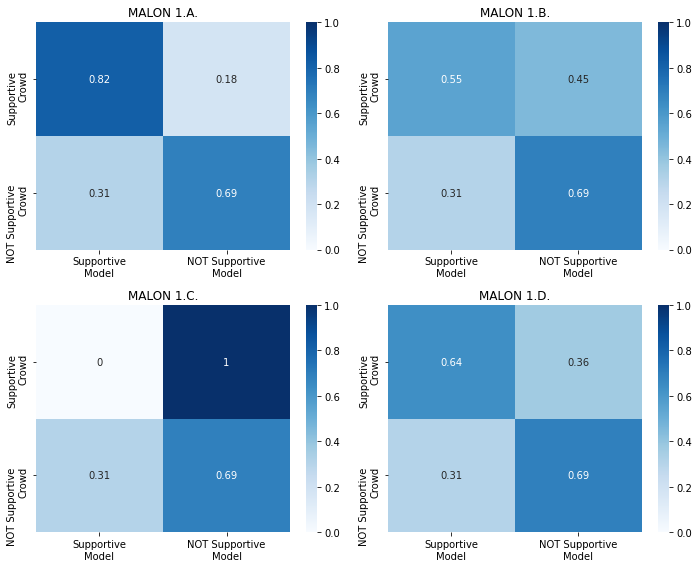

In [433]:
fig, ax = plt.subplots(2,2,figsize=(10,8))

for i, l in enumerate(['1.A.','1.B.','1.C.', '1.D.']):
    manual_vs_crowd_df_scores_l = manual_vs_crowd_df_scores[
        manual_vs_crowd_df_scores['manual_label'].isin(['2.A.', '2.B.', l])
    ]
    cm = confusion_matrix(
        y_true = manual_vs_crowd_df_scores_l['manual_label_relation'].map(to_two_class),
        y_pred = manual_vs_crowd_df_scores_l['MALON_TE_id'].map(to_two_class),
        normalize='true'
    )

    g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax[i//2,i%2], vmin=0, vmax=1)
    g.set_title(f'MALON {l}')
    g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
    g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

plt.tight_layout()

In [434]:
for i, l in enumerate(['1.A.','1.B.','1.C.', '1.D.']):
    manual_vs_crowd_df_scores_l = manual_vs_crowd_df_scores[
        manual_vs_crowd_df_scores['manual_label'].isin(['2.A.', '2.B.', l])
    ]
    
    cr = classification_report(
        y_true = manual_vs_crowd_df_scores_l['manual_label_relation'].map(to_two_class),
        y_pred = manual_vs_crowd_df_scores_l['WS_TE_id'].map(to_two_class),
    )
    print(f'WS {l}')
    print(cr)

    cr = classification_report(
        y_true = manual_vs_crowd_df_scores_l['manual_label_relation'].map(to_two_class),
        y_pred = manual_vs_crowd_df_scores_l['MALON_TE_id'].map(to_two_class),
    )
    print(f'MALON {l}')
    print(cr)

WS 1.A.
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       131
           1       0.46      0.79      0.58        39

    accuracy                           0.74       170
   macro avg       0.69      0.76      0.69       170
weighted avg       0.81      0.74      0.75       170

MALON 1.A.
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       131
           1       0.53      0.69      0.60        39

    accuracy                           0.79       170
   macro avg       0.71      0.75      0.73       170
weighted avg       0.81      0.79      0.80       170

WS 1.B.
              precision    recall  f1-score   support

           0       0.89      0.47      0.62       140
           1       0.30      0.79      0.43        39

    accuracy                           0.54       179
   macro avg       0.59      0.63      0.52       179
weighted avg       0.76      0.54      0.58    

In [435]:
X_l, y_l = {}, {}

for i, l in enumerate(['1.A.','1.B.','1.C.', '1.D.']):

    results_evidence_grouped_manual_l = results_evidence_grouped_manual[
        results_evidence_grouped_manual['manual_label'].isin(['2.A.', '2.B.', l])
    ].reset_index(drop=True)

    X_l[l] = results_evidence_grouped_manual_l[
        [f'{c}_{i}' for c in ['score','Supports_prob','Neither_prob','evidence_len'] for i in range(5)]
    ]

    y_l[l] = results_evidence_grouped_manual_l['manual_label_relation']

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        67
           1       0.72      0.72      0.72        18

    accuracy                           0.88        85
   macro avg       0.82      0.82      0.82        85
weighted avg       0.88      0.88      0.88        85



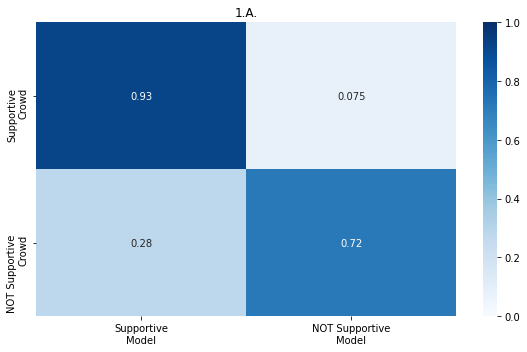

In [461]:
#for i, l in enumerate(['1.A.','1.B.','1.C.', '1.D.']):


def train_RFC_manual_sublabel(X_train, X_test, y_train, y_test, weight_0, l, print_cm=True, print_cr=True):    

    #X_train, X_test, y_train, y_test = tts(X_l[l], y_l[l].map(to_two_class), test_size=0.5, random_state=42)
    X_res, y_res = X_train, y_train

    class_weights = dict(1/y_train.value_counts(normalize=True))
    if 0 in class_weights:
        class_weights[0] = class_weights[0]*weight_0

    rfc = RFC(
        class_weight=class_weights,
        n_estimators = 100,
        max_depth = 3
    )

    rfc.fit(
        X = X_res,
        y = y_res
    )

    y_pred = rfc.predict(X_test)
    y_true = y_test
    
    if print_cm:
        fig, ax = plt.subplots(1,1,figsize=(8,5))

        cm = confusion_matrix(
            y_pred = y_pred,
            y_true = y_true,
            normalize='true'
        )

        g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
        g.set_title(l)
        g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
        g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

        plt.tight_layout()

    if print_cr:
        print(classification_report(
            y_pred = y_pred,
            y_true = y_true,
            zero_division=0
        ))
        
    return classification_report(
        y_pred = y_pred,
        y_true = y_true,
        zero_division=0,
        output_dict = True
    ), rfc, y_pred, y_true
    
#for i, l in enumerate(['1.A.','1.B.','1.C.', '1.D.']):
l = '1.A.'
X_train, X_test, y_train, y_test = tts(X_l[l], y_l[l].map(to_two_class), test_size=0.5, random_state=42)
_, rfc, y_pred, y_true = train_RFC_manual_sublabel(X_train, X_test, y_train, y_test, 1, l);

In [463]:
from sklearn.model_selection import StratifiedKFold

def train_RFC_manual_sublabel_kfold(X_l, y_l, weight_0, l, n_splits=3):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    outputs = []
    for train_index, test_index in skf.split(X_l[l], y_l[l]):
        X_train, X_test = X_l[l].iloc[train_index], X_l[l].iloc[test_index]
        y_train, y_test = y_l[l].iloc[train_index].map(to_two_class), y_l[l].iloc[test_index].map(to_two_class)

        outputs.append(train_RFC_manual_sublabel(
            X_train, X_test,
            y_train, y_test,
            weight_0, l, print_cm=False, print_cr=False
        )[0])

    print('0 - recall - precision - f1')
    print(np.mean([output['0']['recall'] for output in outputs]))
    print(np.mean([output['0']['precision'] for output in outputs]))
    print(np.mean([output['0']['f1-score'] for output in outputs]))
    print('1 - recall - precision - f1')
    print(np.mean([output['1']['recall'] for output in outputs]))
    print(np.mean([output['1']['precision'] for output in outputs]))
    print(np.mean([output['1']['f1-score'] for output in outputs]))
    print('acc - macro f1')
    print(np.mean([output['accuracy'] for output in outputs]))
    print(np.mean([output['macro avg']['f1-score'] for output in outputs]))
    
train_RFC_manual_sublabel_kfold(X_l, y_l, 1, '1.A.')

0 - recall - precision - f1
0.9466173361522198
0.9116985457410989
0.9286546786546787
1 - recall - precision - f1
0.6923076923076922
0.8034965034965036
0.7416387959866221
acc - macro f1
0.8882623224728489
0.8351467373206504


0.9162520729684909


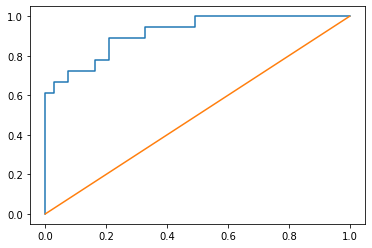

In [465]:
y_pred_prob = rfc.predict_proba(X_test)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);

              precision    recall  f1-score   support

           0       0.80      0.91      0.85        66
           1       0.60      0.38      0.46        24

    accuracy                           0.77        90
   macro avg       0.70      0.64      0.66        90
weighted avg       0.75      0.77      0.75        90



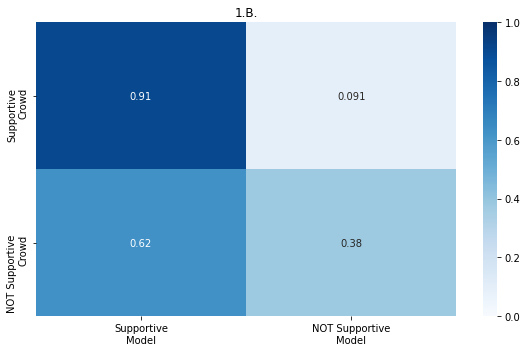

In [466]:
l = '1.B.'
X_train, X_test, y_train, y_test = tts(X_l[l], y_l[l].map(to_two_class), test_size=0.5, random_state=42)
_, rfc, y_pred, y_true = train_RFC_manual_sublabel(X_train, X_test, y_train, y_test, 1, l);

In [467]:
train_RFC_manual_sublabel_kfold(X_l, y_l, 1, '1.B.')

0 - recall - precision - f1
0.9219858156028368
0.8511392999765093
0.8821415474880822
1 - recall - precision - f1
0.4102564102564103
0.7124183006535948
0.4749914000687994
acc - macro f1
0.8102636534839925
0.6785664737784408


0.6672979797979798


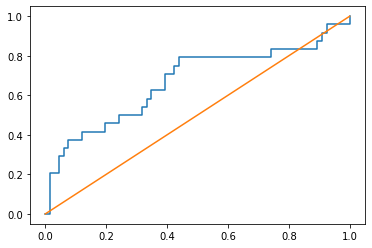

In [468]:
y_pred_prob = rfc.predict_proba(X_test)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.86      1.00      0.92        18

    accuracy                           0.86        21
   macro avg       0.43      0.50      0.46        21
weighted avg       0.73      0.86      0.79        21



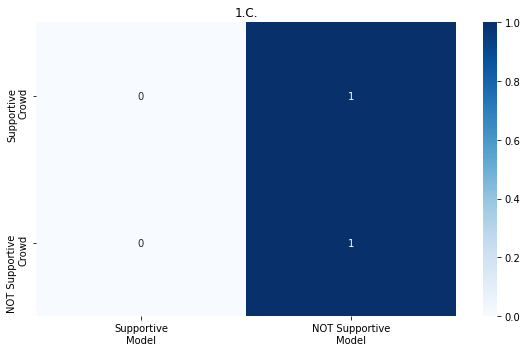

In [469]:
l = '1.C.'
X_train, X_test, y_train, y_test = tts(X_l[l], y_l[l].map(to_two_class), test_size=0.5, random_state=42)
_, rfc, y_pred, y_true = train_RFC_manual_sublabel(X_train, X_test, y_train, y_test, 1, l);

In [470]:
train_RFC_manual_sublabel_kfold(X_l, y_l, 1, '1.C.')

0 - recall - precision - f1
0.0
0.0
0.0
1 - recall - precision - f1
1.0
0.9285714285714285
0.9629629629629631
acc - macro f1
0.9285714285714285
0.48148148148148157


              precision    recall  f1-score   support

           0       0.76      0.89      0.82        47
           1       0.62      0.38      0.47        21

    accuracy                           0.74        68
   macro avg       0.69      0.64      0.65        68
weighted avg       0.72      0.74      0.71        68



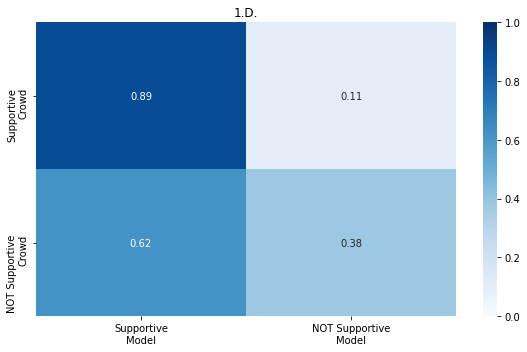

In [472]:
l = '1.D.'
X_train, X_test, y_train, y_test = tts(X_l[l], y_l[l].map(to_two_class), test_size=0.5, random_state=42)
_, rfc, y_pred, y_true = train_RFC_manual_sublabel(X_train, X_test, y_train, y_test, 3, l);

In [473]:
train_RFC_manual_sublabel_kfold(X_l, y_l, 3, '1.D.')

0 - recall - precision - f1
0.8645833333333334
0.764367816091954
0.8069216757741349
1 - recall - precision - f1
0.3333333333333333
0.5458333333333333
0.38314176245210735
acc - macro f1
0.7111111111111111
0.595031719113121


0.7355623100303952


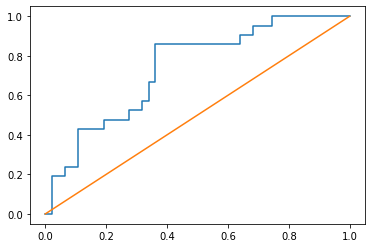

In [474]:
y_pred_prob = rfc.predict_proba(X_test)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);

### Trying XGBoost

[19:17:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        67
           1       0.70      0.78      0.74        18

    accuracy                           0.88        85
   macro avg       0.82      0.84      0.83        85
weighted avg       0.89      0.88      0.88        85



C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


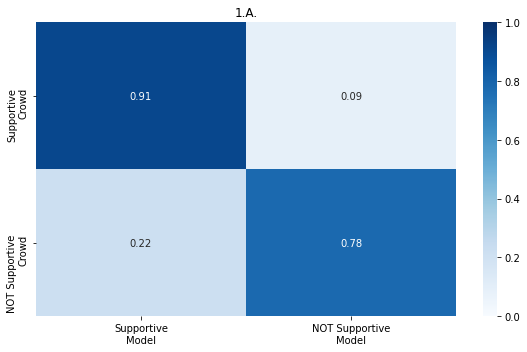

In [476]:
#for i, l in enumerate(['1.A.','1.B.','1.C.', '1.D.']):
import xgboost as xgb

def train_XGBC_manual_sublabel(X_train, X_test, y_train, y_test, weight_0, l, print_cm=True, print_cr=True):    

    #X_train, X_test, y_train, y_test = tts(X_l[l], y_l[l].map(to_two_class), test_size=0.5, random_state=42)
    X_res, y_res = X_train, y_train

    class_weights = dict(1/y_train.value_counts(normalize=True))
    if 0 in class_weights:
        class_weights[0] = class_weights[0]*weight_0

    xgbc = xgb.XGBClassifier(
        #class_weight=class_weights,
        n_estimators = 100,
        max_depth = 3
    )

    xgbc.fit(
        sample_weight = [class_weights[y] for y in y_train],
        X = X_res,
        y = y_res
    )

    y_pred = xgbc.predict(X_test)
    y_true = y_test
    
    if print_cm:
        fig, ax = plt.subplots(1,1,figsize=(8,5))

        cm = confusion_matrix(
            y_pred = y_pred,
            y_true = y_true,
            normalize='true'
        )

        g = sns.heatmap(cm, cmap='Blues', annot=True, ax=ax, vmin=0, vmax=1)
        g.set_title(l)
        g.set_xticklabels([x+'\nModel' for x in TWO_CLASS_LABELS])
        g.set_yticklabels([x+'\nCrowd' for x in TWO_CLASS_LABELS])

        plt.tight_layout()

    if print_cr:
        print(classification_report(
            y_pred = y_pred,
            y_true = y_true,
            zero_division=0
        ))
        
    return classification_report(
        y_pred = y_pred,
        y_true = y_true,
        zero_division=0,
        output_dict = True
    ), xgbc, y_pred, y_true
    
l = '1.A.'
X_train, X_test, y_train, y_test = tts(X_l[l], y_l[l].map(to_two_class), test_size=0.5, random_state=42)
_, xgbc, y_pred, y_true = train_XGBC_manual_sublabel(X_train, X_test, y_train, y_test, 1, l);

0.8963515754560532


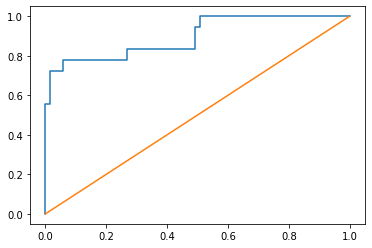

In [477]:
y_pred_prob = xgbc.predict_proba(X_test)
y_pred_prob = [pred[1] for pred in y_pred_prob]
get_roc(y_true, y_pred_prob);